# Построение модели машинного обучения для прогнозирования оттока сотрудников

## Описание проекта

Работаем с HR-аналитикой компании «Работа с заботой» котороя помогает бизнесу оптимизировать управление персоналом. Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Собирать данные такими опросниками трудно но важно потому что удовлетворённость работой напрямую влияет на отток сотрудников, а предсказание оттока — одна из важнейших задач HR-аналитиков, чтобы избежать рисков для компании, особенно если уходит важный сотрудник

## Цель исследования

Создать модель для прогнозирования уровня удовлетворенности работой сотрудников без дальнейшего использования опроса, а затем на основе результатов создайте модель для прогнозирования увольнения сотрудников.

## Ход исследования

Проект разделен на две части:
- Первая часть - модел регрессии, с непрерывной переменной как целовой признак :
    - Подгатовка данных: Загрузка и изучение общей информации из предоставлено датасета.
    - Предоработка данных: Обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
    - Исследовательский анализ данных: Изучение основных параметров объектов, их распределение, присутствие выбросов,  явление и обработка аномали
    - Анализ коррелации: Исследование связи между признаками чтобы понимать если нужно или нет установить несколко признаков
    - Построение пайплайн с методом оптимизации чтобы отобрать самую лучшую модель для МО
    - Анализы важности признаков чтобы понимать какие признаки важны и какие нет
    - Попытка увеличть качество модели при помощи устранения не важных призаков
- Вторая часть - модел классификации, с категоряльным значением как целовой признак :
    - Подгатовка данных: Загрузка и изучение общей информации из предоставленого датасета.
    - Предоработка данных: Обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
    - Исследовательский анализ данных: Изучение основных параметров объектов, их распределение, присутствие выбросов,  явление и обработка аномали
    - Анализ корреляции: Исследование связи между признаками чтобы понимать если нужно или нет устранить несколко признаких
    - Построение пайплайн с методом оптимизации чтобы отобрать самую лучшую модель для МО
    - Анализы важности признаков чтобы понимать какие признаки важны и какие нет
    - Попытка увеличть качество модели при помощи устранения не важных призаков
    - Изучение пределов модели и если она соответствует ожиданиям закачика

# Часть 1

## Загрузка данных

In [1]:
# Установим "руками" модули
!pip install phik -q

Name: scikit-learn
Version: 1.4.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /home/regis/anaconda3/envs/gpu_env_torch/lib/python3.11/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: category_encoders, imbalanced-learn, pmdarima, pycaret, pyod, scikit-plot, sentence-transformers, shap, sklearn-compat, sktime, tbats, yellowbrick


In [2]:
# библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import stats as st
from itertools import combinations

# загружаем phik модуль для коррелации
import phik
from sklearn.model_selection import train_test_split

# загружаем модуль SelectKBest
from sklearn.feature_selection import SelectKBest, f_classif

# загружаем модуль пермутации
from sklearn.inspection import permutation_importance

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import r2_score, make_scorer
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# загружаем нужные модели для classification
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

# загружаем нужные модели для classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# импортируем itertools
from itertools import combinations

### Данные с характеристиками сотрудников компании (тренировочная выборка):

In [3]:
df_sat = pd.read_csv('./train_job_satisfaction_rate.csv')
df_sat.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [4]:
df_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Датафрейм с характеристикам сотрудников компании содержит 4000 строки и 10 столбцов, 2 столбца с количественными данными: 

- salary, ежемесячная зарплата сотрудника;
- job_satisfaction_rate, уровень удовлетворённости сотрудника работой в компании, целевой признак;

и 8 столбцов с категориальными данными:
- id, уникальный идентификатор сотрудника;
- dept,  отдел, в котором работает сотрудник;
- level,  уровень занимаемой должности;
- workload,  уровень загруженности сотрудника;
- employment_years,  длительность работы в компании (в годах);	
- last_year_promo, показывает, было ли повышение за последний год;
- last_year_violations,  показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation, оценка качества работы сотрудника, которую дал руководитель;

Эти данные является тренировочной выборкой.
Отметим что ect 6 пропускти в столбце 'dept' и 4 в пропуски в столбце 'level'. Более того все значения в корректном типе, числа в числовом формате и стоки как тип object. 
Отметим что наверно у нас 4000 разных покупателей, нужно будет это проверить во время проверки дупликатов. 

### тестовая выборка:

In [5]:
X_test = pd.read_csv('./test_features.csv')
X_test.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [6]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Датафрейм с характеристикам сотрудников содержит 2000 строки и 9 столбцов. По конфигурации она как df_sat без столбцы целовое признак - 'job_satisfaction_rate'. 

Отметим что тот в тестовой датафрем в 2 раза меншее сотрудников чем в df_sat. 
Отметим что ect 2 пропуска в столбце 'dept' и 1 в пропуск в столбце 'level'. Более того все значения в корректном типе, числа в числовом формате и стоки как тип object. 

### Целевой признак тестовой выборки:

In [7]:
y_test = pd.read_csv('./test_target_job_satisfaction_rate.csv')
y_test.head()

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

In [8]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Датафрейм с целовым признаком - 'job_satisfaction_rate'. Он содержит 2000 строк как у датафрейма тестовой выборки X_test c входными признаками.
Отметим что нет пропусков в этой датафрейм.

## Предобработка данных

### Пропуски в датасетах

Заметили пропуски ну они очень мало они преставит 0,15% в столбе 'dept', и 0,1 % в столбце level, в датафреймк df_sat. В датафрейме X_test эти пропуски ещё меншее. 

Мы будем их отрабатывать во врмемя пайплайн, c SimpleImputer они не должень помешать нашему исследованию.

### Дупликаты

In [9]:
def find_obvious_duplicates(dataframe):
    return dataframe.duplicated().sum()
    
dataframes = [df_sat, X_test, y_test]
dataframes_names = ['df_satisfaction', 'X_test', 'y_test']

for index, dataframe in enumerate(dataframes):
    res = find_obvious_duplicates(dataframe)
    print(f'{res} явны дупликаты в датафрейме {dataframes_names[index]}')

0 явны дупликаты в датафрейме df_satisfaction
0 явны дупликаты в датафрейме X_test
0 явны дупликаты в датафрейме y_test


Нет явных дупликатов

#### Столбец 'id' точно содержит уникальное значение  ?

В датафрейм df_sat, X_test, y_test мы видели как будто было соответственно 4000 и 2000 разных сотрудники, нам нужно это проверить сейчас.

In [10]:
def check_duplicates_id(dataframe):
    return dataframe.duplicated(subset='id').sum()
    
dataframes = [df_sat, X_test, y_test]
dataframes_names = ['df_sat', 'X_test', 'y_test']

for index, dataframe in enumerate(dataframes):
    res = check_duplicates_id(dataframe)
    print(f'{res} дупликаты в столбце \'id\' в датафрейме {dataframes_names[index]}')

0 дупликаты в столбце 'id' в датафрейме df_sat
0 дупликаты в столбце 'id' в датафрейме X_test
0 дупликаты в столбце 'id' в датафрейме y_test


#### Проверка присутствия не явных дупликатов в других столбцах

In [11]:
# Список категориальных столбцов
col_cat = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

# Список датафрейм
dataframes = [df_sat, X_test]
# Список имя датафреймы
dataframes_names = ['df_sat', 'X_test']

#  Создаем пустой лист для соханиение резултат
list_unique = []

for dataframe in dataframes:
    list_unique_cat = {}
    
    for col in col_cat:
        if col in dataframe.columns:
            list_unique_cat[col] = dataframe[col].unique().tolist() 
    list_unique.append(list_unique_cat)
list_unique

[{'dept': ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
  'level': ['junior', 'middle', 'sinior', nan],
  'workload': ['medium', 'high', 'low'],
  'last_year_promo': ['no', 'yes'],
  'last_year_violations': ['no', 'yes']},
 {'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
  'level': ['junior', 'middle', 'sinior', nan],
  'workload': ['medium', 'low', 'high', ' '],
  'last_year_promo': ['no', 'yes'],
  'last_year_violations': ['no', 'yes']}]

Заметим что есть некоторые пустые значения ' ' :

In [12]:
# В столбце 'dept' X_test
X_test.query('dept == " "')

id dept   level workload  employment_years last_year_promo  \
1699  822186       middle   medium                 3              no   

     last_year_violations  supervisor_evaluation  salary  
1699                   no                      4   38400

In [13]:
# В столбце 'level' X_test
X_test.query('workload == " "')

id       dept   level workload  employment_years last_year_promo  \
15  590867  marketing  junior                          4              no   

   last_year_violations  supervisor_evaluation  salary  
15                   no                      4   28800

Только у 2 строк  пустые значения.

Нет другой проблемы в солбцах , кроме не правильно написанного слова 'senior'. Хоть это и не проблема но я скорректирю ее всё равно.

In [14]:
df_sat['level'].replace('sinior', 'senior', inplace=True)
df_sat['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [15]:
X_test['level'].replace('sinior', 'senior', inplace=True)
X_test['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [16]:
X_test['dept'].replace(' ', np.nan, inplace=True)
X_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [17]:
X_test['workload'].replace(' ', np.nan, inplace=True)
X_test['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

Мы заменили пустые значения с пропусками и их уберем во время пайплайна. Я знаю что мы можем заменить ordinalencoder с аттрибютом 'unknown_value' в пайплайн эти пустие значение с NaN значением. Но значения из столбцов 'dept' не содержат никаких отножений между ними вот поэтому мы не можем исползовать OrdinalEncoder в этом слуйчае. Так как с OneHotencoder нет аттрибутов 'unknown_value'  сейчас заменили пустые значения на NaN значения.

### Проверка пересечения

Провераем что у нас точно одно и то-же сотрудни в тестовой выборке.

In [18]:
inter_X_y_test = set(X_test['id']) & set(y_test['id'])
len(inter_X_y_test)

2000

Все сотрудник в X_test они действительно тоже в y_test.

Проверяем что нет одного и того же сотрудник в тренировочной и тестовой датафреймах, потому что это может привести к утечке данных.

In [19]:
inter_X_train_X_test = set(X_test['id']) & set(df_sat['id'])
len(inter_X_train_X_test)

0

У нас нет пересечение между df_sat и X_test

### Переиндексация

Втавим 'id' как индекс во все датафремах.

In [20]:
df_sat.set_index('id', inplace=True)
df_sat.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20

In [21]:
X_test.set_index('id', inplace=True)
X_test.head()

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
485046                   no                      5   28800  
686555                   no                      4   30000  
467458                   no                      4   19200  
418655                   no                      4   19200  
789145                   no                      5   40800

In [22]:
y_test.set_index('id', inplace=True)
y_test.head()

job_satisfaction_rate
id                           
130604                   0.74
825977                   0.75
418490                   0.60
555320                   0.72
826430                   0.08

Изменение порядка уникального индентификатора в столбце у_test чтобы порядок индентификатора был одним и тем же между датафрейм с выходным значением и целовым значением, будет важно во время обучение.

In [23]:
y_test = y_test.reindex(X_test.index)
y_test.head()

job_satisfaction_rate
id                           
485046                   0.79
686555                   0.72
467458                   0.64
418655                   0.60
789145                   0.75

Проверяем что мы не создали пропуски с методом  reindex.

In [24]:
y_test.shape

(2000, 1)

### Соединниние тестовие датафреймы

Чтобы построить несколких графиков, будет проще объединить датыфреймы из тестовых образцов.

In [25]:
df_sat_test = X_test.merge(y_test, on='id')

In [26]:
df_sat_test.shape

(2000, 9)

Соединниения получилась.

### Вывод

Обнаружили пропуски 10 в df_sat, наш датафрейм, с чем мы будем тренировать модель и 3 на датафрем, с чем мы будем тестировать тестировать. Эти пропуски мы будем отработать во время исполнения пайплайн. Отметили пустые значения в тестовой выборке которые мы заменили с зачением NaN, чтобы они были отработаны во время пайплайны. Проверили что индекс был уникальный в тренировочное выборке и тестовой, переиндексировал индекс из датафрейм с целевыми признаками чтобы они совпадали с тестовой датафрейм со входными признаками.

## Исследовательский анализ данных

### Статистика датафреймы

In [27]:
df_sat.describe()

employment_years  supervisor_evaluation        salary  \
count       4000.000000            4000.000000   4000.000000   
mean           3.718500               3.476500  33926.700000   
std            2.542513               1.008812  14900.703838   
min            1.000000               1.000000  12000.000000   
25%            2.000000               3.000000  22800.000000   
50%            3.000000               4.000000  30000.000000   
75%            6.000000               4.000000  43200.000000   
max           10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000

Отметим выбросы в salary на максимум, ну это не анномали, у этих людей просто большие зарплаты. Отметим тоже что есть очень не доволные сотрудники (0,03 на job_satisfaction_rate) и очень довольные (1 на job_satisfaction_rate).

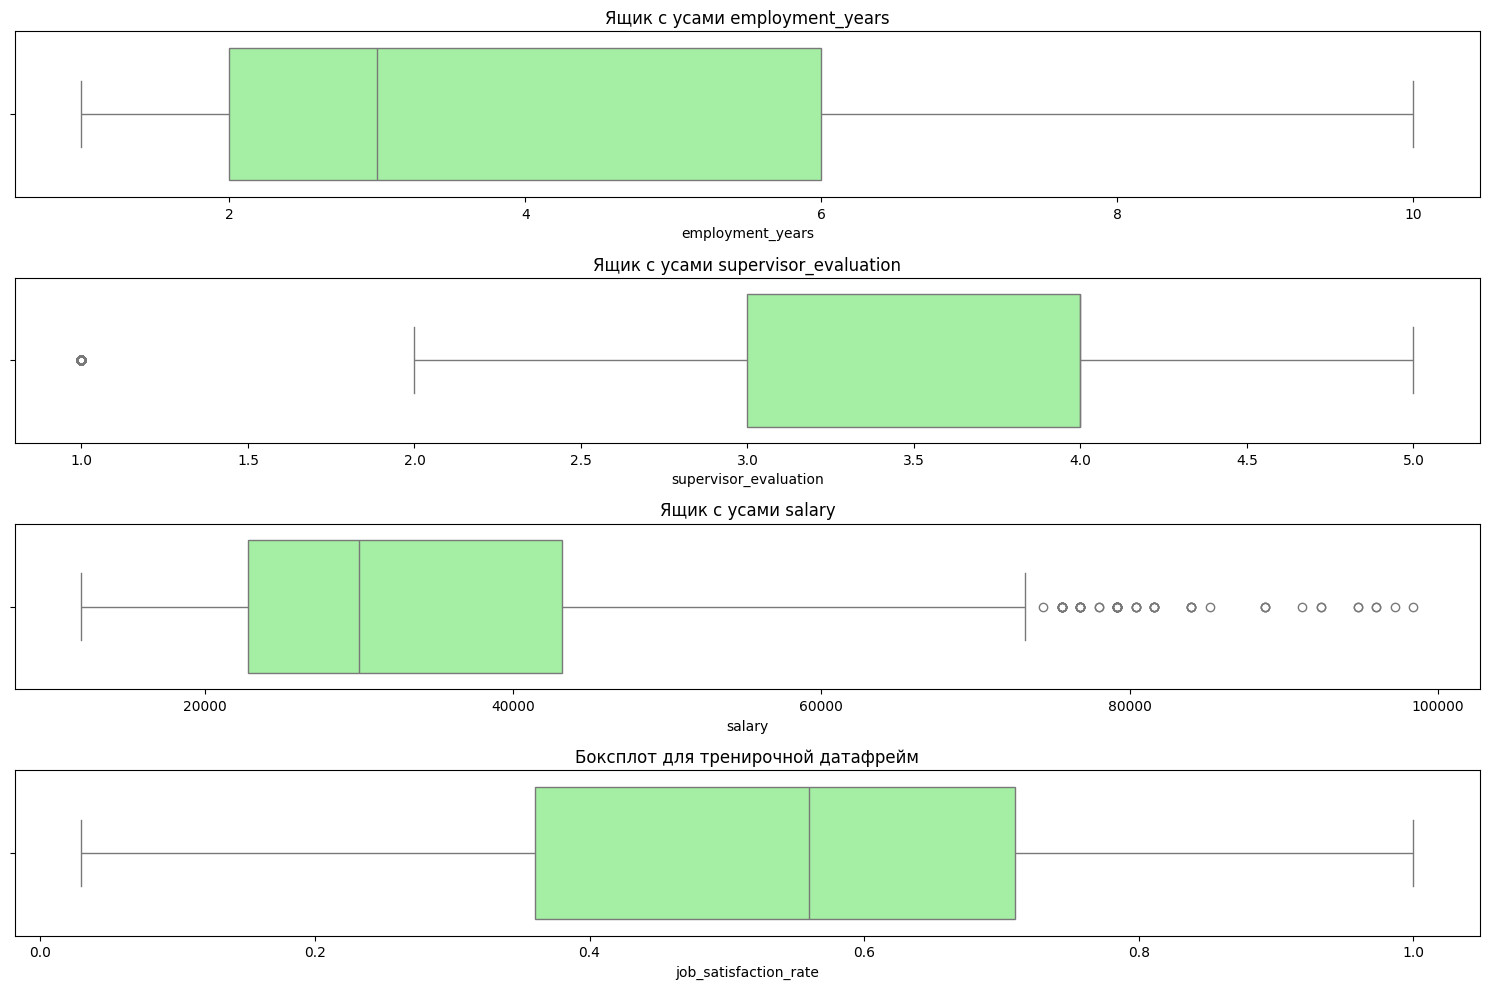

In [28]:
col_num = df_sat.select_dtypes(exclude='object').columns.to_list()

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))

axes = axes.flatten()

columns_names = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

for i, column in enumerate(df_sat[col_num].columns):
    
    sns.boxplot(data=df_sat, x=column, color='palegreen', ax=axes[i]) 
    
    axes[i].set_title(f'Ящик с усами {columns_names[i]}') 

plt.title('Боксплот для тренирочной датафрейм');
plt.tight_layout()


plt.show()

In [29]:
X_test.describe()

employment_years  supervisor_evaluation        salary
count       2000.000000            2000.000000   2000.000000
mean           3.666500               3.526500  34066.800000
std            2.537222               0.996892  15398.436729
min            1.000000               1.000000  12000.000000
25%            1.000000               3.000000  22800.000000
50%            3.000000               4.000000  30000.000000
75%            6.000000               4.000000  43200.000000
max           10.000000               5.000000  96000.000000

In [30]:
y_test.describe()

job_satisfaction_rate
count             2000.00000
mean                 0.54878
std                  0.22011
min                  0.03000
25%                  0.38000
50%                  0.58000
75%                  0.72000
max                  1.00000

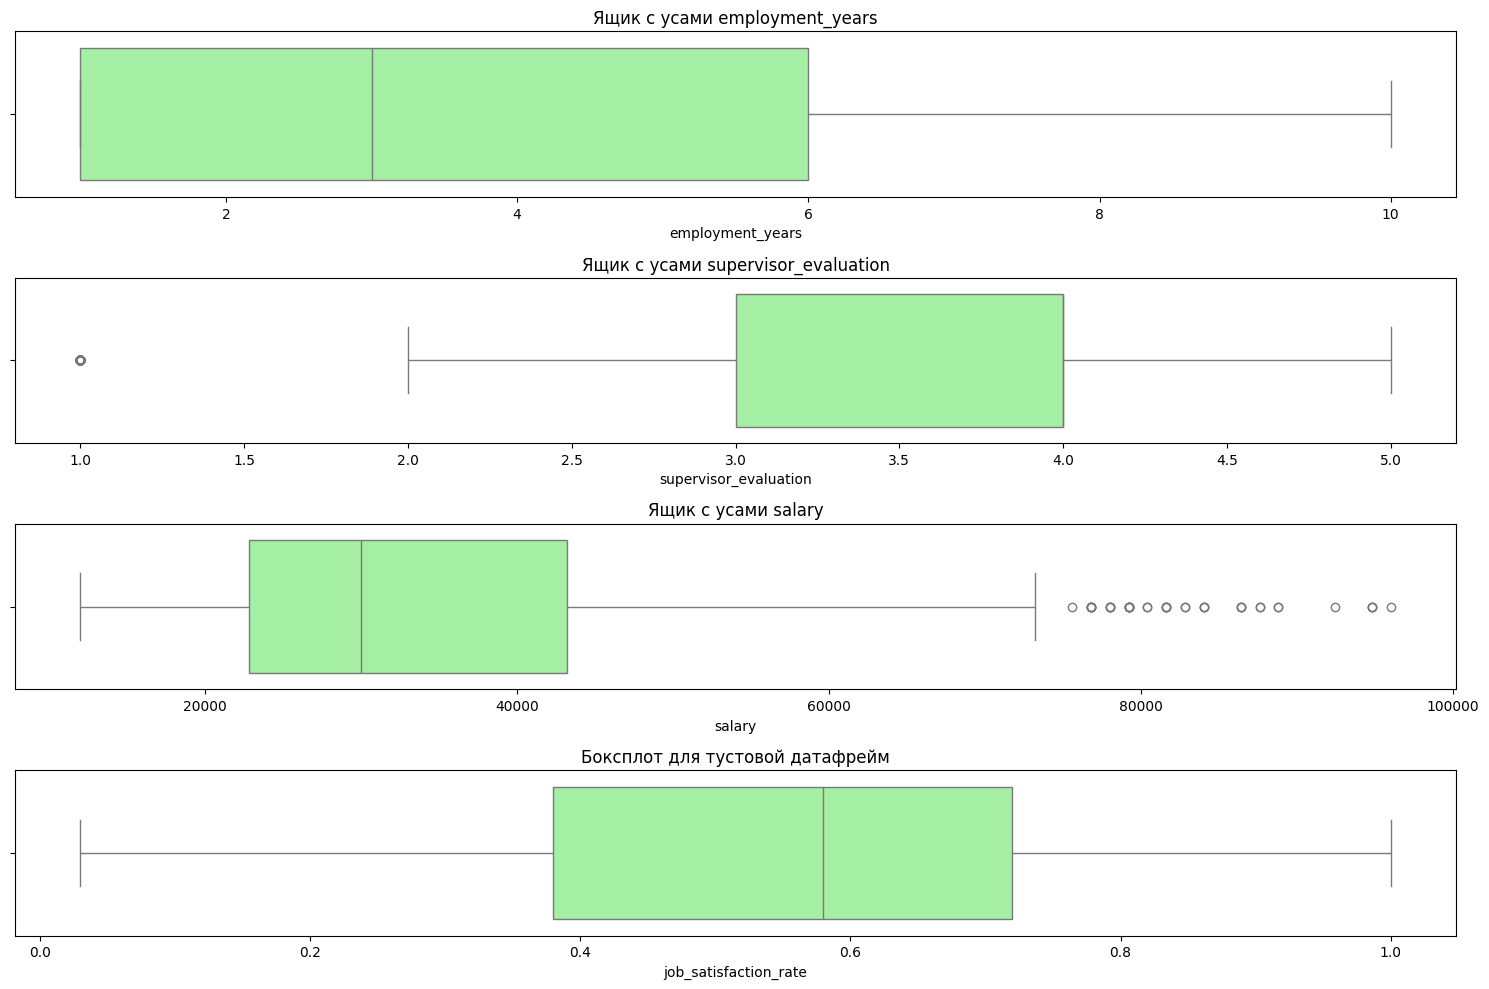

In [31]:
col_num = X_test.select_dtypes(exclude='object').columns.to_list()

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))

axes = axes.flatten()

dataframes = [X_test, y_test]

columns_names = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

for i, column in enumerate(X_test[col_num].columns):


    sns.boxplot(data=X_test, x=column, color='palegreen', ax=axes[i]) 

    axes[i].set_title(f'Ящик с усами {columns_names[i]}') 
        

sns.boxplot(data=y_test, x='job_satisfaction_rate', color='palegreen', ax=axes[i+1]) 

axes[i+1].set_title(f'Ящик с усами {columns_names[i+1]}') 
            
            
plt.title('Боксплот для тустовой датафрейм');
plt.tight_layout()


plt.show()

То, что мы видим в тренировочной выборке, это же мы видели в тестовой выборке. Всё это нам говорит что распределение выборки в тренировочной и тестовой очень похожи, однородны.

### Исследованние распеделения количеств значений

#### Распеделенние годов работы

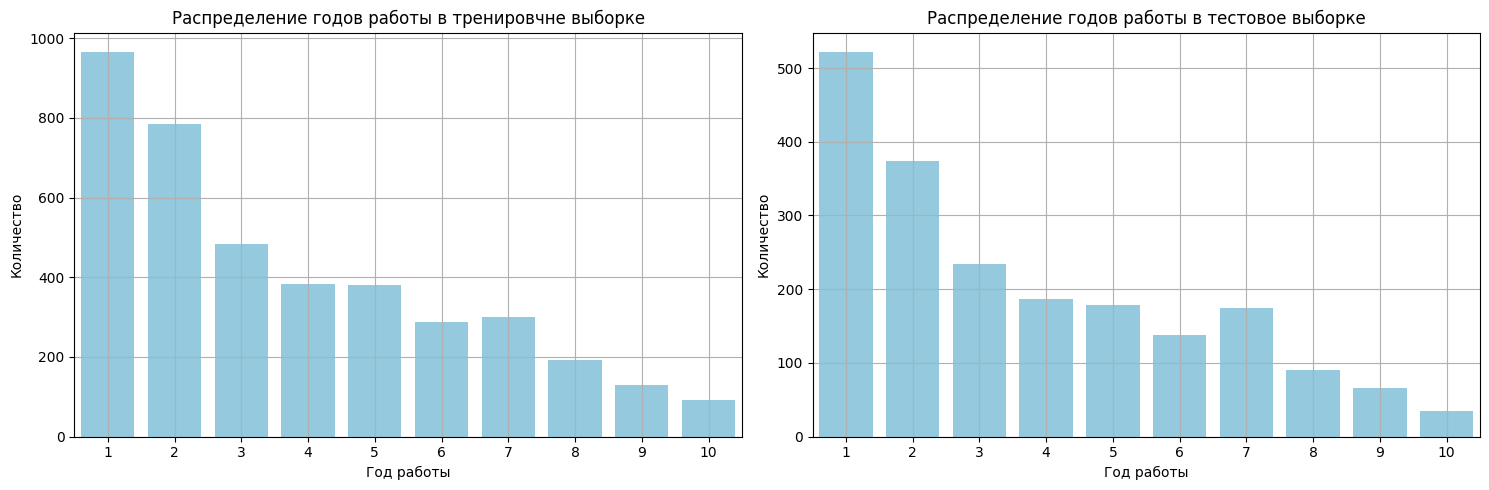

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_sat, X_test]

sample_type = ['в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):

    sns.countplot(x=dataframe['employment_years'], color = 'skyblue', ax=axes[i]);

    axes[i].set_title(f'Распределение годов работы {sample_type[i]}') 
    
    axes[i].set_xlabel('Год работы');
    axes[i].set_ylabel('Количество');
    axes[i].grid();
        

plt.tight_layout()


plt.show()

In [33]:
df_sat['employment_years'].describe()

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Сдезь распределения пуасона, так как у нас значение зависимы с временни. Сотрудники работают в компани в серединем, почти 4 года, точнее 3,7 лет (3 года и 9 месяц). Максимально работают 10 лет и минимально работают 1 год. Мы видим что 50% людей работают 3 года, и 25% работают болшее 6 лет. Отметим что распределение данних в тестовом выборке почти одиноковы как и в тренировочной.

#### Распеделенние оценки руководителя

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_sat, X_test]

sample_type = [' в тренировчной выборке', 'в тестовой выборке']

for i, dataframe in enumerate(dataframes):

    sns.countplot(x=dataframe['supervisor_evaluation'], color = 'skyblue', ax=axes[i])

    axes[i].set_title(f'Распределение оценок руководителя {sample_type[i]}') 
    
    axes[i].set_xlabel('Оценки руководителя');
    axes[i].set_ylabel('Количество');
    axes[i].grid();        

plt.tight_layout()


plt.show()

In [35]:
df_sat['supervisor_evaluation'].describe()

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Средная оценка сотрудников - 3,5, макимално - 5 и минимальное - 1. Отметим что 50% сотрудников получают 4 и болшее, пока 25% получають 3 и меншее, очень мало получають 1 и 2. Компани достаточно довольна своими стодруниками. Отметим что распределение данних в тестовом выборке почти одиноковы в тренировочной.

#### Распеделенние зарплаты

In [36]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 30))

axes = axes.flatten()

dataframes = [df_sat, X_test]

hue_col = ['dept', 'level', 'workload', 'employment_years', 'supervisor_evaluation', \
           'last_year_promo', 'last_year_violations']

sample_type = ['в тренировчной выборке', 'в тестовой выборке']

for j, hue_ in enumerate(hue_col):

    for i, dataframe in enumerate(dataframes):

        sns.histplot(x=dataframe['salary'], color = 'skyblue',hue=dataframe[hue_],  \
                         stat='density', common_norm=False, ax=axes[2*j+i])

        axes[2*j+i].set_title(f'Распределение зарплаты {sample_type[j%2]}') 

        axes[2*j+i].set_xlabel('Зарплаты');
        axes[2*j+i].set_ylabel('Плотность распределения');
        axes[2*j+i].grid();

plt.tight_layout()


plt.show()

In [37]:
df_sat['salary'].describe(percentiles = [0.25, 0.5, 0.75, 0.95])

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
95%      62400.000000
max      98400.000000
Name: salary, dtype: float64

Здесь распределение пуасона. Средная ежемесячная зарплата - 33927. Получают максимально - 98400. и минимально 12000.. 50% сотрудников получают 30000 и меньше, и 75% получают 43200 и меньше. Понятно что мы видели выбросы, толко 5% сотрудников получают 62400 и болшее. Отметим что распределение данных в тестовой выборке и тренировочной похожи. 
На графике мы видим, что зарплата сильно зависит от опыта, что логично: самая высокая зарплата у самых опытных людей, но не только, они также могут получать более низкую зарплату. Самая низкая зарплата у сотрудников младшего звена и части среднего звена, а зарплата выше 40 000 в основном у сотрудников среднего и высшего звена.
Зарплаты тоже зависят от нагрузки,опыта работы и лет работы в компании.


#### Распеделенние уровеня удовлетворенности работы

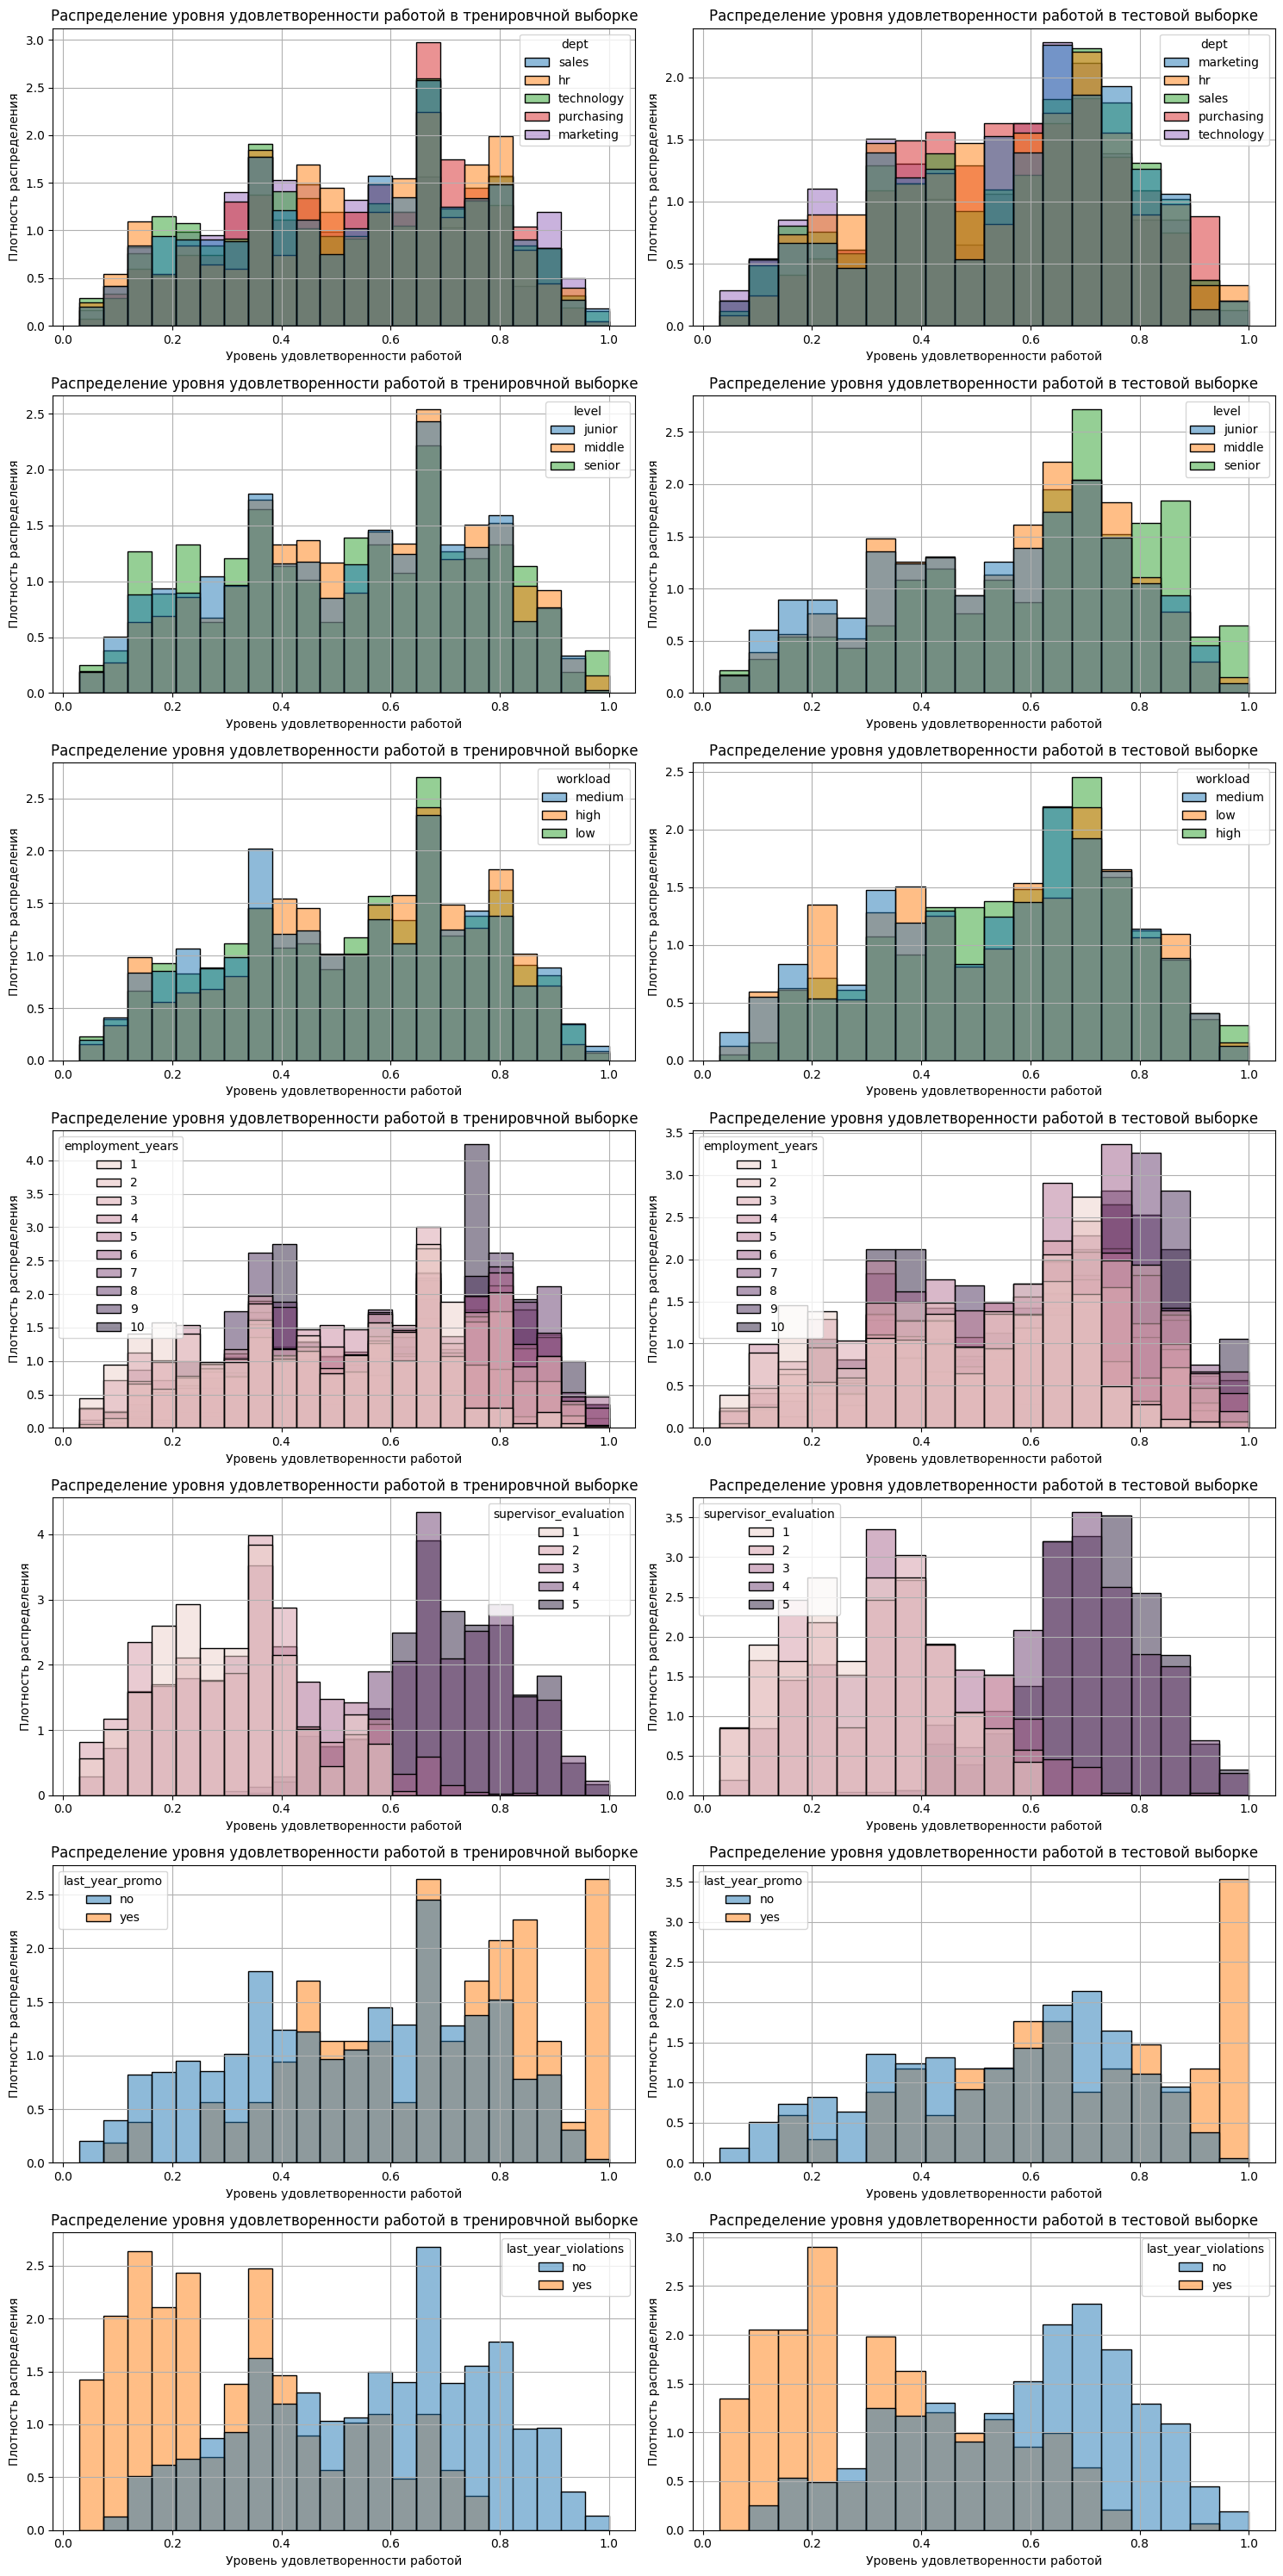

In [38]:

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 30))

axes = axes.flatten()

dataframes = [df_sat, df_sat_test]

hue_col = ['dept', 'level', 'workload', 'employment_years', 'supervisor_evaluation', \
           'last_year_promo', 'last_year_violations']

sample_type = ['в тренировчной выборке', 'в тестовой выборке']

for j, hue_ in enumerate(hue_col):

    for i, dataframe in enumerate(dataframes):

        sns.histplot(x=dataframe['job_satisfaction_rate'], color = 'skyblue',hue=dataframe[hue_],  \
                         stat='density', common_norm=False, ax=axes[2*j+i])

        axes[2*j+i].set_title(f'Распределение уровня удовлетворенности работой {sample_type[i%2]}') 

        axes[2*j+i].set_xlabel('Уровень удовлетворенности работой');
        axes[2*j+i].set_ylabel('Плотность распределения');
        axes[2*j+i].grid();

plt.tight_layout()


plt.show()

In [39]:
df_sat['job_satisfaction_rate'].describe()

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

Средная оценка - 0.53, самая низкая - 0,03 и самая высокая - 1. Есть и очень довольные и очень не довольные сотрудники. Ну мы видим пик около 0,65. Вообще сотрудники досточно доволны, если посмотреть оценки руководиля. Отметим что распределение данних в тестовом выборке и тренировочной похожи, болшее пиков в тестовой. Мы видим что уровень удовлетворенности работой  зависит от оценки руководителя, количества лет работы, нарушений в прошлом году и немного от повышений в прошлом году.

### Исследованние распеделения категориального значения

#### Распеделение сотруников в разных отделах

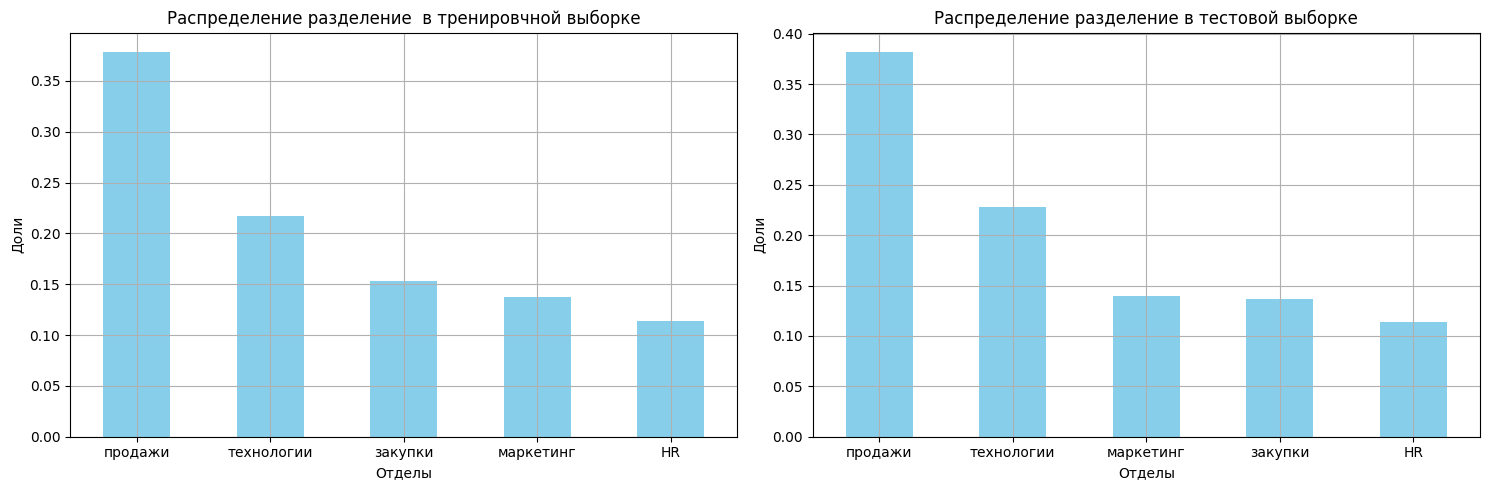

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_sat, X_test]

sample_type = [' в тренировчной выборке', 'в тестовой выборке']

for i, dataframe in enumerate(dataframes):
    
    dataframe['dept'].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

    axes[i].set_title(f'Распределение разделение {sample_type[i]}');
    
    axes[i].set_xlabel('Отделы');
    axes[i].set_ylabel('Доли');
    #axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();

axes[0].set_xticklabels(['продажи', 'технологии', 'закупки', 'маркетинг', 'HR'], rotation=0)
axes[1].set_xticklabels(['продажи', 'технологии', 'маркетинг', 'закупки', 'HR'], rotation=0)
plt.tight_layout()


plt.show()

In [41]:
df_sat['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

Болшинство сотрудников работают в продажах, второй самый многочисленный отдел - технологии. Меншее сотрудников в HR отделе. Отметим что распределение данних в тестовой выборке почти такие же как и в тренировочной.

#### Распеделение уровеня опыта

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_sat, X_test]

sample_type = ['в тренировчной выборке', 'в тестовой выборке']

for i, dataframe in enumerate(dataframes):
    
    dataframe['level'].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

    axes[i].set_title(f'Распределение уровеня опыты {sample_type[i]}');
    
    axes[i].set_xlabel('Уровень опыта');
    axes[i].set_ylabel('Доли');
    #axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();

axes[0].set_xticklabels(['новичок', 'средний', 'старший'], rotation=0)
axes[1].set_xticklabels(['новичок', 'средний', 'старший'], rotation=0)

plt.tight_layout()


plt.show()

У болшинства сотрудников мало опыта и есть опыт. С малым опытом больше, но перцент близок к средному уровню опыта. У компани меншее 10% сотрудников очень опытные. Отметим что распределение данных в тестовой выборке почти такое же, как и у тренировочной.

#### Распеделение нагрузки работы

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_sat, X_test]

sample_type = [' в тренировчной выборке', 'в тестовой выборке']

for i, dataframe in enumerate(dataframes):
    
    dataframe['workload'].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

    axes[i].set_title(f'Распеделение нагрузки работы {sample_type[i]}');
    
    axes[i].set_xlabel('Нагрузка работы');
    axes[i].set_ylabel('Доли');
    #axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();

axes[0].set_xticklabels(['средний', 'низкий', 'высокий'], rotation=0)
axes[1].set_xticklabels(['средний', 'низкий', 'высокий'], rotation=0)

plt.tight_layout()


plt.show()

По поводу нагрузки работы мы видим что больше, чем у 50% средная загрузка, у 30% - низкая и у 20% высокая. Было бы интересно понять как загрузка расчитана по часам работы, тогда мы смогли бы лучшее интерпретировать. Было бы странно если бы люди сами говорили что у них низская  нагрузка, обычное никто так не говорит а то бы руковадитель добавил работу. Наверно компание так считает нагрузку...Отметим что распределение данних в тестовой выборке почти такое же как у тренировочной.

#### Распеделение повышения в прошлом году

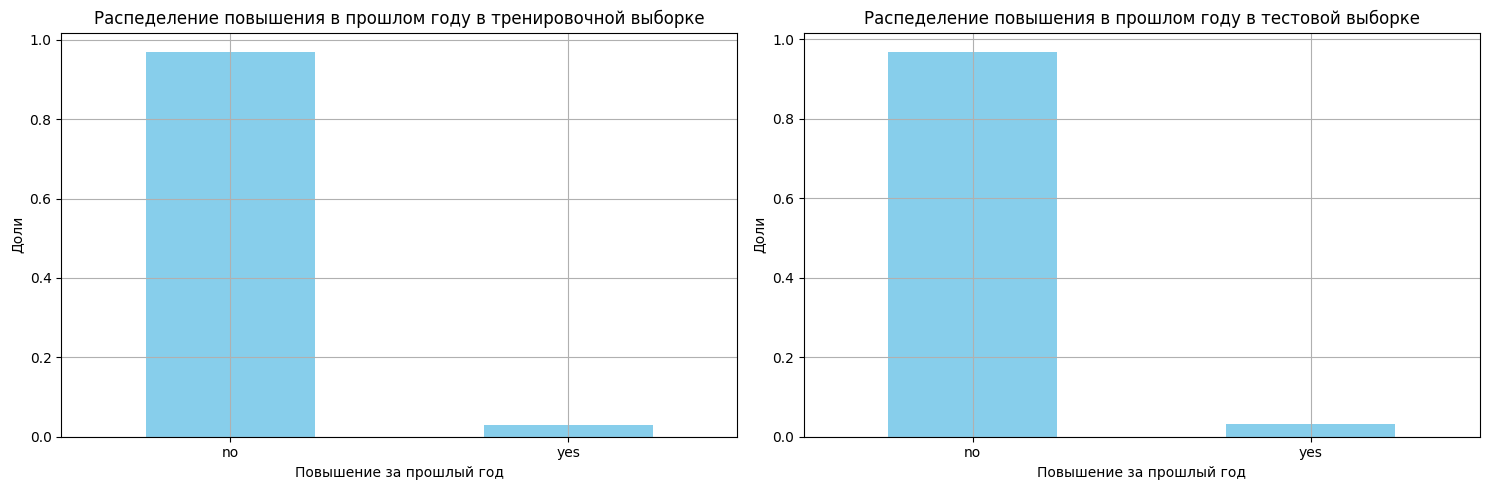

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_sat, X_test]

sample_type = ['в тренировочной выборке', 'в тестовой выборке']

for i, dataframe in enumerate(dataframes):
    
    dataframe['last_year_promo'].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

    axes[i].set_title(f'Распеделение повышения в прошлом году {sample_type[i]}');
    
    axes[i].set_xlabel('Повышение за прошлый год');
    axes[i].set_ylabel('Доли');
    axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();


plt.tight_layout()


plt.show()

In [45]:
df_sat['last_year_promo'].value_counts(normalize=True)

last_year_promo
no     0.97
yes    0.03
Name: proportion, dtype: float64

Болшинство людей не получили повышение (97%), а только 120 сотрудников получили.

In [46]:
df_sat.query('last_year_promo == "yes"').describe()

employment_years  supervisor_evaluation        salary  \
count        120.000000             120.000000    120.000000   
mean           4.508333               3.400000  47460.000000   
std            2.041567               1.032253  14579.428353   
min            1.000000               1.000000  19200.000000   
25%            3.000000               3.000000  38100.000000   
50%            5.000000               4.000000  46800.000000   
75%            6.000000               4.000000  56400.000000   
max           10.000000               5.000000  97200.000000   

       job_satisfaction_rate  
count             120.000000  
mean                0.673000  
std                 0.214031  
min                 0.110000  
25%                 0.510000  
50%                 0.700000  
75%                 0.830000  
max                 1.000000

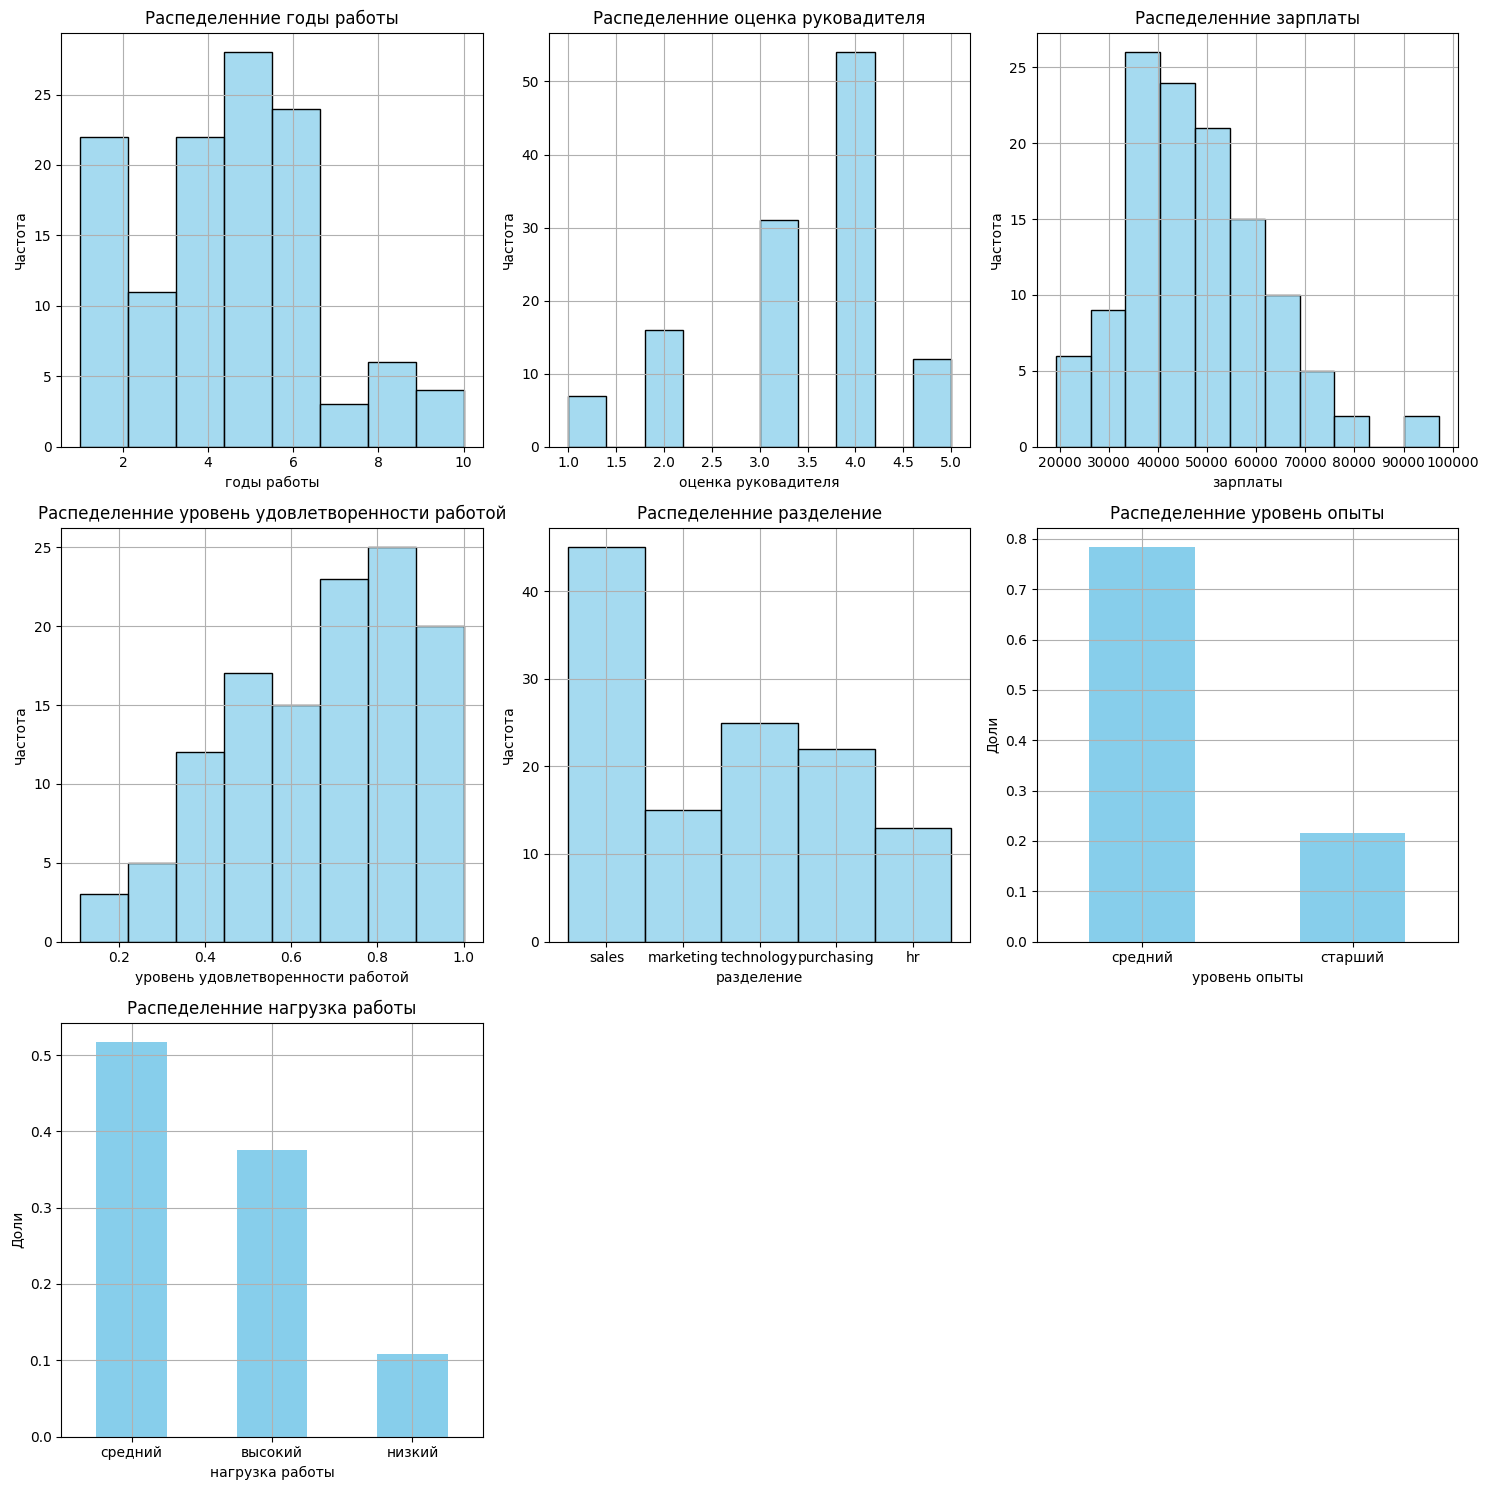

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

axes = axes.flatten()

data = df_sat.query('last_year_promo == "yes"')

col_ = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate', \
           'dept', 'level', 'workload']
col_names = ['годы работы', 'оценка руковадителя', 'зарплаты', 'уровень удовлетворенности работой', \
             'разделение', 'уровень опыты', 'нагрузка работы']

for i, col in enumerate(col_):
    
    if i <5:
        
        sns.histplot(x=data[col], color = 'skyblue', ax=axes[i])
        axes[i].set_title(f'Распеделенние {col_names[i]}');
    
        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Частота');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
        
    else:
    
        data[col].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Доли');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
    
#axes[4].set_xticklabels(['продажи', 'маркетинг', 'технологии', 'закупки', 'HR'], rotation=0)    
axes[5].set_xticklabels(['средний', 'старший'], rotation=0)
axes[6].set_xticklabels(['средний', 'высокий', 'низкий'], rotation=0)

axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)

plt.tight_layout()


plt.show()

Так как нам нужно сделать модель которая должна предсказать кто уволняется, нам нужно понимать кто получает повышение. Заметно что данные не завысимы от отделов, потому что эти данные следуют из общих данных по отделам, конечно в отделе продаж и в отделе технологий больше получают повышения потому что большее количество сотрудников работают в этих отделах. И только 10% у кого мало нагрузки получают павышение. Мы видим что 25 % из этих людей дали оценку больше 0.7 и толко 25% эти людей 0,5 и меншее. 50% из этих людей получают 46800 и больше после повышения. Болшинство эти людей работали 6 лет и меншее. Интересно что даже оценка не влияет на получение повышение. Другими словами, кокда графики не повторяют предыдущие графики можем сказать что это влияет на повышение зарплаты. Значит что это нагрузка и уровень опыта которы сами влияют на повышение.

#### Распеделение нарушений в прошлом году

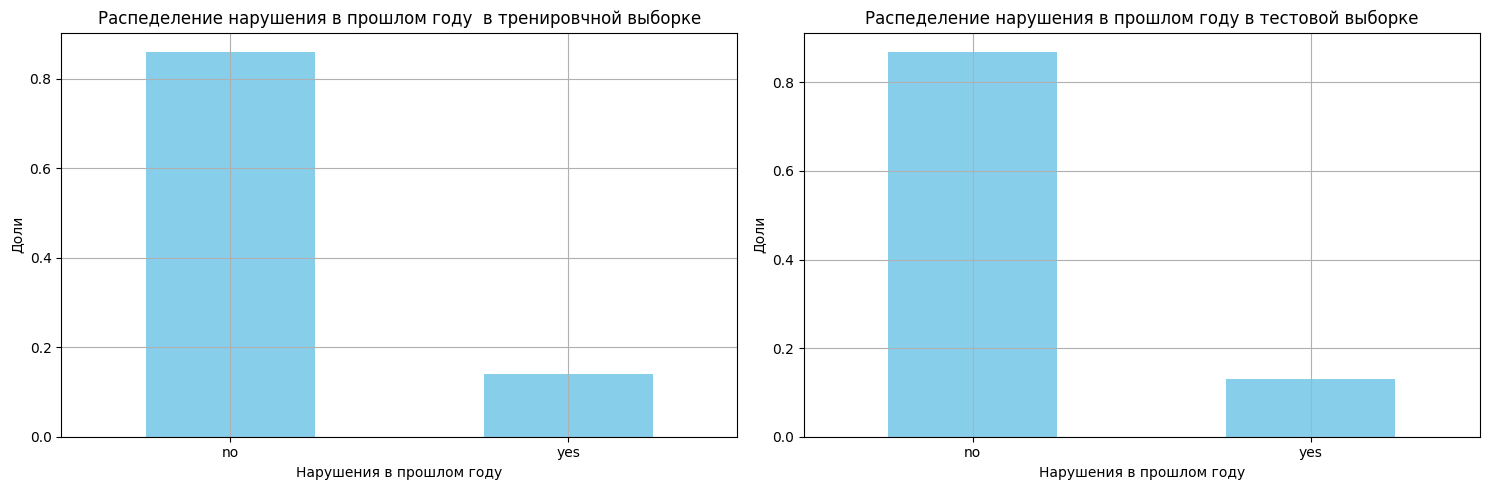

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_sat, X_test]

sample_type = [' в тренировчной выборке', 'в тестовой выборке']

for i, dataframe in enumerate(dataframes):
    
    dataframe['last_year_violations'].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

    axes[i].set_title(f'Распеделение нарушения в прошлом году {sample_type[i]}');
    
    axes[i].set_xlabel('Нарушения в прошлом году');
    axes[i].set_ylabel('Доли');
    axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();

plt.tight_layout()


plt.show()

In [49]:
df_sat['last_year_violations'].value_counts(normalize=True)

last_year_violations
no     0.86025
yes    0.13975
Name: proportion, dtype: float64

14% нарушили контракт в прошлом году.

### Вывод

Используя исследовательский анализ данных мы поняли что:
- 50% сотрудников остаются 3 года и меньшее, и только 25% отстаются 6 лет и болшее
- 25% сотрудников получают 3 и меншее по оценкам и 50% получают 4 и 5
- 50% сотрудников получають 30000 и меншее и толко 5% получают 62400 и большее, много выбросов в этом столбце 'salary' из за того что есть маленькая часть которую намного болшее получают.
- Зарплаты зависят от опыты, времени работы в компани и нагрузки, чем больше эти показатели, тем больше зарплаты получают людей
- 5 одтелов где люди работают, от самого многочисленного до менее многочисленного : 'продажи', 'технологии', 'закупки', 'маркетинг', 'HR'
- компания содержает 48% сотрудники с маленьким опытом, 43% со средним опытом и 9% с большим опытом
- у 51% сотрудников - срдная нагрузка, у 30% низка и у 19% высокая
- повышение было толко у 3% сотрудников в прошлом году
- 14% сотрудников нарушили трудовой договор

Все признаки в тренировочной и тестовой выборке распределены почти одинаково. Это важно для предскызывание МО.

In [50]:
df_sat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


## Корреляционный анализ

In [51]:
# Выбираем столбцы с числовым значением
#interval_cols = df_sat.select_dtypes(include='number')
interval_cols = ['salary', 'job_satisfaction_rate']

### Корреляционный анализ в тренировочной выборке

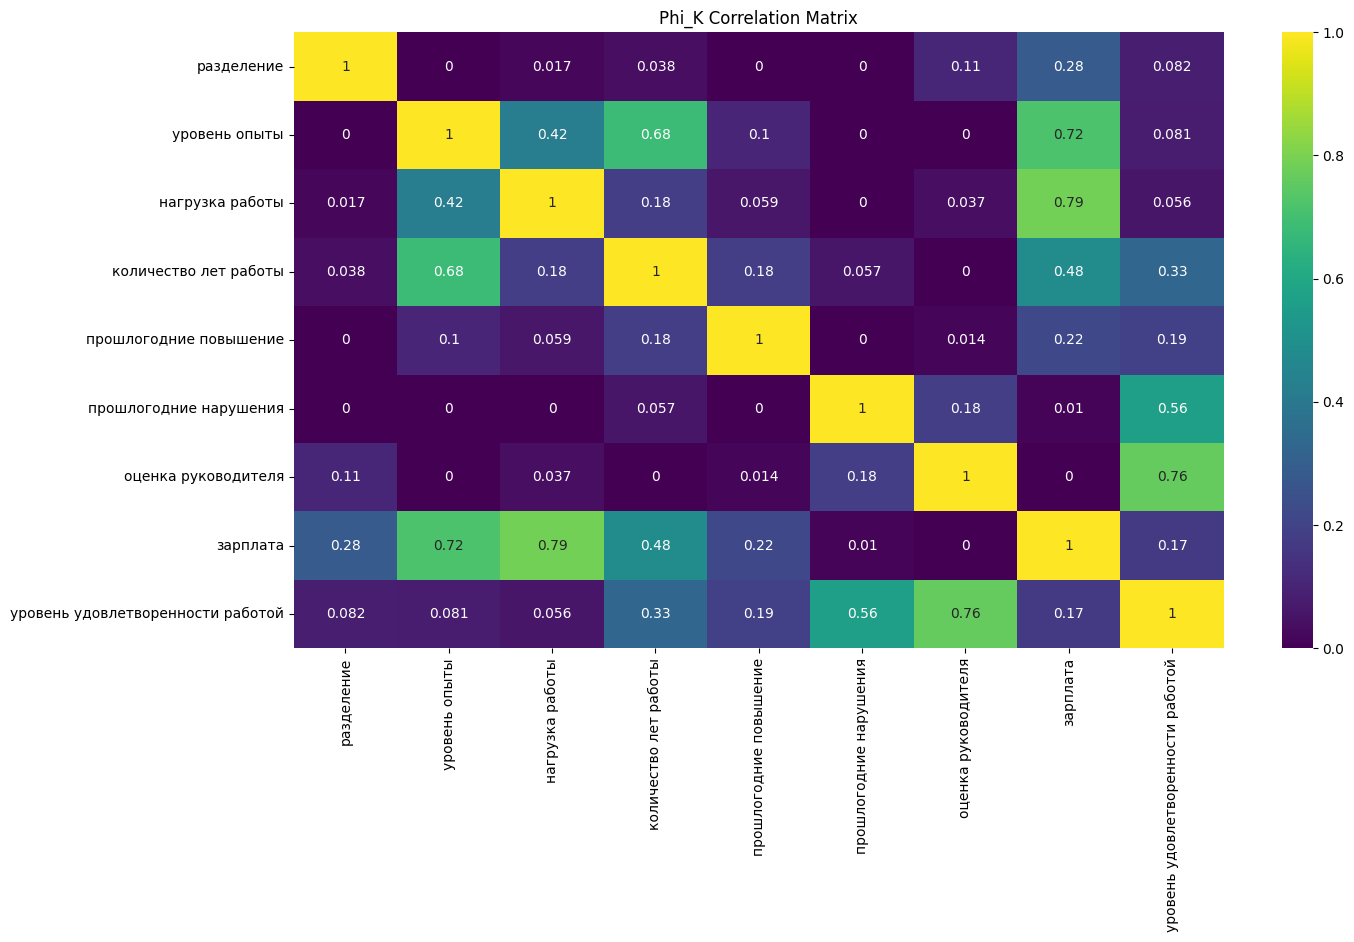

In [52]:
# Вычисляем матрицу корреляции с использованием phik
corr_matrix = df_sat.phik_matrix(interval_cols=interval_cols)

cols_name = ['разделение', 'уровень опыты', 'нагрузка работы', 'количество лет работы', \
             'прошлогодние повышение', 'прошлогодние нарушения', 'оценка руководителя', 'зарплата', \
             'уровень удовлетворенности работой']

# Визуализация матрицы 
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, 
            xticklabels=cols_name,
            yticklabels=cols_name,
            annot=True, 
            cmap='viridis');
plt.title('Phi_K Correlation Matrix')
plt.show()

Отметим, что видели в исследовательском анализе данных что зарплаты особенно зависят от уровеня опыта, нагрузки работы, и количества лет работы. Заметим среднюю корреляцию между количеством работы с уровенем опыта и нагрузской работы со уровень опыта.
Согласно графику, у нас нет ни большой корреляции, ни коллинеарности между нашими признаками.

### Корреляционный анализ в тестовой выборке

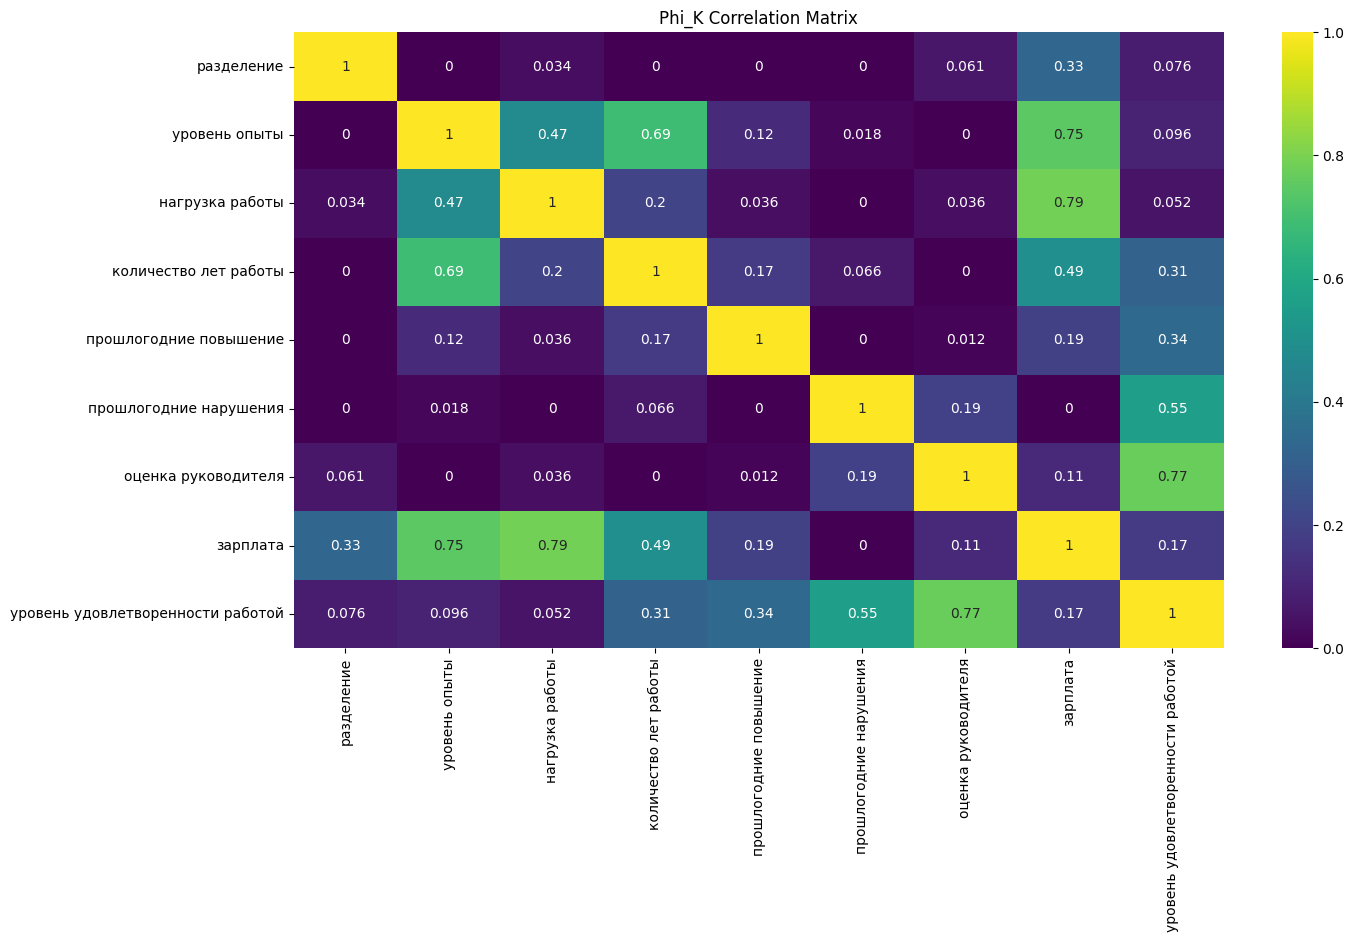

In [53]:
# Вычисляем матрицу корреляции с использованием phik
corr_matrix_test = df_sat_test.phik_matrix(interval_cols=interval_cols)

cols_name = ['разделение', 'уровень опыты', 'нагрузка работы', 'количество лет работы', \
             'прошлогодние повышение', 'прошлогодние нарушения', 'оценка руководителя', 'зарплата', \
            'уровень удовлетворенности работой']

# Визуализация матрицы 
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix_test, 
            xticklabels=cols_name,
            yticklabels=cols_name,
            annot=True, 
            cmap='viridis');
plt.title('Phi_K Correlation Matrix')
plt.show()

Корреляционная матрица для тестовой выборки очень похожа на тренировочную. Зарплаты особенно зависят от уровня опыта, нагрузки работы, и количества лет работы. Заметим среднюю корреляцию между количеством работы с уровенем опыта и нагрузской работы со уровень опыта. У нас нет ни большой корреляции, ни коллинеарности между нашими признаками.

## Пайплайн

Мы должны были решить проблему регрессии и для этого мы исползовали пайплайн. Для пайплайн мы использовали:
- SimpleImputer чтобы заменить пропуски с наиболее частыми значениями
- OneHotEncoder для столбцов: 'last_year_promo', 'last_year_violations', и 'dept'
- OrdinalEncoder для 'level', 'workload', где есть иерархические порядки,
- три разных скалера для масштабирования:
    - StandardScaler(), 
    - MinMaxScaler() 
    - RobustScaler(),
- метод численной оптимизации - RandomizedSearchCV, где мы передаем 4 разные модели машинного обучения с разными параметрами. Эти модели:   
    - DecisionTreeRegressor
    - KNeighborsRegressor
    - SVR
    - LinearRegression
    - XGboostRegressor 
    
Отметим что для дерева решений все категории со строками значений были кодированны с OrdinalEncoder() кроме значения из столбцов'dept'.
Затем мы использовали оценку sMAPE которую мы настроили, чтобы выбрать лучшую модель. 
В завершение мы сортировали различные интересные метрики для модели, а также отчет RandomizeSearchCV.

Во первых мы одельно расситали метрики sMAPE соглано формуле ниже:
$$
  sMAPE = \frac{100}{n}\sum_{i=1}^{n}2\frac{|y_{i}-\hat{y}_{i}|}{|y_{i}|+|\hat{y}_{i}|} 
$$

где:

$y_i$ — фактическое значение целевого признака для объекта с порядковым номером $i$ в выборке;

$\hat{y}_{i}$  — предсказанное значение целевого признака для объекта с порядковым номером $i$ в выборке;

$n$ — количество объектов в выборке;

$\sum_{i=1}^{n}$ — сумма значений, полученная в результате операций, которые следуют за этим знаком, для всех объектов с порядковым номером от $i$ до $n$ в выборке.

In [54]:
# sMAPE score
def smape_scorer(y_true, y_pred):
    smape = (100)/len(y_true)*(2*abs(y_true-y_pred)/(abs(y_true)+abs(y_pred))).sum()
    return smape

smape_score = make_scorer(smape_scorer, greater_is_better=False)

In [55]:
df_sat.duplicated().sum()

245

In [56]:
df_sat.drop_duplicates(inplace=True)

In [57]:
df_sat.duplicated().sum()

0

Убрали дуплиаты.

In [58]:
# Разделяем целовой признак из других признаков в df_sat
X = df_sat.drop('job_satisfaction_rate', axis=1)
y = df_sat['job_satisfaction_rate']

In [59]:
# создаём списки с названиями признаков
enc_columns = ['last_year_promo', 'last_year_violations']
enc_2_columns = ['dept']
ord_columns = ['level', 'workload']
num_columns = X.select_dtypes(include='number').columns.to_list()

print(f'У нас все столбце --> {len(enc_columns+enc_2_columns+ord_columns+num_columns)==len(X.columns)}.')

# создаём пайплайн для категорильного значения

ohe_pipe_2 = Pipeline([
    ('imp_1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe_2', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
])

У нас все столбце --> True.


In [60]:
ord_pipe = Pipeline([
    ('imp_2', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord_1', OrdinalEncoder(categories=[
         ['junior', 'middle', 'senior'],
         ['low', 'medium', 'high'],]))
])


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe_1', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), enc_columns),
     ('ohe_2', ohe_pipe_2, enc_2_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [61]:
RANDOM_STATE=42
param_grid = [
     # словарь для модели LinearRegression
    {
        'models': [LinearRegression()]

    },
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__max_features': range(2,14),
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  

   },
    
    # словарь для модели KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
   },
  
    # словарь для модели SVR()
    {
        'models':[SVR()],
        'models__C': [0.1, 1, 10, 100, 1000],  
        'models__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
        
   },
    
     # словарь для модели XGboostRegressor
    {
        'models':[XGBRegressor(random_state=RANDOM_STATE)],
        'models__min_child_weight': [1, 5, 10, 12],
        'models__gamma': [0.5, 1, 1.5, 2, 5, 10, 12], 
        'models__subsample': [0.6, 0.8, 1.0], 
        'models__colsample_bytree': [0.6, 0.8, 1.0], 
        'models__subsample': [0.6, 0.8, 1.0], 
        'models__max_depth': range(0,15),
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
        
      },
    
    # словарь для модели RandomForestRegressor()
    {
        'models':[RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80],
        'models__max_features': range(2,14),
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__bootstrap': [True, False],
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]       
      }
 ]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    error_score="raise",
    n_jobs=-1
)

randomized_search.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe_1',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ohe_2',
                                                                               Pipeline(steps=[('imp_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe_2'...
                                         'models__max_features': range(2, 14),
                                         'models__min_samples_leaf': range(1, 14),
                                         'models__min_samples_split': range(2, 14),
                                         'models__n_estimators': [10, 17, 25,
                                                                  33, 41, 48,
                                                                  56, 64, 72,
                                                                  80],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()],
                                         'preprocessor__ohe_1': [OrdinalEncoder()]}],
                   random_state=42,
                   scoring=make_scorer(smape_scorer, greater_is_better=False, response_method='predict'))

In [62]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', np.abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                        

In [63]:
# Итог гиперпараметр тюнинг
report_randomised_search = pd.DataFrame(randomized_search.cv_results_) 
pd.set_option('display.max_colwidth', None)
report_randomised_search.sort_values('rank_test_score', ascending=True)[['param_preprocessor__num', \
                                                                         #'param_preprocessor__ohe_1', \
                                                                         #'param_preprocessor__ohe_2', \
                                                                         'param_models', 'params', \
                                                                         'mean_test_score', 'std_test_score', \
                                                                         'rank_test_score']].head(3)

param_preprocessor__num                            param_models  \
3        StandardScaler()  RandomForestRegressor(random_state=42)   
1        StandardScaler()  RandomForestRegressor(random_state=42)   
6          RobustScaler()  RandomForestRegressor(random_state=42)   

                                                                                                                                                                                                                                                                                                           params  \
3  {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': StandardScaler(), 'models__n_estimators': 41, 'models__min_samples_split': 6, 'models__min_samples_leaf': 5, 'models__max_features': 11, 'models__max_depth': 13, 'models__bootstrap': False, 'models': RandomForestRegressor(random_state=42)}   
1   {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': StandardScaler(), 'models__n_estimators': 17, 'models__min_samples_split': 11, 'models__min_samples_leaf': 7, 'models__max_features': 8, 'models__max_depth': 12, 'models__bootstrap': True, 'models': RandomForestRegressor(random_state=42)}   
6      {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': RobustScaler(), 'models__n_estimators': 25, 'models__min_samples_split': 5, 'models__min_samples_leaf': 8, 'models__max_features': 9, 'models__max_depth': 13, 'models__bootstrap': True, 'models': RandomForestRegressor(random_state=42)}   

   mean_test_score  std_test_score  rank_test_score  
3       -15.580863        0.483576                1  
1       -15.603607        0.779338                2  
6       -15.699297        0.759305                3

### Самая лучшая модел первой кросс-валидацци

In [64]:
# лучшая модель
model = randomized_search.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_1',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']]))]),
                                                  ['level', 'workload']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 RandomForestRegressor(bootstrap=False, max_depth=13,
                                       max_features=11, min_samples_leaf=5,
                                       min_samples_split=6, n_estimators=41,
                                       random_state=42))])

Самой лучшей моделью является - RandomForestRegressor(bootstrap=False, max_depth=13, max_features=11, min_samples_leaf=5, min_samples_split=6, n_estimators=41, random_state=42). Метрик SMAPE не плохой 15,2. У нас знак - из-за того чтобы мы исползовали аттрибют greater_is_better=False, но нужно взать абсолютное значение метрики.

## Анализ важности признаков

                       Features  Importance
3        ohe_2__dept_purchasing    0.002335
5        ohe_2__dept_technology    0.008765
2         ohe_2__dept_marketing    0.009408
0        ohe_1__last_year_promo    0.010902
4             ohe_2__dept_sales    0.014252
7                 ord__workload    0.018993
6                    ord__level    0.048180
1   ohe_1__last_year_violations    0.055364
8         num__employment_years    0.073033
10                  num__salary    0.074960
9    num__supervisor_evaluation    0.683808


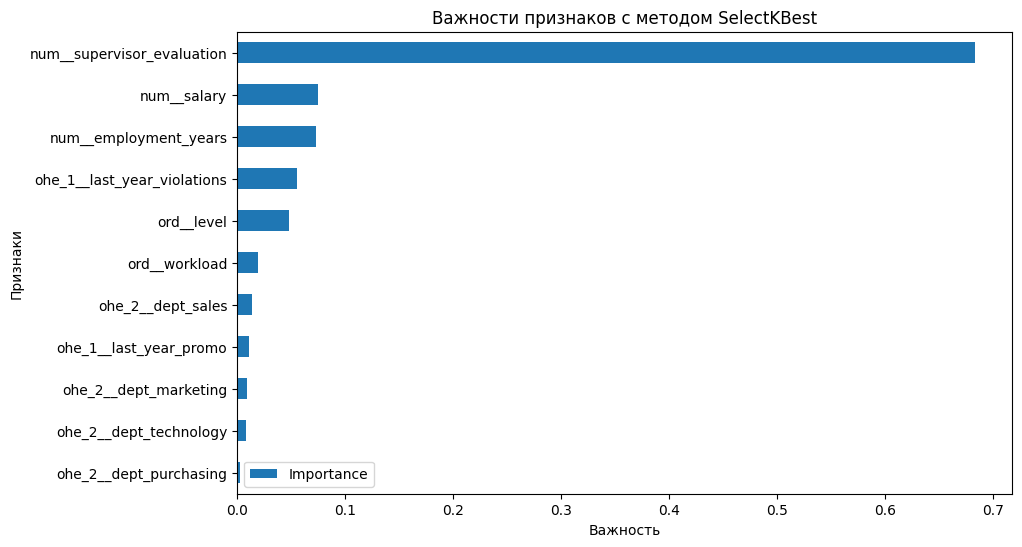

In [65]:
# инициализируем все нужные классы для работы модели
selector = SelectKBest(f_classif, k=11)

# создаём 
data_preprocessor_1 = ColumnTransformer(
    [('ohe_1', OrdinalEncoder(), enc_columns),
     ('ohe_2', ohe_pipe_2, enc_2_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

shap_X = data_preprocessor_1.fit_transform(X)
shap_X_test = data_preprocessor_1.transform(X_test)
shap_column_names = data_preprocessor_1.get_feature_names_out()
shap_X = pd.DataFrame(shap_X, columns = shap_column_names)
shap_X_test = pd.DataFrame(shap_X_test, columns = shap_column_names)

# обучаем SelectKBest
selector.fit(shap_X, y)

# формируем выборки с лучшими признаками
features_names = shap_X.columns[selector.get_support(indices=True)]
X_new = shap_X[list(features_names)]
X_test_new = shap_X_test[list(features_names)]

model_inf = RandomForestRegressor(bootstrap=False, max_depth=13,max_features=11, min_samples_leaf=5, \
                                  min_samples_split=6, n_estimators=41, random_state=42)


# обучаем модель на лучших признаках
model_inf.fit(X_new, y)


# отложим значения коэффициентов на графике
coefficients = model_inf.feature_importances_
features_importance = pd.DataFrame({'Features': features_names, 'Importance': np.abs(coefficients)})
features_importance = features_importance.sort_values('Importance',ascending=True)
print(features_importance)
plot_features_importance = features_importance.plot(x='Features', \
                                                    y='Importance',\
                                                    kind='barh', figsize=(10, 6));
plt.title('Важности признаков с методом SelectKBest'),
plt.xlabel('Важность'); 
plt.ylabel('Признаки'); 

С методом SKbest есть 1 очень важный признак, в порядке важности:

- оценка руковадителя

Есть 5 слабо влияющих признака, в порядке значимости:

- годы работы
- зарплата
- прошлогоднее нарушение
- уровень опыта
- нагрузка работы
- отделы,  разделенные на 5 частей, если добавляем их понимаем что они важны на уровне важности нагрузки работы  

Есть 1 почти не влияющий признак, в порядке важности: выход:

- прошлогоднее повышение

In [66]:
y_test.columns

Index(['job_satisfaction_rate'], dtype='object')

In [67]:
result = permutation_importance(model_inf, X_test_new, y_test['job_satisfaction_rate'], scoring=smape_score)

features_importance_permutation = pd.DataFrame({'Features': features_names, \
                                                'Importance': np.abs(result['importances_mean'])})
features_importance_permutation = features_importance_permutation.sort_values('Importance', ascending=True)
print(features_importance_permutation)
plot_feature_importance_permutation = features_importance_permutation.plot(x='Features', y='Importance', \
                                                                           kind='barh', figsize=(10, 6)); 

plt.title('Важности признаков с методом permutation importance'),
plt.xlabel('Важность'); 
plt.ylabel('Признаки'); 

                       Features  Importance
3        ohe_2__dept_purchasing    0.122168
0        ohe_1__last_year_promo    0.463635
2         ohe_2__dept_marketing    0.466472
5        ohe_2__dept_technology    1.722191
4             ohe_2__dept_sales    1.893391
7                 ord__workload    4.810370
1   ohe_1__last_year_violations    4.971512
6                    ord__level    8.464430
10                  num__salary    9.273487
8         num__employment_years   10.941389
9    num__supervisor_evaluation   25.689312


Если исползуем оценку SMAPE видим что оценка руковадителя менее важна и осталные признаки более важны чем были. Однако получаем  одие и тоже порядок по важности как с SKBest, единсвенная разница это что уровень опыты более важен чем прошлогоднее нарушение. Порядок важности - :

Есть 1 очень важный признак в порядке важности:

- оценка руковадителя

Есть 5 слабо влияющих признака, в порядке значимости:

- годы работы
- зарплата
- уровень опыты
- прошлогоднее нарушение
- нагрузка работы
- отделы,  разделенные на 5 частей, если добавляем их понимаем что они важны на уровне важности нагрузки работы

Есть 1 почти не влияющих признака, в порядке важности: выход:

- прошлогоднее повышение

## Вторая кросс-валидация 

Пытаемся улучшить качество модели устраняя самые не влияющие признаки - 'last_year_promo'. У другых признаков сличком высокая важность.

In [68]:
# Разделяем целовой признак из других признаков в df_sat
X_1 = df_sat.drop(['job_satisfaction_rate', 'last_year_promo'], axis=1)
y_1 = df_sat['job_satisfaction_rate']

In [69]:
# создаём списки с названиями признаков
enc_columns_1 = ['last_year_violations']
enc_2_columns_1 = ['dept']
ord_columns_1 = ['level', 'workload']
num_columns_1 = X_1.select_dtypes(include='number').columns.to_list()

# создаём пайплайн для категорильнго значения

ohe_pipe_2 = Pipeline([
    ('imp_1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe_2', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

ord_pipe = Pipeline([
    ('imp_2', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord_1', OrdinalEncoder(categories=[
         ['junior', 'middle', 'senior'],
         ['low', 'medium', 'high'],]))
])


# создаём общий пайплайн для подготовки данных
data_preprocessor_1 = ColumnTransformer(
    [('ohe_1', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), enc_columns_1),
     ('ohe_2', ohe_pipe_2, enc_2_columns_1),
     ('ord', ord_pipe, ord_columns_1),
     ('num', MinMaxScaler(), num_columns_1)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor_1),
    ('models', LinearRegression())
])

param_grid_1 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__max_features': range(2,14),
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  

    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
   },
  
    # словарь для модели SVC()
    {
        'models':[SVR()],
        'models__C': [0.1, 1, 10, 100, 1000],  
        'models__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
        
   },
    
        # словарь для модели XGboostRegressor
    {
        'models':[XGBRegressor(random_state=RANDOM_STATE)],
        'models__min_child_weight': [1, 5, 10, 12],
        'models__gamma': [0.5, 1, 1.5, 2, 5, 10, 12], 
        'models__subsample': [0.6, 0.8, 1.0], 
        'models__colsample_bytree': [0.6, 0.8, 1.0], 
        'models__subsample': [0.6, 0.8, 1.0], 
        'models__max_depth': range(0,15),
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
        
      },
    
        # словарь для модели RandomForestRegressor()
    {
        'models':[RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80],
        'models__max_features': range(2,14),
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__bootstrap': [True, False],
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]       
      }
 ]

randomized_search_1 = RandomizedSearchCV(
    pipe_final_1, 
    param_grid_1, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    error_score="raise",
    n_jobs=-1
)
randomized_search_1.fit(X_1, y_1)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe_1',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['last_year_violations']),
                                                                              ('ohe_2',
                                                                               Pipeline(steps=[('imp_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe_2',
                                                                                                OneHotEncoder(han...
                                         'models__max_features': range(2, 14),
                                         'models__min_samples_leaf': range(1, 14),
                                         'models__min_samples_split': range(2, 14),
                                         'models__n_estimators': [10, 17, 25,
                                                                  33, 41, 48,
                                                                  56, 64, 72,
                                                                  80],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()],
                                         'preprocessor__ohe_1': [OrdinalEncoder()]}],
                   random_state=42,
                   scoring=make_scorer(smape_scorer, greater_is_better=False, response_method='predict'))

### Самая лучшая модел второй кросс-валидацци

In [70]:
print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_1.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_violations']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('imp

In [71]:
# самая лучшая модел
model_1 = randomized_search_1.best_estimator_
model_1.fit(X_1, y_1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_violations']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('imp_2',
                                                                   SimpleImputer(strategy...)),
                                                                  ('ord_1',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']]))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 RandomForestRegressor(bootstrap=False, max_depth=13,
                                       max_features=11, min_samples_leaf=5,
                                       min_samples_split=6, n_estimators=41,
                                       random_state=42))])

### Сравнение метрики sMAPE

In [72]:
comparison_dict = {
    'кросс-валидация': ['кросс-валидация 1', 'кросс-валидация 2'],
    'models': [randomized_search.best_params_, randomized_search_1.best_params_],
    'roc_auc' : [np.abs(randomized_search.best_score_), np.abs(randomized_search_1.best_score_)]    
}
pd.DataFrame(comparison_dict).set_index('кросс-валидация')

models  \
кросс-валидация                                                                                                                                                                                                                                                                                                                     
кросс-валидация 1  {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': StandardScaler(), 'models__n_estimators': 41, 'models__min_samples_split': 6, 'models__min_samples_leaf': 5, 'models__max_features': 11, 'models__max_depth': 13, 'models__bootstrap': False, 'models': RandomForestRegressor(random_state=42)}   
кросс-валидация 2    {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 41, 'models__min_samples_split': 6, 'models__min_samples_leaf': 5, 'models__max_features': 11, 'models__max_depth': 13, 'models__bootstrap': False, 'models': RandomForestRegressor(random_state=42)}   

                     roc_auc  
кросс-валидация               
кросс-валидация 1  15.580863  
кросс-валидация 2  15.886256

Самая лучшая модел из первы кросс-валидации.

 ### Самая лучшая модель

In [73]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_1',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']]))]),
                                                  ['level', 'workload']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 RandomForestRegressor(bootstrap=False, max_depth=13,
                                       max_features=11, min_samples_leaf=5,
                                       min_samples_split=6, n_estimators=41,
                                       random_state=42))])

### Тестовая выборка

In [74]:
# Обучаем модел
model.fit(X, y)
# Наше предзананы целовой признак
y_test_pred = model.predict(X_test)

In [75]:
# проведем анализ остатков
# перед этим рассчитаем остатки

residuals = y_test['job_satisfaction_rate'] - y_test_pred
# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(data=residuals, bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].grid()

# диаграмму рассеяния
sns.scatterplot(x=y_test_pred,y=residuals, color='skyblue', ax=axes[1])
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

In [76]:
# метрики на валидационны выборке
r2 = r2_score(y_test, y_test_pred)
print(f'r2 = {r2:.2f}')

r2 = 0.88


In [77]:
y_test_1 = y_test['job_satisfaction_rate']
smape_res = smape_score(model, X_test, y_test_1)
print(f'SMAPE = {np.abs(smape_res):.2f}')

SMAPE = 13.68


На тестовой метрике мы получили резултат который мы хотели: $$SMAPE<=15$$.

### DummyRegressor

In [78]:
# dummy regressor с strategy mean
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X, y) 
y_predict_dummy_mean = lm_dummy_mean.predict(X_test) 

In [79]:
# целовое пизнак из тестовой выборке
y_test_dummy = y_test['job_satisfaction_rate']

# оценка sMAPE
print(f'sMAPE на dummy  = {np.abs(smape_score(lm_dummy_mean, X_test, y_test_dummy)):.2f}')

# оценка R2
print("r2_score на dummy: {:.2f}".format(r2_score(y_test_dummy, y_predict_dummy_mean)))

sMAPE на dummy  = 38.26
r2_score на dummy: -0.01


У нас намного хуже качетсво  метрику sMAPE с dummy regressor.

## Вывод

 Наша лучшая модель:


In [80]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_1',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']]))]),
                                                  ['level', 'workload']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 RandomForestRegressor(bootstrap=False, max_depth=13,
                                       max_features=11, min_samples_leaf=5,
                                       min_samples_split=6, n_estimators=41,
                                       random_state=42))])

Модель которая лучше справляется это случайные леса из за того что болшинство принаков - категоряльные значения. 

# Часть II

## Загрузка данных

### Данные с характеристиками сотрудников компании (тренировочная выборка):

In [81]:
df_quit = pd.read_csv('./train_quit.csv')
df_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

In [82]:
df_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


У нас те же признаки как в первой части. Нет пропусков в этот раз. Более того, все значенния в корректном типе, числа в числовом формате и строки как тип object. 
Здесь тоже 4000 сотрудников.

### Данные с характеристиками сотрудников компании (тестовая выборка):

In [83]:
X_test_quit = pd.read_csv('./test_features.csv')
X_test_quit.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [84]:
X_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Здесь датафрейм содержит те же признаки кроме целового признака - 'quit'. Все значения в корректном типе, числа в числовом формате и стоки как тип object. Отметим 3 пропуска, 2 в 'dept' и 1 в 'level'.

### Целевой признак тестовой выборки:

In [85]:
y_test_quit = pd.read_csv('./test_target_quit.csv')
y_test_quit.head()

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

In [86]:
y_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Датафрейм с целовым признаком - 'quit'. Он содержит 2000 строк как у датафрейм тестовой выборки X_test_quit cо входными признаками.
Отметим что нет пропусков в этом датафрейме.

## Предобработка данных

### Пропуски в датасетах

Заметили 3 пропуска в датафрейме X_test которые мы будем зарабатывать с помошю SimpleImputer, с аттрибутом strategy: 'most_frequent'.

### Дупликаты

In [87]:
def find_obvious_duplicates(dataframe):
    return dataframe.duplicated().sum()
    
dataframes = [df_quit, X_test_quit, y_test_quit]
dataframes_names = ['df_quit', 'X_test_quit', 'y_test_quit']

for index, dataframe in enumerate(dataframes):
    res = find_obvious_duplicates(dataframe)
    print(f'{res} явны дупликаты в датафрейме {dataframes_names[index]}')

0 явны дупликаты в датафрейме df_quit
0 явны дупликаты в датафрейме X_test_quit
0 явны дупликаты в датафрейме y_test_quit


#### Столбец 'id' точно содержит уникальное значение  ?

In [88]:
def check_duplicates_id(dataframe):
    return dataframe.duplicated(subset='id').sum()
    
dataframes = [df_quit, X_test_quit, y_test_quit]
dataframes_names = ['df_quit', 'X_test_quit', 'y_test_quit']

for index, dataframe in enumerate(dataframes):
    res = check_duplicates_id(dataframe)
    print(f'{res} дупликаты в столбце \'id\' в датафрейме {dataframes_names[index]}')

0 дупликаты в столбце 'id' в датафрейме df_quit
0 дупликаты в столбце 'id' в датафрейме X_test_quit
0 дупликаты в столбце 'id' в датафрейме y_test_quit


Значение в 'id' точно уникальное.

#### Проверка присутствия дупликатов в других столбцах

In [89]:
# Список категоряльных столбцов
col_cat = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

# Список датафрейм
dataframes = [df_quit, X_test_quit]
# Список имен датафрейм
dataframes_names = ['df_quit', 'X_test']

#  Создаем пустой лист для соханиения резултата
list_unique = []

for dataframe in dataframes:
    list_unique_cat = {}
    
    for col in col_cat:
        if col in dataframe.columns:
            list_unique_cat[col] = dataframe[col].unique().tolist() 
    list_unique.append(list_unique_cat)
list_unique

[{'dept': ['sales', 'purchasing', 'marketing', 'technology', 'hr'],
  'level': ['middle', 'junior', 'sinior'],
  'workload': ['high', 'medium', 'low'],
  'last_year_promo': ['no', 'yes'],
  'last_year_violations': ['no', 'yes']},
 {'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
  'level': ['junior', 'middle', 'sinior', nan],
  'workload': ['medium', 'low', 'high', ' '],
  'last_year_promo': ['no', 'yes'],
  'last_year_violations': ['no', 'yes']}]

Замечаем что есть некоторые пустые значения ' ' которые мы будем заменять NaN значением. Заменияем тоже слово 'sinior' правильным словом 'senior'. Эту ошибку не обязательно исправлять,просто мне она мешает 

In [90]:
df_quit['level'].replace('sinior', 'senior', inplace=True)
df_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [91]:
X_test_quit['level'].replace('sinior', 'senior', inplace=True)
X_test_quit['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [92]:
X_test_quit['dept'].replace(' ', np.nan, inplace=True)
X_test_quit['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [93]:
X_test_quit['workload'].replace(' ', np.nan, inplace=True)
X_test_quit['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

#### Проверка пересечения

In [94]:
inter_X_y_test = set(X_test_quit['id']) & set(y_test_quit['id'])
len(inter_X_y_test)

2000

У этих 2 датафрейм X_test_quit и - y_test_quit одни и те же индексы

In [95]:
inter_X_train_X_test = set(X_test_quit['id']) & set(df_quit['id'])
len(inter_X_train_X_test)

0

df_quit и X_test_quit не имеют общего индекса.

In [96]:
inter_job_quit = set(df_quit['id']) & set(df_quit['id'])
len(inter_job_quit)

4000

 Значение в 'id' разние в этих датафреймах.

Важно проверить такие веши что бы не было утечка данных.

### Переиндексация

Втавим 'id' как индекс во все датафремах.

In [97]:
df_quit.set_index('id', inplace=True)
df_quit.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
723290                   no                      4   54000   no  
814010                   no                      4   27600   no  
155091                   no                      1   37200   no  
257132                  yes                      3   24000  yes  
910140                   no                      5   25200   no

In [98]:
X_test_quit.set_index('id', inplace=True)
X_test_quit.head()

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
485046                   no                      5   28800  
686555                   no                      4   30000  
467458                   no                      4   19200  
418655                   no                      4   19200  
789145                   no                      5   40800

In [99]:
y_test_quit.set_index('id', inplace=True)
y_test_quit.head()

quit
id         
999029  yes
372846   no
726767   no
490105   no
416898  yes

In [100]:
y_test_quit = y_test_quit.reindex(X_test_quit.index)
y_test_quit.head()

quit
id         
485046   no
686555   no
467458   no
418655   no
789145   no

y_test_1.isna().sum()

Мы не создали пропусков с методом reindex.

### Вывод

Обнаружили  толко 3 пропуска в тестовой датафрейму X_test_quit.Эти пропуски мы исправим во время установки пайплайн. 
Отметили пустые значения в тестовой выборке которые мы заменили зачением NaN в сотлбцах 'dept' и 'level', что бы они были отработаны во время пайплайн. 
Проверили что индекс был уникальны в тренировочное выборке и тестовой. Переиндексировал индекс из датафрейм целовым признаком что бы они совпадали с тестовой датафрейм со входнями признаками.

## Исследовательский анализ данных

### Статистика датафреймы

In [101]:
df_quit.describe()

employment_years  supervisor_evaluation        salary
count       4000.000000            4000.000000   4000.000000
mean           3.701500               3.474750  33805.800000
std            2.541852               1.004049  15152.415163
min            1.000000               1.000000  12000.000000
25%            2.000000               3.000000  22800.000000
50%            3.000000               4.000000  30000.000000
75%            6.000000               4.000000  43200.000000
max           10.000000               5.000000  96000.000000

In [102]:
df_sat.describe()

employment_years  supervisor_evaluation        salary  \
count       3755.000000            3755.000000   3755.000000   
mean           3.817044               3.463648  34457.416778   
std            2.557142               1.026265  15050.643870   
min            1.000000               1.000000  12000.000000   
25%            2.000000               3.000000  22800.000000   
50%            3.000000               4.000000  31200.000000   
75%            6.000000               4.000000  44400.000000   
max           10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            3755.000000  
mean                0.532554  
std                 0.226393  
min                 0.030000  
25%                 0.350000  
50%                 0.550000  
75%                 0.710000  
max                 1.000000

In [103]:
col_num = df_quit.select_dtypes(exclude='object').columns.to_list()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 7.5))

axes = axes.flatten()

columns_names = ['employment_years', 'supervisor_evaluation', 'salary']

for i, column in enumerate(df_quit[col_num].columns):
    
    sns.boxplot(data=df_quit, x=column, color='palegreen', ax=axes[i]) 
    
    axes[i].set_title(f'Ящик с усами {columns_names[i]}') 

plt.title('Боксплот для тренирочной датафрейм');
plt.tight_layout()


plt.show()

По статистике df_sat и df_quit очень похожи.

### Исследованние распеделенние количество значение

#### Распеделенние employment_years

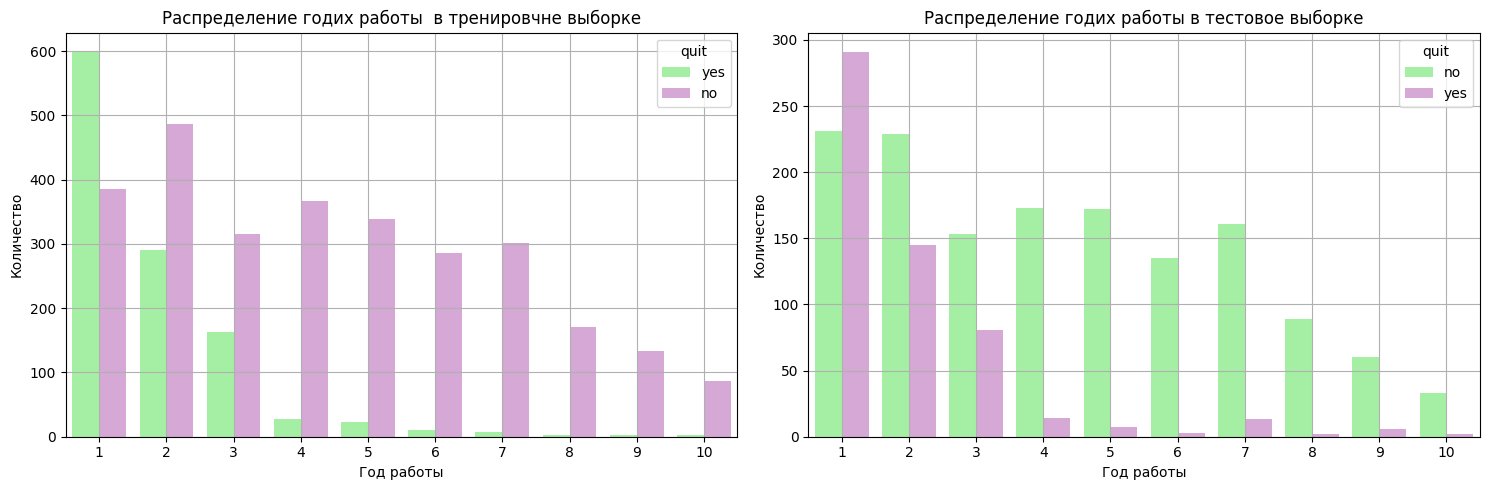

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_quit, X_test_quit]

sample_type = [' в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):

    if i == 0:
        dataframe_2 = dataframe
    else:
        dataframe_2 = y_test_quit
        
    sns.countplot(x=dataframe['employment_years'], hue=dataframe_2['quit'], \
                 palette = ['palegreen' , 'plum'], ax=axes[i]);

    axes[i].set_title(f'Распределение годих работы {sample_type[i]}') 
    
    axes[i].set_xlabel('Год работы');
    axes[i].set_ylabel('Количество');
    axes[i].grid();
        

plt.tight_layout()


plt.show()

In [105]:
df_quit['employment_years'].describe()

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

У нас одно и то-же рапределение как в первой части. Распределение данных в тестовой выборке почти такие же как и у тренировочной. Однако в этот раз можно определить характеристик поведения ушедших и неушедших сотрудников. Заметим что те которые увольняются почти не остаються работать болшее 4 лет.

#### Распеделенние оценки руководителя

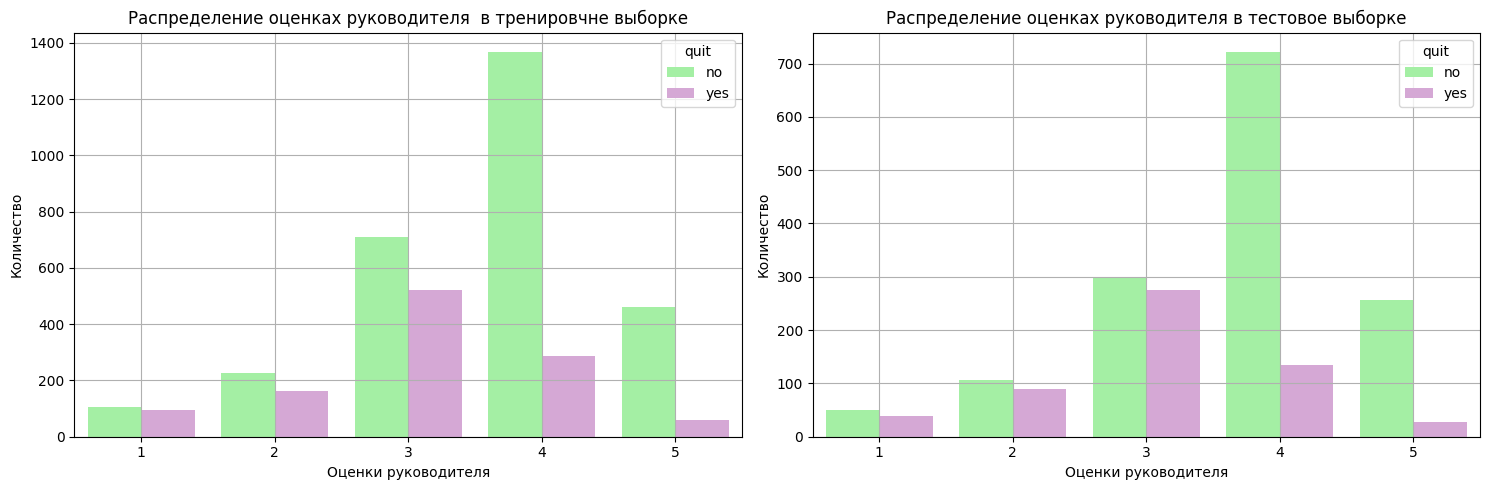

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_quit, X_test_quit]

sample_type = [' в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):
    
    if i == 0:
        dataframe_2 = dataframe
    else:
        dataframe_2 = y_test_quit

    sns.countplot(x=dataframe['supervisor_evaluation'], hue=dataframe_2['quit'], \
                 palette = ['palegreen' , 'plum'], ax=axes[i]);

    axes[i].set_title(f'Распределение оценках руководителя {sample_type[i]}') 
    
    axes[i].set_xlabel('Оценки руководителя');
    axes[i].set_ylabel('Количество');
    axes[i].grid();
        

plt.tight_layout()


plt.show()

In [107]:
df_quit.query('quit == "yes"')['supervisor_evaluation'].describe()

count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [108]:
df_quit.query('quit == "no"')['supervisor_evaluation'].describe()

count    2872.000000
mean        3.643106
std         0.965295
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Здесь видим как похожи df_sat и df_quit, так же df_quit со тестовой. Однако мы видим что у ушедших сотрудников, хуже оценка, намного меншее из них получают 4 или 5. Значит, что если у них плохая оценка, компания можеть быть не хотет их удержать, или они не чуствуют себя на своем месте вот почему плохая оценка и почему они уходят. Если смотрим на медиану видим что те которые ушли получили на 1 очко меньше чем другой класс, Можно подумать что вообщее ушедшие сотрудники получают менее хорошие оценки.

#### Распеделенние зарплат

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_quit, X_test_quit]

sample_type = [' в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):
    
    if i == 0:
        dataframe_2 = dataframe
    else:
        dataframe_2 = y_test_quit

    sns.histplot(x=dataframe['salary'],  hue=dataframe_2['quit'], stat='density', common_norm=False, \
                 palette = ['palegreen' , 'plum'], ax=axes[i]);

    axes[i].set_title(f'Распределение зарплаты {sample_type[i]}') 
    
    axes[i].set_xlabel('Зарплаты');
    axes[i].set_ylabel('Плотность распределения');
    axes[i].grid();
        

plt.tight_layout()


plt.show()

In [110]:
df_quit.query('quit == "yes"')['salary'].describe([0.25, 0.5, 0.75, 0.90])

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
90%      34800.000000
max      79200.000000
Name: salary, dtype: float64

In [111]:
df_quit.query('quit == "no"')['salary'].describe()

count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

Здесь тоже датафреймы из обоих части почти одинаковые. Заметим тоже что самые минимальные зарплаты- у сотрудников которые ушли. 90 % ушедших сотрудников - зарплата меншее 34800. 50% неушедших сотрудников получают болшее 34800. Вообще ушедшие сотрудники получают меньше. Может быть они не достотечно догло работают в этот компани что бы получають больше, они не достаточно долго работают потому не достаточно хороши для компании.

### Исследованние распеделенние категорялное значение

#### Распеделенние разделение

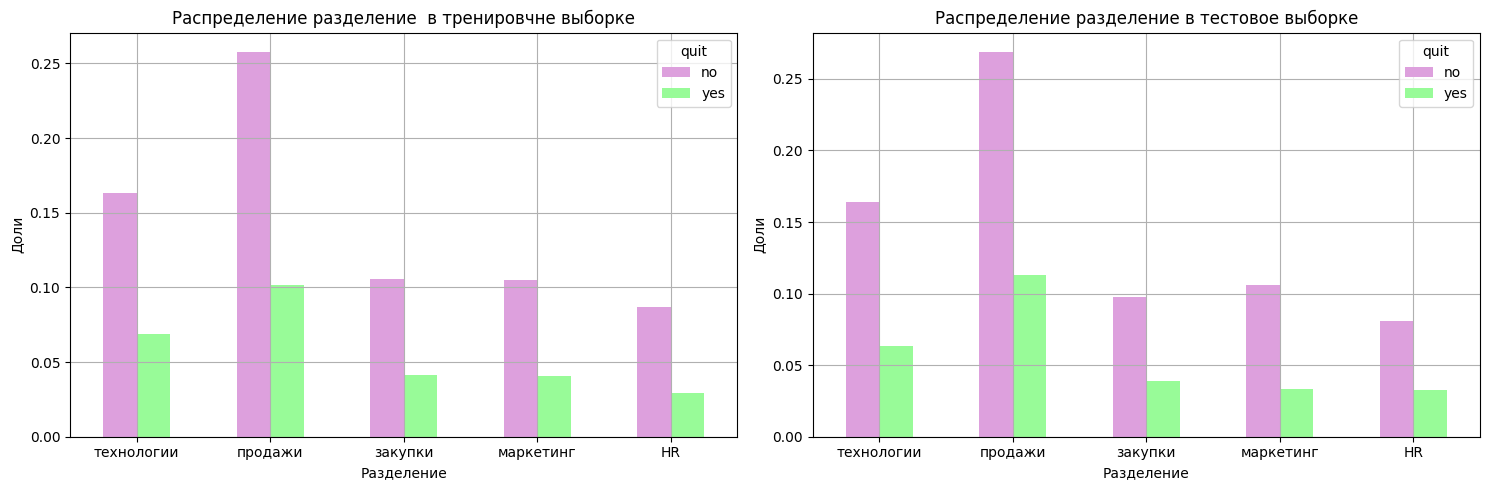

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_quit, X_test_quit]

sample_type = [' в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):
    
    if i == 0:
        dataframe_2 = dataframe
    else:
        dataframe_2 = y_test_quit

    
    pd.crosstab(dataframe['dept'], dataframe_2['quit'], normalize=True).sort_values(by='dept', ascending=False)\
    .plot.bar(color=['plum', 'palegreen'], figsize=(15,5), ax=axes[i]);

    axes[i].set_title(f'Распределение разделение {sample_type[i]}');
    
    axes[i].set_xlabel('Разделение');
    axes[i].set_ylabel('Доли');
    #axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();
axes[0].set_xticklabels(['технологии', 'продажи', 'закупки', 'маркетинг', 'HR'], rotation=0)
axes[1].set_xticklabels(['технологии', 'продажи', 'закупки', 'маркетинг', 'HR'], rotation=0)

plt.tight_layout()


plt.show()

In [113]:
pd.crosstab(dataframe['dept'], dataframe_2['quit'], normalize=True)

quit              no       yes
dept                          
hr          0.081122  0.032549
marketing   0.106159  0.033550
purchasing  0.097646  0.039059
sales       0.268903  0.113170
technology  0.164246  0.063595

Здесь распределение похоже между тренировочной и тестовой, и между первой и второй частью. Сотрудники обоих классов распределяются по отделам одинаково.

#### Распеделенние уровены опыты

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_quit, X_test_quit]

sample_type = [' в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):
    
    if i == 0:
        dataframe_2 = dataframe
    else:
        dataframe_2 = y_test_quit

    
    pd.crosstab(dataframe['level'], dataframe_2['quit'], normalize=True)\
    .plot.bar(color=['plum', 'palegreen'], figsize=(15,5), ax=axes[i]);

    axes[i].set_title(f'Распределение уровены опыты {sample_type[i]}');
    
    axes[i].set_xlabel('Уровены опыты');
    axes[i].set_ylabel('Доли');
    axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();

axes[0].set_xticklabels(['новичок', 'средний', 'старший'], rotation=0)
axes[1].set_xticklabels(['новичок', 'средний', 'старший'], rotation=0)

plt.tight_layout()


plt.show()

In [115]:
df_quit_xp = pd.crosstab(df_quit['level'], df_quit['quit'])
df_quit_xp

quit      no   yes
level             
junior   946  1003
middle  1586   108
senior   340    17

In [116]:
df_quit_xp.loc['junior', 'yes']/df_quit_xp['yes'].sum()

0.8891843971631206

Мы видим что у болшинства ушедших сотрудников мало опыта, они принадлежат младшим категориям. Эти людей не достаточно оставаиваются по какой-то причино, либо им не подходит компания или просто работа там не понравилось.82% увольняющихся сотрудников имеют «новичок» уровень.

#### Распеделенние нагрузка работы

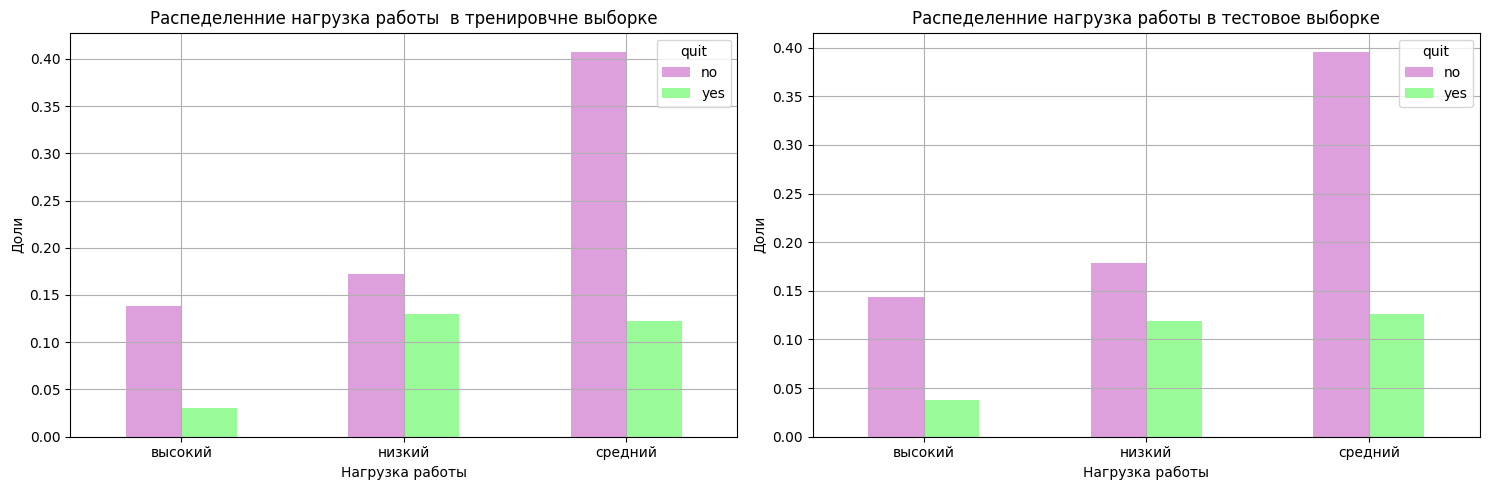

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_quit, X_test_quit]

sample_type = [' в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):
    
    if i == 0:
        dataframe_2 = dataframe
    else:
        dataframe_2 = y_test_quit

    pd.crosstab(dataframe['workload'], dataframe_2['quit'], normalize=True)\
    .plot.bar(color=['plum', 'palegreen'], figsize=(15,5), ax=axes[i]);

    axes[i].set_title(f'Распеделенние нагрузка работы {sample_type[i]}');
    
    axes[i].set_xlabel('Нагрузка работы');
    axes[i].set_ylabel('Доли');
    axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();

axes[0].set_xticklabels(['высокий', 'низкий', 'средний'], rotation=0)
axes[1].set_xticklabels(['высокий', 'низкий', 'средний'], rotation=0)

plt.tight_layout()


plt.show()

In [118]:
pd.crosstab(dataframe['workload'], dataframe_2['quit'], normalize=True)

quit            no       yes
workload                    
high      0.144072  0.037519
low       0.178089  0.118559
medium    0.395698  0.126063

У болшинтсво ушедших сотрудников - 'низкая' и 'средняя' нагрузка.

#### Распеделенние прошлогодние повышение

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_quit, X_test_quit]

sample_type = ['в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):
    
    if i == 0:
        dataframe_2 = dataframe
    else:
        dataframe_2 = y_test_quit

    
    pd.crosstab(dataframe['last_year_promo'], dataframe_2['quit'], normalize=True)\
    .plot.bar(color=['plum', 'palegreen'], figsize=(15,5), ax=axes[i]);

    axes[i].set_title(f'Распеделенние прошлогодние повышение {sample_type[i]}');
    
    axes[i].set_xlabel('Прошлогодние повышение');
    axes[i].set_ylabel('Доли');
    axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();


plt.tight_layout()


plt.show()

In [120]:
pd.crosstab(dataframe['last_year_promo'], dataframe_2['quit'], normalize=True)

quit                no     yes
last_year_promo               
no               0.688  0.2805
yes              0.030  0.0015

Никакие особености между классами. Большинство сотрудников не получили повышение.

#### Распеделенние прошлогодние нарушения

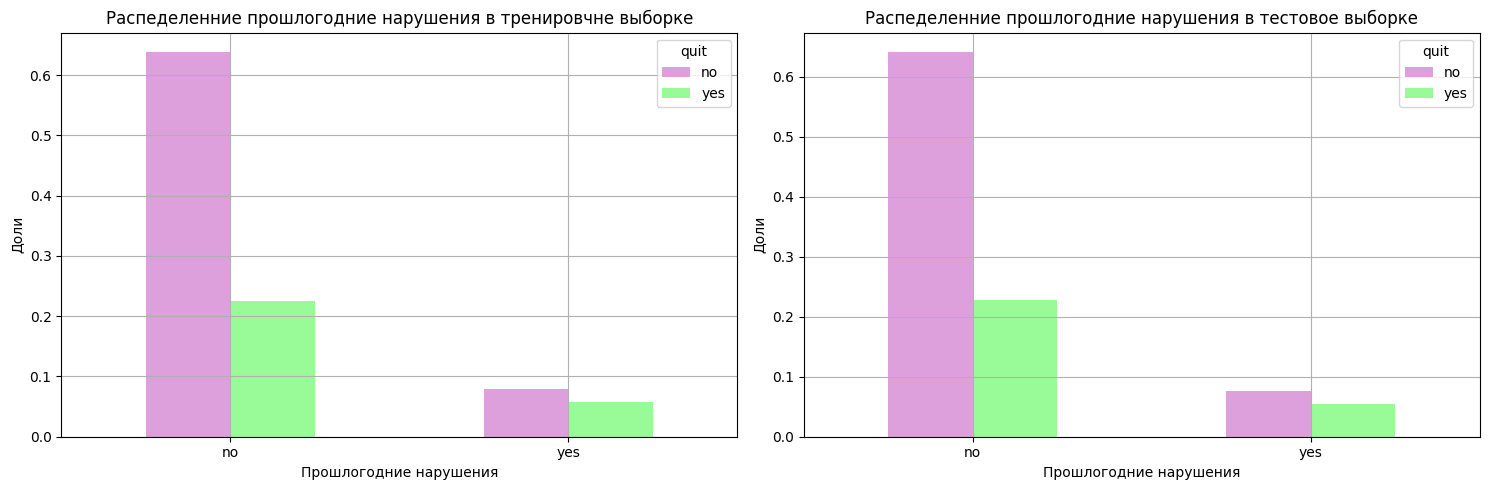

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_quit, X_test_quit]

sample_type = ['в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):
    
    if i == 0:
        dataframe_2 = dataframe
    else:
        dataframe_2 = y_test_quit

    
    pd.crosstab(dataframe['last_year_violations'], dataframe_2['quit'], normalize=True)\
    .plot.bar(color=['plum', 'palegreen'], figsize=(15,5), ax=axes[i]);

    axes[i].set_title(f'Распеделенние прошлогодние нарушения {sample_type[i]}');
    
    axes[i].set_xlabel('Прошлогодние нарушения');
    axes[i].set_ylabel('Доли');
    axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();


plt.tight_layout()


plt.show()

In [122]:
 pd.crosstab(dataframe['last_year_violations'], dataframe_2['quit'], normalize=True)

quit                      no     yes
last_year_violations                
no                    0.6415  0.2275
yes                   0.0765  0.0545

Никакие особености между классами. Большинство сотрудников не нарушили трудовой договор за последний год.

#### Рассределение целовое признак и проверка дисбаланса

/tmp/ipykernel_12441/1604659656.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dataframe.index, y=dataframe, palette=['plum', 'palegreen'], ax=axes[i])
/tmp/ipykernel_12441/1604659656.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dataframe.index, y=dataframe, palette=['plum', 'palegreen'], ax=axes[i])


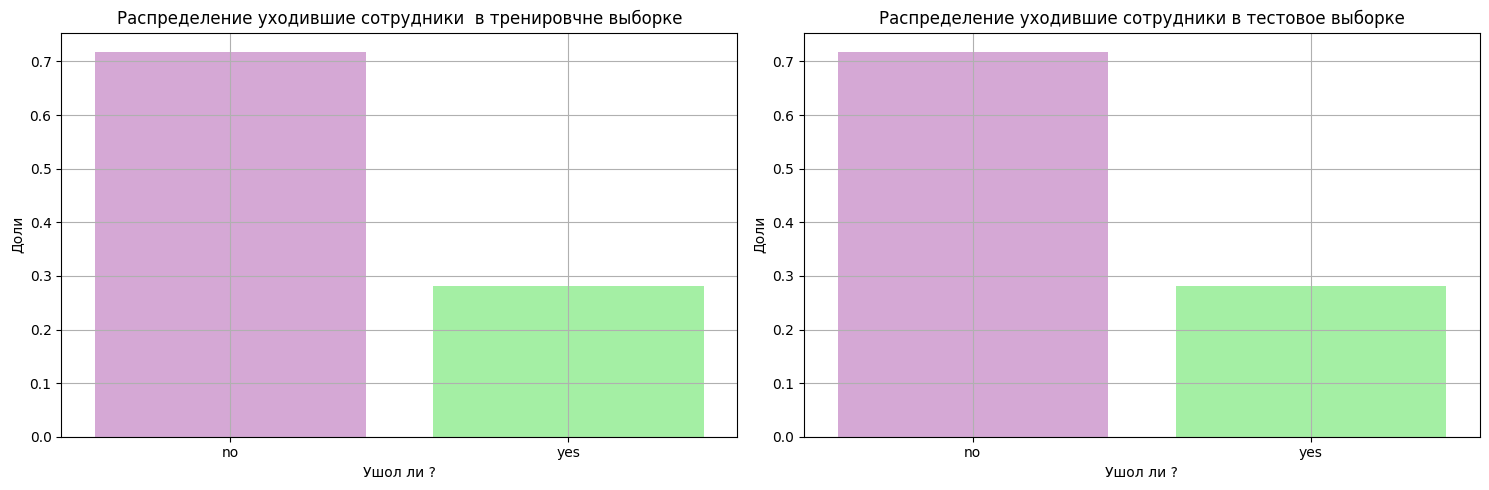

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes = axes.flatten()

dataframes = [df_quit['quit'].value_counts(normalize=True), y_test_quit['quit'].value_counts(normalize=True)]

sample_type = [' в тренировчне выборке', 'в тестовое выборке']

for i, dataframe in enumerate(dataframes):

    sns.barplot(x=dataframe.index, y=dataframe, palette=['plum', 'palegreen'], ax=axes[i])

    axes[i].set_title(f'Распределение уходившие сотрудники {sample_type[i]}') 
    
    axes[i].set_xlabel('Ушол ли ?');
    axes[i].set_ylabel('Доли');
    axes[i].grid();
        

plt.tight_layout()


plt.show()

У нас небольшой дисбаланс между классами в целовом признаке, класс 0 - 71,8% и класс 1 - 28,2%.

### Портрет

#### Портрет «уволившегося сотрудника»

Одной из проблем компании была потеря ценных людей, но, судя по тому, что мы видели, большинство людей, покидающих компанию, не остаются там более чем на 4 года, имеют худшую оценку, мало опыта, они не похожи на ценных людей. . Теперь сделаем типичный портрет «уволившегося сотрудника».

In [124]:
leaving_type = df_quit\
.pivot_table(index='quit', values=['employment_years', 'supervisor_evaluation', 'salary'], aggfunc='median')
leaving_type

employment_years   salary  supervisor_evaluation
quit                                                  
no                 4.0  34800.0                    4.0
yes                1.0  22800.0                    3.0

Глядя на медиану, мы не видим, что этот тип сотрудников проработал в компании 1 год, имеет среднюю зарплату 22 800 и среднюю оценку 3, в то время как сотрудник, который не уходит с работы еще 3 года, получил на 12 000 больше и 1 балл больше в среднем в оценке менеджера.

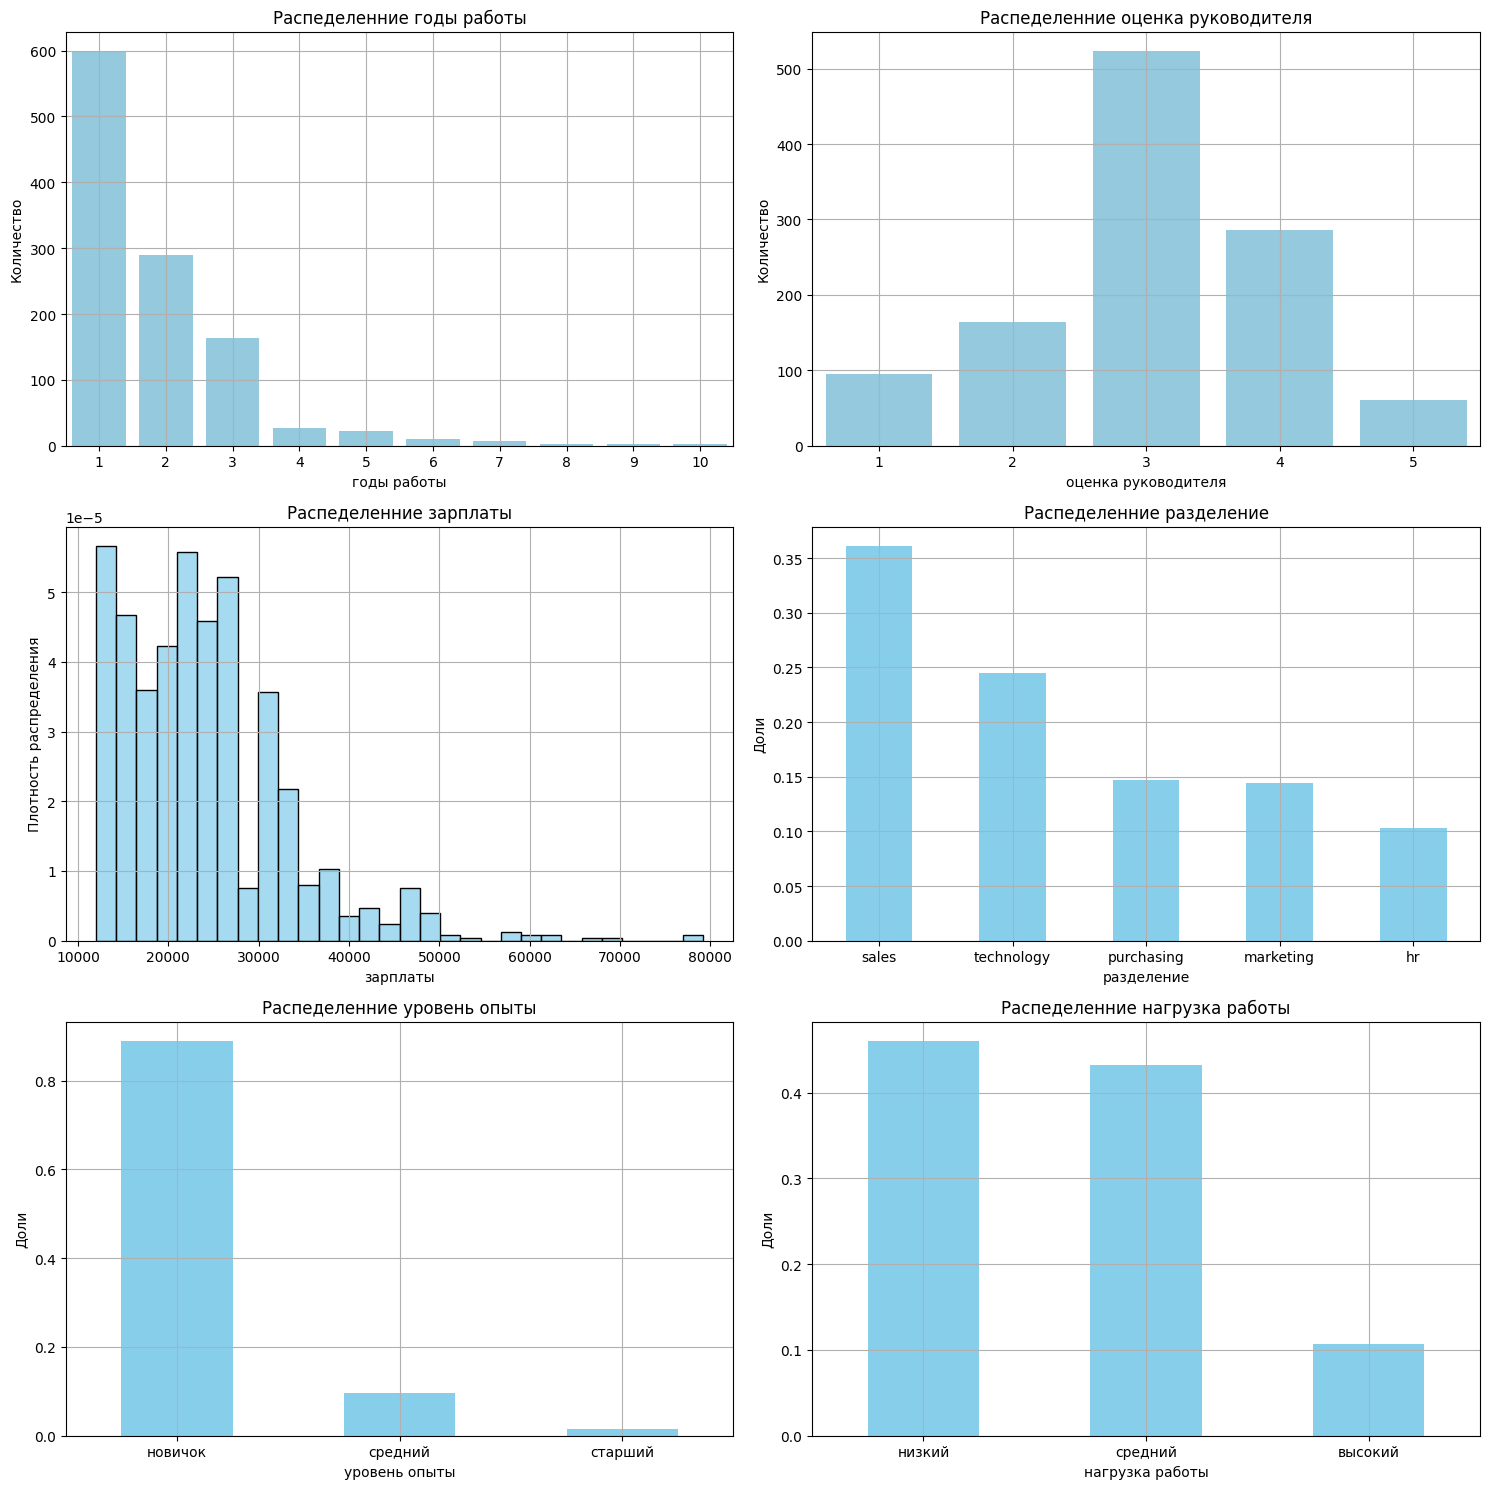

In [125]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axes = axes.flatten()

data = df_quit.query('quit == "yes"')

col_ = ['employment_years', 'supervisor_evaluation', 'salary', 'dept', 'level', 'workload']
col_names = ['годы работы', 'оценка руководителя', 'зарплаты', 'разделение',\
             'уровень опыты', 'нагрузка работы']

for i, col in enumerate(col_):
    
    if i in [0,1]:
        
        sns.countplot(x=data[col], color = 'skyblue', ax=axes[i])
        
        axes[i].set_title(f'Распеделенние {col_names[i]}');
    
        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Количество');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
        
    elif i == 2:
        
        sns.histplot(x=data[col], bins=30, stat='density', common_norm=False, color = 'skyblue', ax=axes[i])
        axes[i].set_title(f'Распеделенние {col_names[i]}');
    
        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Плотность распределения');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
        
    else:
        data[col].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

        axes[i].set_title(f'Распеделенние {col_names[i]}');
    
        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Доли');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
    
  
axes[4].set_xticklabels(['новичок', 'средний', 'старший'], rotation=0)
axes[5].set_xticklabels(['низкий', 'средний', 'высокий'], rotation=0)

plt.tight_layout()


plt.show()

Из прошлого исследования, мы монимаем что характеристика такого человека  в таблице в ниже:

In [126]:
leaving_dict = {
    'отдел': ['продаж'],
    'уровень': ['новичок'],
    'нагрузка работы': ['низкий-средний'],
    'годы работы': [leaving_type.loc['yes','employment_years']],
    'прошлогоднее повышение': ['нет'],
    'прошлогоднее нарушение': ['нет'],
    'оценка руководителя': [leaving_type.loc['yes','supervisor_evaluation']],
    'зарплата': [leaving_type.loc['yes','salary']]
    }
leaving_type_frame = pd.DataFrame(leaving_dict)
leaving_type_frame

отдел  уровень нагрузка работы  годы работы прошлогоднее повышение  \
0  продаж  новичок  низкий-средний          1.0                    нет   

  прошлогоднее нарушение  оценка руководителя  зарплата  
0                    нет                  3.0   22800.0

Одной из проблем компании является потеря ценных людей. Как мы можем определить этих ценных людей? ? Мы могли бы также отобрать людей с большим опытом, но компаниям, безусловно, нужны люди с разным уровнем опыта. Люди с большим опытом стоят дороже, и вы не сможете использовать их для простых задач, это будет пустая трата денег. Кажется, лучший способ — это установить, что ценные работники имеют оценку 5.

####  Портрет valuable employees

In [127]:
valuable_type = df_quit.query('supervisor_evaluation == 5').describe()
valuable_type

employment_years  supervisor_evaluation        salary
count        520.000000                  520.0    520.000000
mean           3.686538                    5.0  34825.384615
std            2.547395                    0.0  15287.557430
min            1.000000                    5.0  12000.000000
25%            1.000000                    5.0  22800.000000
50%            3.000000                    5.0  30000.000000
75%            6.000000                    5.0  44400.000000
max           10.000000                    5.0  87600.000000

Сотрудники с оценкой 5 представляют около 13% df_quit. Если мы возьмем медиану, мы увидим, что эти сотрудники работают 3 года (на 2 года больше, чем уволившиеся люди), имеют среднюю зарплату 30 000. Мы видим, что мы можем определить, что такое ценный сотрудник, только на уровне столбца. Вот почему этот столбец достаточно важен для нашей модели.

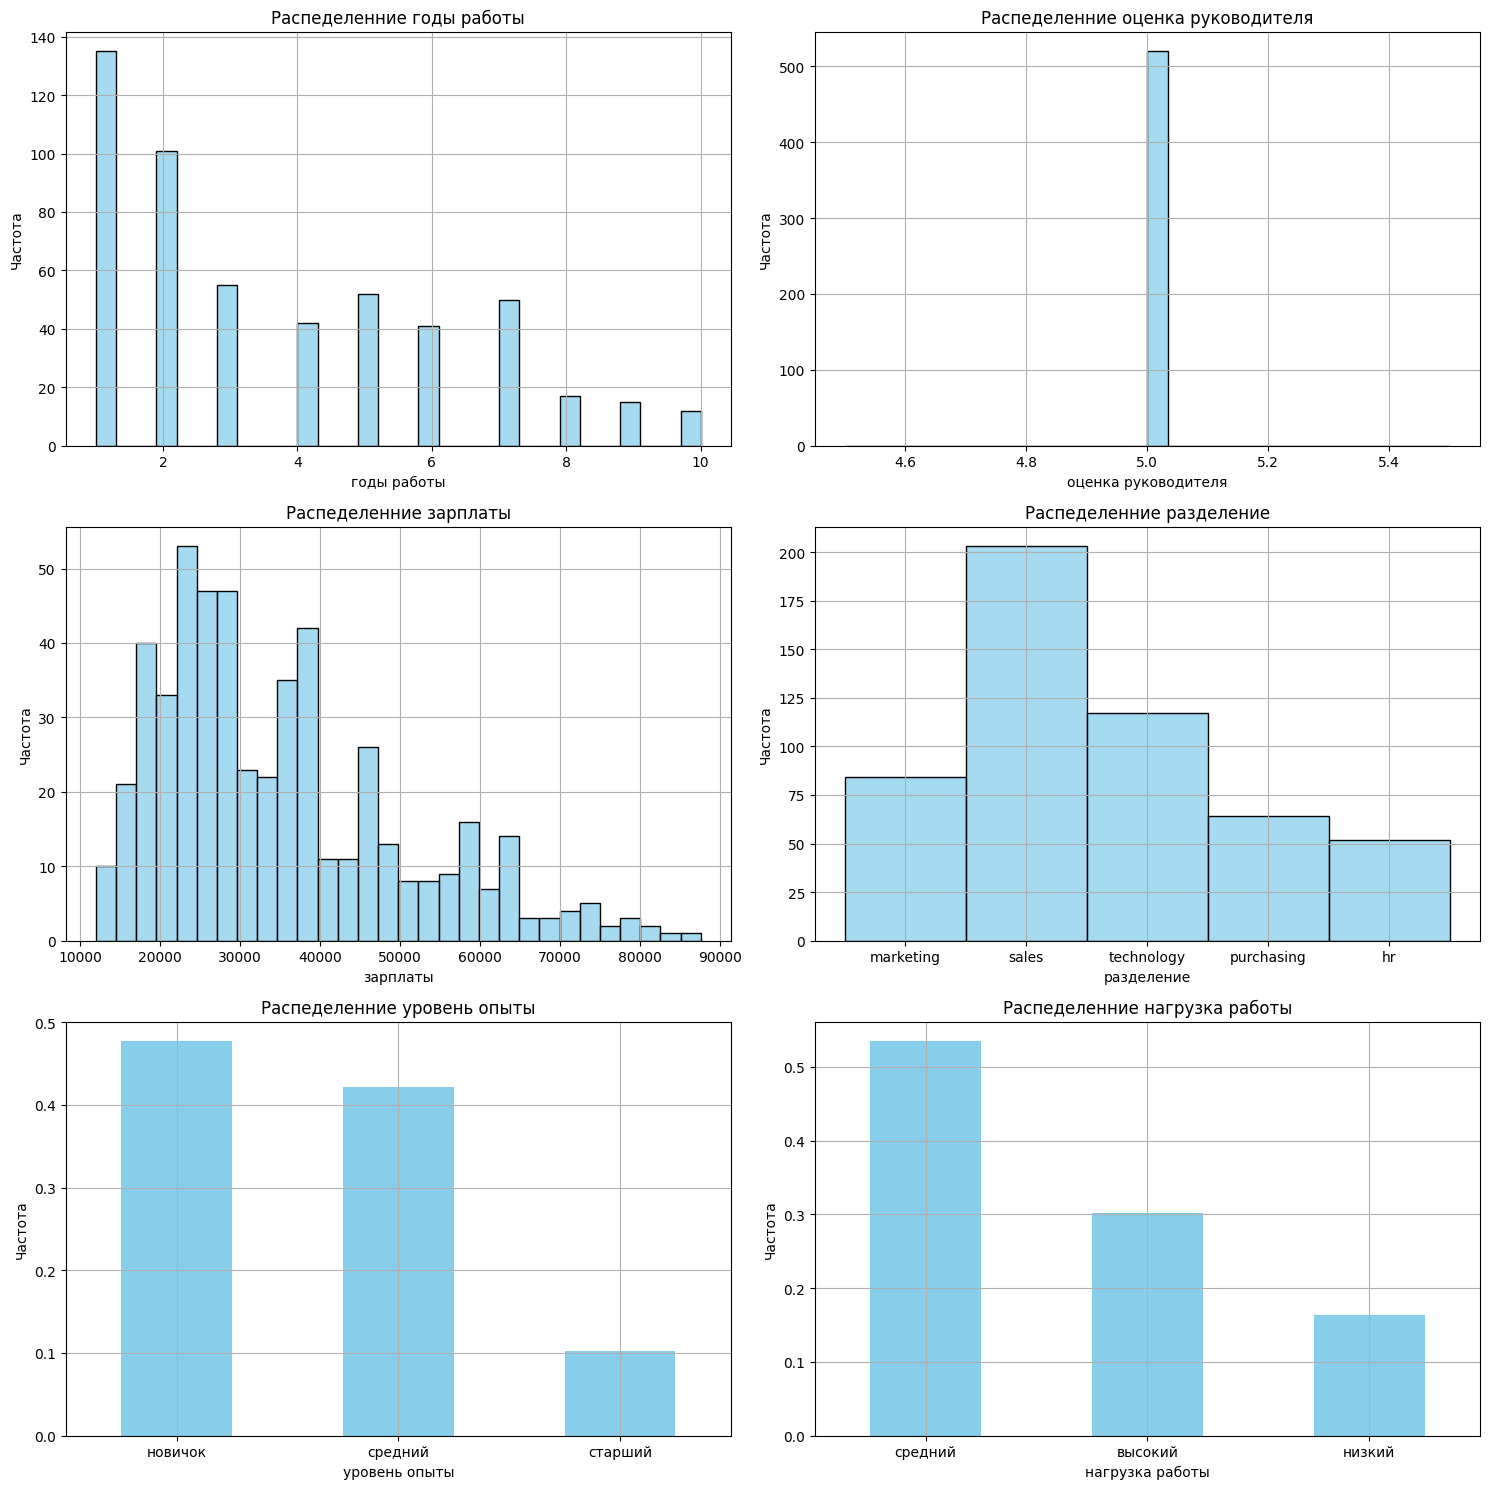

In [128]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

axes = axes.flatten()

data = df_quit.query('supervisor_evaluation == 5')

col_ = ['employment_years', 'supervisor_evaluation','salary', 'dept', 'level', 'workload']
col_names = ['годы работы', 'оценка руководителя', 'зарплаты', 'разделение',\
             'уровень опыты', 'нагрузка работы']

for i, col in enumerate(col_):
    
    if i <4:
        
        sns.histplot(x=data[col], bins=30, color = 'skyblue', ax=axes[i])
        
    else:
        data[col].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

    axes[i].set_title(f'Распеделенние {col_names[i]}');
    
    axes[i].set_xlabel(col_names[i]);
    axes[i].set_ylabel('Частота');
    axes[i].tick_params(axis='x', labelrotation=0)
    axes[i].grid();
    
    
axes[4].set_xticklabels(['новичок', 'средний', 'старший'], rotation=0)
axes[5].set_xticklabels(['средний', 'высокий', 'низкий'], rotation=0)

plt.tight_layout()


plt.show()

In [129]:
valuable_dict = {
    'отдел': ['продаж'],
    'уровень': ['новичок - средний'],
    'нагрузка работы': ['средний'],
    'годы работы': [valuable_type.loc['50%','employment_years']],
    'прошлогоднее повышение': ['no'],
    'прошлогоднее нарушение': ['no'],
    'оценка руководителя': [valuable_type.loc['50%','supervisor_evaluation']],
    'зарплата': [valuable_type.loc['50%','salary']]
    }
valuable_type_frame = pd.DataFrame(valuable_dict)
valuable_type_frame

отдел            уровень нагрузка работы  годы работы  \
0  продаж  новичок - средний         средний          3.0   

  прошлогоднее повышение прошлогоднее нарушение  оценка руководителя  зарплата  
0                     no                     no                  5.0   30000.0

Наиболее ценные сотрудники хорошо распределены по различным категориям отделов, уровню опыта и должностных обязанностей. Мы видим, что у этих ценных людей коэффициент удовлетворенности превысил 0,45. 25 % из них получили от 0,649 до 0,70, а еще 25 % — от 0,81 до 0,92. Мы возвращаемся к исследованию важности признака, где мы увидели, что наиболее важным признаком для определения уровня удовлетворенности работой является оценка руководителя.

### Отношенние satisfaction_rate c quit

In [130]:
df_quit_rate = y_test_quit.merge(y_test_1, on='id')
df_quit_rate.head()

quit  job_satisfaction_rate
id                                
485046   no                   0.79
686555   no                   0.72
467458   no                   0.64
418655   no                   0.60
789145   no                   0.75

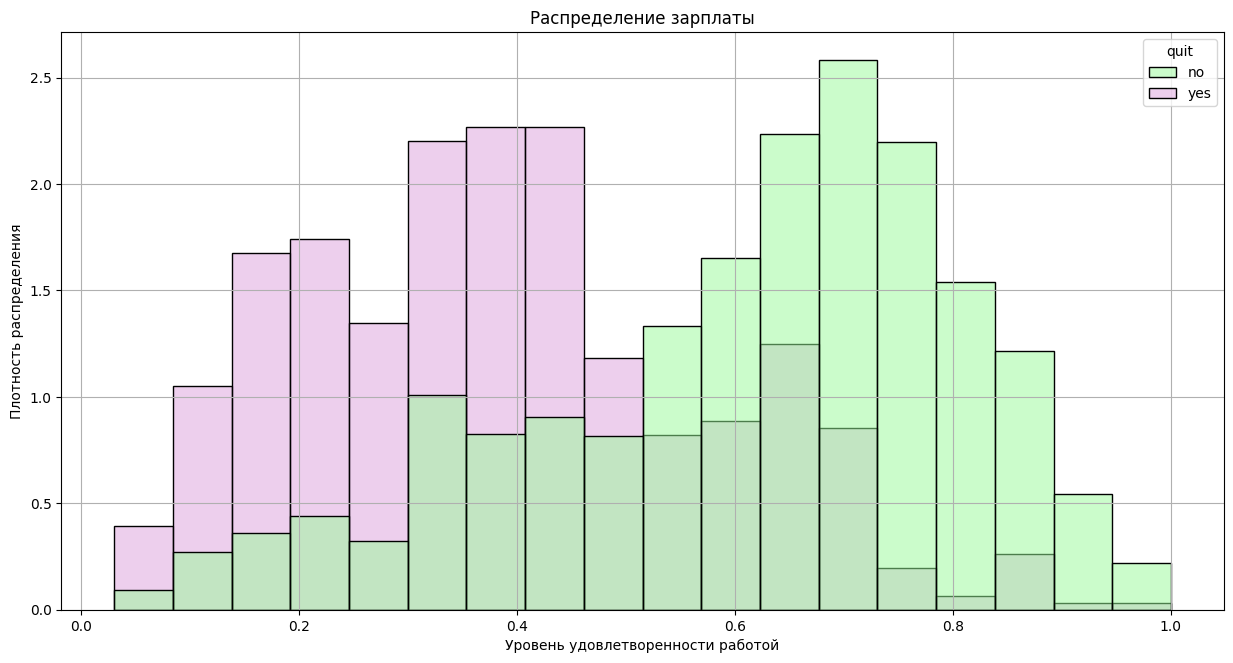

In [131]:
df_quit_rate = y_test.merge(y_test_quit, on='id')
fig, axes = plt.subplots(figsize=(15, 7.5))
sns.histplot(x=df_quit_rate['job_satisfaction_rate'],  hue=df_quit_rate['quit'], \
             stat='density', common_norm=False, palette = ['palegreen' , 'plum'], ax=axes);
axes.set_title(f'Распределение зарплаты') 
axes.set_xlabel('Уровень удовлетворенности работой');
axes.set_ylabel('Плотность распределения');
axes.grid();

Мы видим, что у большинства людей, которые уволились, уровень удовлетворенности был ниже 0,5. Следует отметить, что некоторые люди с уровнем удовлетворенности выше 0,5 все еще увольняются.

In [132]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df_quit_rate['job_satisfaction_rate'], y=df_quit_rate['quit'], palette=['palegreen' , 'plum'], ax=axes);
axes.set_title(f'Боксплот уровень удовлетворенности работой') 
axes.set_xlabel('Уровень удовлетворенности работой');
axes.set_ylabel('Частота');
axes.grid();

/tmp/ipykernel_12441/3642504614.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_quit_rate['job_satisfaction_rate'], y=df_quit_rate['quit'], palette=['palegreen' , 'plum'], ax=axes);


Мы видим, что медианный показатель для увольняющихся составляет около 0,38, а для остающихся — около 0,66. Мы даже замечаем выброс после 0,85.

Давайте посмотрим, какова будет статистика для «ценного сотрудника».

In [133]:
id_high_xp = X_test_quit.query('level == "senior"').index

In [134]:
y_test.loc[id_high_xp]['job_satisfaction_rate'].describe()

count    171.000000
mean       0.611345
std        0.225075
min        0.060000
25%        0.455000
50%        0.660000
75%        0.785000
max        1.000000
Name: job_satisfaction_rate, dtype: float64

Медиана уровня удовлетворенности работой для «ценного сотрудника» составляет 0,66.

Сравниваем 2 выборки, уволившихся сотрудников и не уволившихся сотрудников что бы понимать если у уволившихся сотрудников среднаа оценка меншее не уволившихся сотрудников ?
    
Нулевая гипотеза: Средная оценка между выборками равная.

$$
H_0 : \mu_{quit} = \mu_{noquit}
$$
    
Альтернативной гипотеза: Средная оценка уволившихся сотрудников меншее средной оценки не уволившихся сотрудников.

$$
H_1 : \mu_{quit} \lt \mu_{noquit}
$$

$\mu_{quit}$ : cредная оценка первой выборки - уволившихся сотрудников, $\mu_{noquit}$ : cредная оценка второй выборки - не уволившихся сотрудников

In [135]:
# найти фрейм данных, содержащий только ушедших сотрудников
index_quit = y_test_quit.query('quit == "yes"').index
df_ttest_quit = y_test.loc[index_quit]

index_noquit = y_test_quit.query('quit == "no"').index
df_ttest_noquit = y_test.loc[index_noquit]

In [136]:
print('среднее первой выборки:', df_ttest_quit['job_satisfaction_rate'].mean()) # среднее первой выборки 
print('среднее второй выборки:', df_ttest_noquit['job_satisfaction_rate'].mean()) # среднее второй выборки 

alpha = 0.05 # статистически значимости

results_eval = st.ttest_ind(df_ttest_quit, df_ttest_noquit, equal_var=False, alternative='less') # итог теста

p_value_eval = results_eval.pvalue # p-значенние
print('p-значенние:', p_value_eval)

if p_value_eval < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

среднее первой выборки: 0.38771276595744686
среднее второй выборки: 0.6120403899721449
p-значенние: [1.3854314e-101]
Отвергаем нулевую гипотезу


### Вывод

In [137]:
len(df_sat.query('supervisor_evaluation <4'))/4000

0.4425

In [138]:
leaving_type_frame

отдел  уровень нагрузка работы  годы работы прошлогоднее повышение  \
0  продаж  новичок  низкий-средний          1.0                    нет   

  прошлогоднее нарушение  оценка руководителя  зарплата  
0                    нет                  3.0   22800.0

In [139]:
portrait_table = pd.concat([leaving_type_frame, valuable_type_frame], axis=0)
portrait_table.index = ['уходящий сотрудник', 'ценный сотрудник']
portrait_table

отдел            уровень нагрузка работы  годы работы  \
уходящий сотрудник  продаж            новичок  низкий-средний          1.0   
ценный сотрудник    продаж  новичок - средний         средний          3.0   

                   прошлогоднее повышение прошлогоднее нарушение  \
уходящий сотрудник                    нет                    нет   
ценный сотрудник                       no                     no   

                    оценка руководителя  зарплата  
уходящий сотрудник                  3.0   22800.0  
ценный сотрудник                    5.0   30000.0

По распределению входных признаков между датафрейми тренировочной и тестовой из первый и второй части те же тенденции. 
У целового признака средние дисбалансы, не нужно ничего делать по этому поводу.
Мы смогли ориентироваться по типу «уволившегося сотрудника», смотря на медиану, у этого сотрудника :
- средняя зарплата - 22800, она достаточно низкая, может быть причиной его увольнения
- среднее время работы - 1 год, мало, быстро уходят с работы
- средний уровень опыта работы - 
- средная оценка - 3 - средная оценка
- отдел - особенно продажи
- нагрузка работы - низкий-средний
Учитывая это мы можем понимать что большинство людей, которые ушли, или не подходят компании или им не понравилось работать там. Все таки они достаточно быстро уходят из копании, большинство не остаются работать дольше 3 лет. Мы тоже можем предположить что они достаточно молодые, из-за того что у них мало опыты.

Мы тоже определили тех, кто важен для компанни, сотрудников, которых компания не хотет терять, мы считаем, что у них оценка руковадителя равна 5. У них, по медиане:
- средняя зарплата - 30000, напомним что это медина зарплаты
- среднее количество лет работы - 3 года, это тоже медиана лет работы по датафрейм
- средний уровень работы - новичок - средний
- средная оценка - 3 - средная оценка
- отдел - особенно продажи
- нагрузка работы - средная
Мы видели что эти ценные сотрудники были хорошо распределены в отделах компаннии и у них не обязателно хорошая зарплата или большой опыт, но они нужны в решении задач.

## Добавление нового входного признака

Давайте добавим нашу предсказанную переменную в датафрейм с нашей зависимой переменной X_test_quit. Но сначала давайте добавим эту предсказанную переменную внутрь датафрейм. Результатом является новая датафрейм X_merged.

In [140]:
pred_table = pd.DataFrame(y_test_pred, index=y_test.index)
pred_table.columns = ['job_satisfaction_rate']
pred_table.head()

job_satisfaction_rate
id                           
485046               0.845714
686555               0.676667
467458               0.697778
418655               0.697778
789145               0.824643

In [141]:
X_merged = X_test_quit.merge(pred_table, on='id')
X_merged.head()

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
485046                   no                      5   28800   
686555                   no                      4   30000   
467458                   no                      4   19200   
418655                   no                      4   19200   
789145                   no                      5   40800   

        job_satisfaction_rate  
id                             
485046               0.845714  
686555               0.676667  
467458               0.697778  
418655               0.697778  
789145               0.824643

С нашим лучшим оценщиком мы собираемся добавить предсказанную переменную job_sagisfactionrate для тренировочных данных df_quit, чтобы иметь возможность тренировать нашу модель с соответствующим количеством сотрудников.

In [142]:
# Использование нашей лучшей модели --> model
y_pred_quit = model.predict(df_quit.drop('quit', axis=1))
y_pred_quit.shape

(4000,)

In [143]:
df_quit['job_satisfaction_rate'] = y_pred_quit

In [144]:
df_quit.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  \
id                                                                
723290                   no                      4   54000   no   
814010                   no                      4   27600   no   
155091                   no                      1   37200   no   
257132                  yes                      3   24000  yes   
910140                   no                      5   25200   no   

        job_satisfaction_rate  
id                             
723290               0.660000  
814010               0.831364  
155091               0.351111  
257132               0.350000  
910140               0.791667

## Корреляционный анализ

In [145]:
# Выбираем столбцы с числовым значением
interval_cols_1 = ['salary', 'job_satisfaction_rate']

### Корреляционный анализ в тренировочной выборке

In [146]:
# Вычисляем матрицу корреляции с использованием phik
corr_matrix_1 = df_quit.phik_matrix(interval_cols=interval_cols_1)

cols_name = ['разделение', 'уровень опыты', 'нагрузка работы', 'количество лет работы', \
             'прошлогодние повышение', 'прошлогодние нарушения', 'оценка руководителя', 'зарплата', \
             'уровень удовлетворенности работой', 'quit']

# Визуализация матрицы 
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix_1, 
            xticklabels=cols_name,
            yticklabels=cols_name,
            annot=True, 
            cmap='viridis');
plt.title('Phi_K Correlation Matrix')
plt.show()

Отметим, что видим то, что мы видели в первой части. Зарплаты особенно зависят от уровня опыта, нагрузки работы, уровня удовлетворенности работой, и количества лет работы. Заметим среднюю корреляцию между количеством лет работы с уровенем опыта и с уровень удовлетворенности работой, и нагрузкой работы со уровенем опыта.
Если мы посмотрим на нашу новую переменную 'quit', мы увидим, что она существенно зависит от оценки руководителя, и прошлогоднего нарушения а также в меньшей степени от прошлогоднего повышения, количества лет работы и уровеня удовлетворенности работой.

Согласно графику, у нас нет ни большой корреляции, ни коллинеарности между нашими признаками. 

### Корреляционный анализ в тестовой выборке

Сначала давайте присоединим наши тестовые датафреймы для этого исследования.

In [147]:
df_test_quit = X_merged.merge(y_test_quit, on='id')
df_test_quit.shape

(2000, 10)

Соединения получились.

In [148]:
# Вычисляем матрицу корреляции с использованием phik
corr_matrix_test_1 = df_test_quit.phik_matrix(interval_cols=interval_cols_1)

cols_name = ['разделение', 'уровень опыты', 'нагрузка работы', 'количество лет работы', \
             'прошлогодние повышение', 'прошлогодние нарушения', 'оценка руководителя', 'зарплата', \
            'уровень удовлетворенности работой', 'quit']

# Визуализация матрицы 
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix_test_1, 
            xticklabels=cols_name,
            yticklabels=cols_name,
            annot=True, 
            cmap='viridis');
plt.title('Phi_K Correlation Matrix')
plt.show()

Отметим, что видим то что мы видели в первой части. Зарплаты особенно зависят от уровеня опыта, нагрузки работы, уровня удовлетворенности работой, и количества лет работы. Заметим среднюю корреляцию между количеством лет работы с уровнем опыта и с уровенем удовлетворенности работой, и нагрузкой работы с уровенем опыта.

Однако, если мы посмотрим на нашу новую переменную 'quit', мы увидим, что она менше зависит от оценки руководителя, прошлогоднего нарушения и прошлогоднего повышения. И особенно зависит от количества лет работы, уровня удовлетворенности работой и зарплаты.

Согласно графику, у нас нет ни большой корреляции, ни коллинеарности между нашими признаками.

## Пайплайн

Мы должны были решить класификацию проблем и для этого мы исползовали пайплайн. Для пайплайн мы использовали:
- SimpleImputer чтобы заменить пропуски наиболее частыми значениями
- OneHotEncoder для столбцов: 'last_year_promo', 'last_year_violations', и 'dept'
- OrdinalEncoder для 'level', 'workload', где есть иерархические порядки,
- три разных скалера для масштабирования:
    - StandardScaler(), 
    - MinMaxScaler() 
    - RobustScaler(),
- метод численной оптимизации - RandomizedSearchCV, где мы передаем 4 разные модели машинного обучения с разными параметрами. Эти модели:   
    - DecisionTreeClassifier
    - KNeighborsClassifier
    - SVC
    - LogisticRegression
    - RandomForestClassifier
    
Отметим что для дерева решений все категории со строками значение будут кодированы OrdinalEncoder() кроме значения из столбца 'dept'.
Затем мы использовали метрик roc_auc, потому что она надежна для классификации, поскольку она оценивает производительность модели с учетом всех возможных порогов и не зависит от конкретного порога.
В завершение я сортировал различные интересные метрики для модели, а также отчет RandomizeSearchCV.

Класс 0 - сотрудник не ушел, класс 1 - сотрудник ушел.

In [149]:
# Провераем дупликаты
df_quit.duplicated().sum()

1413

In [150]:
# Убираем дупликаты
df_quit.drop_duplicates(inplace=True)

In [151]:
# Провераем что убрали все дупликаты
df_quit.duplicated().sum()

0

In [152]:
# Разделаем целовое признак из других признаков в df_sat
X_2 = df_quit.drop('quit', axis=1)
y_2 = df_quit['quit']

In [153]:
# Параметеры для разделение
RANDOM_STATE=42

# создаём списки с названиями признаков
enc_columns_2 = ['last_year_promo', 'last_year_violations']
enc_2_columns_2 = ['dept']
ord_columns_2 = ['level', 'workload']
num_columns_2 = X_2.select_dtypes(include='number').columns.to_list()

print(f'У нас все столбце --> {len(enc_columns+enc_2_columns+ord_columns+num_columns)==len(X.columns)}.')

le = LabelEncoder()
y_2_le = le.fit_transform(y_2)
y_test_2_le = le.transform(y_test_quit['quit'])

У нас все столбце --> True.


In [154]:
# Проверяем что кодирование для целевого признака хорошо прошло 
print(pd.DataFrame(y_2_le, y_2, columns=['LabelEncoder']).tail(5))

# создаём пайплайн для категорильного значения

ohe_pipe_22 = Pipeline([
    ('imp_1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe_2', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipe_2 = Pipeline([
    ('imp_2', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord_1', OrdinalEncoder(categories=[
         ['junior', 'middle', 'senior'],
         ['low', 'medium', 'high'],]))
])

# создаём общий пайплайн для подготовки данных
data_preprocessor_2 = ColumnTransformer(
    [('ohe_1', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), enc_columns_2),
     ('ohe_2', ohe_pipe_22, enc_2_columns_2),
     ('ord', ord_pipe_2, ord_columns_2),
     ('num', MinMaxScaler(), num_columns_2)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_2 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__max_features': range(2,14),
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  

    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
   },
     # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
        )],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
  
    # словарь для модели SVC()
    {
        'models':[SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100, 1000],  
        'models__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
         # словарь для модели RandomForestClassifier()
    {
        'models':[RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80],
        'models__max_features': range(2,14),
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__bootstrap': [True, False],
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]       
      }
 ]

      LabelEncoder
quit              
yes              1
no               0
yes              1
yes              1
no               0


In [155]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    error_score="raise",
    n_jobs=-1
)
randomized_search_2.fit(X_2, y_2_le)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe_1',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ohe_2',
                                                                               Pipeline(steps=[('imp_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe_2'...
                                         'models__bootstrap': [True, False],
                                         'models__max_depth': range(2, 14),
                                         'models__max_features': range(2, 14),
                                         'models__min_samples_leaf': range(1, 14),
                                         'models__min_samples_split': range(2, 14),
                                         'models__n_estimators': [10, 17, 25,
                                                                  33, 41, 48,
                                                                  56, 64, 72,
                                                                  80],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()],
                                         'preprocessor__ohe_1': [OrdinalEncoder()]}],
                   random_state=42, scoring='roc_auc')

In [156]:
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', randomized_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                        

In [157]:
# Итог гиперпараметр тюнинг
report_randomised_search_2 = pd.DataFrame(randomized_search_2.cv_results_) 
pd.set_option('display.max_colwidth', None)
report_randomised_search_2.sort_values('rank_test_score', ascending=True)[['param_preprocessor__num', \
                                                                         #'param_preprocessor__ohe_1', \
                                                                         #'param_preprocessor__ohe_2', \
                                                                         'param_models', 'params', \
                                                                         'mean_test_score', 'std_test_score', \
                                                                         'rank_test_score']].head(3)

param_preprocessor__num                             param_models  \
8        StandardScaler()  RandomForestClassifier(random_state=42)   
4          RobustScaler()  RandomForestClassifier(random_state=42)   
6        StandardScaler()  RandomForestClassifier(random_state=42)   

                                                                                                                                                                                                                                                                                                             params  \
8     {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': StandardScaler(), 'models__n_estimators': 25, 'models__min_samples_split': 6, 'models__min_samples_leaf': 12, 'models__max_features': 4, 'models__max_depth': 3, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   
4      {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': RobustScaler(), 'models__n_estimators': 48, 'models__min_samples_split': 11, 'models__min_samples_leaf': 12, 'models__max_features': 6, 'models__max_depth': 5, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   
6  {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': StandardScaler(), 'models__n_estimators': 33, 'models__min_samples_split': 10, 'models__min_samples_leaf': 13, 'models__max_features': 11, 'models__max_depth': 13, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   

   mean_test_score  std_test_score  rank_test_score  
8         0.915593        0.006388                1  
4         0.915479        0.009179                2  
6         0.907716        0.010261                3

In [158]:
# best model
model_2 = randomized_search_2.best_estimator_
model_2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[...
                                                                  ('ord_1',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']]))]),
                                                  ['level', 'workload']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate'])])),
                ('models',
                 RandomForestClassifier(max_depth=3, max_features=4,
                                        min_samples_leaf=12,
                                        min_samples_split=6, n_estimators=25,
                                        random_state=42))])

## Анализ важности признаков

In [159]:
# инициализируем все нужные классы для работы модели
selector = SelectKBest(f_classif, k=12)

# создаём общий пайплайн для подготовки данных

shap_X_2 = data_preprocessor_2.fit_transform(X_2)
shap_X_test_2 = data_preprocessor_2.transform(X_merged)
shap_column_names_2 = data_preprocessor_2.get_feature_names_out()
shap_X_2 = pd.DataFrame(shap_X_2, columns = shap_column_names_2)
shap_X_test_2 = pd.DataFrame(shap_X_test_2, columns = shap_column_names_2)

# обучаем SelectKBest
selector.fit(shap_X_2, y_2)

# сформирум выборки с лучшими признаками
features_names_2 = shap_X_2.columns[selector.get_support(indices=True)]
X_new_2 = shap_X_2[list(features_names_2)]
X_test_new_2 = shap_X_test_2[list(features_names_2)]


model_inf_2 = RandomForestClassifier(max_depth=3, max_features=4, min_samples_leaf=12, \
                                     min_samples_split=6, n_estimators=25, random_state=42)

# обучим модель на лучших признаках
model_inf_2.fit(X_new_2, y_2_le)


# отложим значения коэффициентов на графике
coefficients_2 = model_inf_2.feature_importances_
features_importance_2 = pd.DataFrame({'Features': features_names_2, 'Importance': np.abs(coefficients_2)})
features_importance_2 = features_importance_2.sort_values('Importance',ascending=True)

plot_features_importance_2 = features_importance_2.plot(x='Features', \
                                                     y='Importance',\
                                                     kind='barh', figsize=(10, 6));

plt.title('Важности признаков с методом SelectKBest'),
plt.xlabel('Важность'); 
plt.ylabel('Признаки'); 

                           Features  Importance
0        ohe_1__last_year_promo_yes    0.000000
3            ohe_2__dept_purchasing    0.000000
4                 ohe_2__dept_sales    0.000000
5            ohe_2__dept_technology    0.000000
2             ohe_2__dept_marketing    0.000937
1   ohe_1__last_year_violations_yes    0.002325
9        num__supervisor_evaluation    0.005282
7                     ord__workload    0.010905
10                      num__salary    0.012522
8             num__employment_years    0.206436
6                        ord__level    0.219074
11       num__job_satisfaction_rate    0.248647


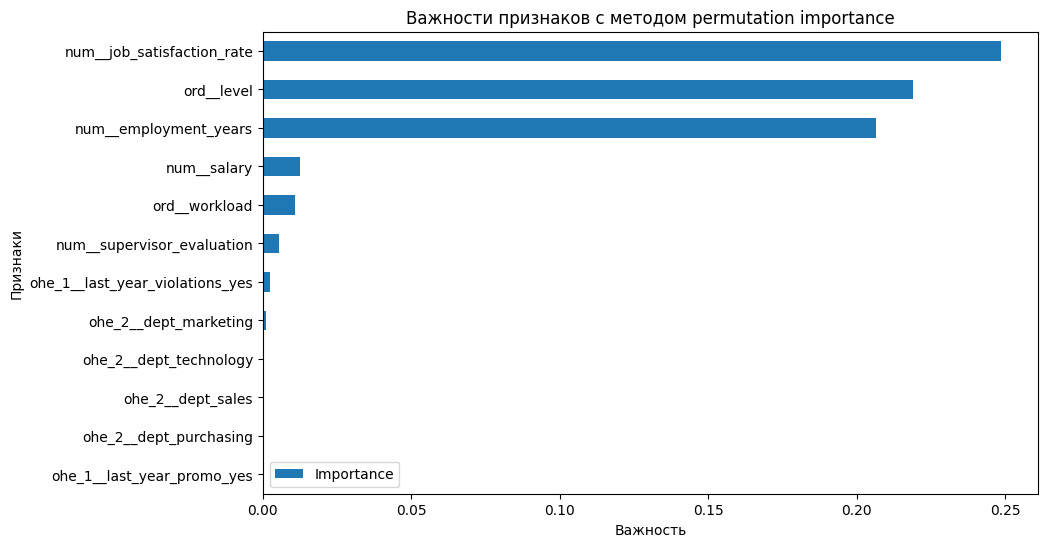

In [160]:
def custom_f1(model, X, y):
    y_pred = model.predict(X)
    score = f1_score(y, y_pred)
    return score


result = permutation_importance(model_inf_2, X_test_new_2, y_test_2_le, scoring=custom_f1)

features_importance_permutation_2 = pd.DataFrame({'Features': features_names_2, \
                                                'Importance': np.abs(result['importances_mean'])})
features_importance_permutation_2 = features_importance_permutation_2.sort_values('Importance', ascending=True)
print(features_importance_permutation_2)
plot_feature_importance_permutation_2 = features_importance_permutation_2.plot(x='Features', y='Importance', \
                                                                           kind='barh', figsize=(10, 6)); 

plt.title('Важности признаков с методом permutation importance'),
plt.xlabel('Важность'); 
plt.ylabel('Признаки'); 

С методом SKbest и permutation_importance видим что у нас

1 очень важный признак, в порядке важности:

- уровень удовлетворенности работой

Есть 4 слабо влияющих признака, в порядке значимости:

- годы работы
- уровень опыты
- нагрузка работы
- зарплата

Есть 3 почти не влияющих признака, в порядке важности: выход:

- отдел
- оценка руковадители
- прошлогоднее нарушение
- прошлогоднее повышение

По сравнению с первой частью, где самым важным была оценка руковадители сейчас самым важным является уровень удовлетворенности работой. Токгда самым не важным является прошлогоднее повышение. Сейчас у нас 3-4 призна которые мы можем убрать, наверно. Эти признаки были более важны раншее, например оценка руковадителя. Понятно почему важность так снизилась. Так как мы ипсолзуем уровень удовлетворенности работой который был расчитан особенно оценкой руководителя, нам сейчас это значение может быть не нужно.

## Вторая кросс-валидация 

Чтобы увеличить качество модели нам нужно понимать кака комбиразиа отборов признаков нужно из этих 3 самы слабы признаков из датафреймы : 
- dept
- last_year_violations
- last_year_promo

In [161]:
features_lst = ['dept', 'last_year_violations', 'last_year_promo']
combs = []
for i in range(1, len(features_lst)+1):
    for s in combinations(features_lst, i):
        combs.append(s)


param_grid_00 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__max_features': range(2,14),
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  

    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
   },
     # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
        )],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
  
    # словарь для модели SVC()
    {
        'models':[SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100, 1000],  
        'models__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
         # словарь для модели RandomForestClassifier()
    {
        'models':[RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80],
        'models__max_features': range(2,14),
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__bootstrap': [True, False],
        'preprocessor__ohe_1': [OrdinalEncoder()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]       
      }
 ]


param_grid_01 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__max_features': range(2,14),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  

    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
   },
     # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
        )],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
  
    # словарь для модели SVC()
    {
        'models':[SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100, 1000],  
        'models__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
         # словарь для модели RandomForestClassifier()
    {
        'models':[RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80],
        'models__max_features': range(2,14),
        'models__min_samples_split':range(2,14),
        'models__min_samples_leaf':range(1,14),
        'models__max_depth': range(2,14),
        'models__bootstrap': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]       
      }
 ]


res = []
best_estimators = []
for j in range(len(combs)): 
    
    if len(combs[j]) == 1:
        
        x = combs[j][0]

    
        df_quit_important = df_quit.drop([x], axis=1)
        print('Количество дупликатов:', df_quit_important.duplicated().sum())
        df_quit_important.drop_duplicates(inplace=True)
        print('Количество дупликатов после удаленнии:', df_quit_important.duplicated().sum())
        print(df_quit_important.columns)
        
        # Разделяем целовое признак из других признаков в df_sat
        X_3 = df_quit_important.drop('quit', axis=1)
        y_3 = df_quit_important['quit'] 

        le = LabelEncoder()
        y_3_le = le.fit_transform(y_3)
        y_test_3_le = le.transform(y_test_quit['quit'])

        # Параметеры для разделение
        RANDOM_STATE=42


        # создаём списки с названиями признаков
        
        ord_columns_2 = ['level', 'workload']
        enc_2_columns_2 = ['dept']
        num_columns_2 = X_3.select_dtypes(include='number').columns.to_list()
        
        param_grid_test = param_grid_00
        
        if 'dept' in x:
            enc_columns_2=['last_year_violations', 'last_year_promo']
            data_preprocessor_test = ColumnTransformer(
                [('ohe_1', OneHotEncoder(drop='first', handle_unknown='ignore', \
                                         sparse_output=False), enc_columns_2),
                 ('ord', ord_pipe_2, ord_columns_2),
                 ('num', MinMaxScaler(), num_columns_2)
                ], remainder='passthrough')
   

        elif 'last_year_violations' in x:
            enc_columns_2 = ['last_year_promo']
            data_preprocessor_test = ColumnTransformer(
                [('ohe_1', OneHotEncoder(drop='first', handle_unknown='ignore', \
                                         sparse_output=False), enc_columns_2),
                 ('ohe_2', ohe_pipe_22, enc_2_columns_2),
                 ('ord', ord_pipe_2, ord_columns_2),
                 ('num', MinMaxScaler(), num_columns_2)
                ], 
                remainder='passthrough'
            )

            
            
        elif 'last_year_promo' in x:
            enc_columns_2 = ['last_year_violations']
            data_preprocessor_test = ColumnTransformer(
                [('ohe_1', OneHotEncoder(drop='first', handle_unknown='ignore', \
                                         sparse_output=False), enc_columns_2),
                 ('ohe_2', ohe_pipe_22, enc_2_columns_2),
                 ('ord', ord_pipe_2, ord_columns_2),
                 ('num', MinMaxScaler(), num_columns_2)
                ], 
                remainder='passthrough'
            )
 

        pipe_final_test = Pipeline([
            ('preprocessor', data_preprocessor_test),
            ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
        ])

        pipe_final_test.named_steps['preprocessor']
        
        randomized_search_test = RandomizedSearchCV(
            pipe_final_test, 
            param_grid_test, 
            cv=5,
            scoring='roc_auc',
            random_state=RANDOM_STATE,
            error_score="raise",
            n_jobs=-1)
        
        randomized_search_test.fit(X_3, y_3_le)
        print(pipe_final_test.named_steps['preprocessor'])
        print(x, randomized_search_test.best_score_)
        
                
    else:
        x = list(combs[j])
        df_quit_important = df_quit.drop(x, axis=1)
        print('Количество дупликатов:', df_quit_important.duplicated().sum())
        df_quit_important.drop_duplicates(inplace=True)
        print('Количество дупликатов после удаленнии:', df_quit_important.duplicated().sum())
        
        # Разделяем целовое признак из других признаков в df_sat
        X_3 = df_quit_important.drop('quit', axis=1)
        y_3 = df_quit_important['quit'] 

        le = LabelEncoder()
        y_3_le = le.fit_transform(y_3)


        # Параметеры для разделение
        RANDOM_STATE=42

        # создаём списки с названиями признаков
        
        ord_columns_2 = ['level', 'workload']
        enc_2_columns_2 = ['dept']
        num_columns_2 = X_3.select_dtypes(include='number').columns.to_list()
        
        param_grid_test = param_grid_00

        
        if 'dept' in x and 'last_year_violations' in x and 'last_year_promo' not in x:
            enc_columns_2=['last_year_promo']
            data_preprocessor_test = ColumnTransformer(
                [('ohe_1', OneHotEncoder(drop='first', handle_unknown='ignore', \
                                         sparse_output=False), enc_columns_2),
                 ('ord', ord_pipe_2, ord_columns_2),
                 ('num', MinMaxScaler(), num_columns_2)
                ], remainder='passthrough')
   

        elif 'dept' in x and 'last_year_promo' in x and 'last_year_violations' not in x:
            enc_columns_2 = ['last_year_violations']
            data_preprocessor_test = ColumnTransformer(
                [('ohe_1', OneHotEncoder(drop='first', handle_unknown='ignore', \
                                         sparse_output=False), enc_columns_2),
                 ('ord', ord_pipe_2, ord_columns_2),
                 ('num', MinMaxScaler(), num_columns_2)
                ], remainder='passthrough')

            
        elif 'last_year_violations' in x and 'last_year_promo' in x and 'dept' not in x: 
            data_preprocessor_test = ColumnTransformer(
                [('ord', ord_pipe_2, ord_columns_2),
                 ('ohe_2', ohe_pipe_22, enc_2_columns_2),
                 ('num', MinMaxScaler(), num_columns_2)
                ], 
                remainder='passthrough'
            )

            param_grid_test = param_grid_01
            
            
        elif 'last_year_violations' in x and 'last_year_promo' in x and 'dept' in x:

            data_preprocessor_test = ColumnTransformer(
                [('ord', ord_pipe_2, ord_columns_2),
                 ('num', MinMaxScaler(), num_columns_2)
                ], 
                remainder='passthrough'
            )

            param_grid_test = param_grid_01


        pipe_final_test = Pipeline([
            ('preprocessor', data_preprocessor_test),
            ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
        ])

        pipe_final_test.named_steps['preprocessor']
        
        randomized_search_test = RandomizedSearchCV(
            pipe_final_test, 
            param_grid_test, 
            cv=5,
            scoring='roc_auc',
            random_state=RANDOM_STATE,
            error_score="raise",
            n_jobs=-1)
        
        randomized_search_test.fit(X_3, y_3_le)
        print(pipe_final_test.named_steps['preprocessor'])
        print(x, randomized_search_test.best_score_)
        
    res.append((x,randomized_search_test.best_params_,randomized_search_test.best_score_))
    best_estimators.append(randomized_search_test.best_estimator_)    
     

Количество дупликатов: 168
Количество дупликатов после удаленнии: 0
Index(['level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary', 'quit',
       'job_satisfaction_rate'],
      dtype='object')
ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe_1',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['last_year_violations', 'last_year_promo']),
                                ('ord',
                                 Pipeline(steps=[('imp_2',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord_1',
                                                  OrdinalEncoder(categories=[['junior',
                                

### Сравнение метрики ROC-Кривой

In [162]:
comparison_dict_2 = {
    'кросс-валидация': ['кросс-валидация 1'] + ['кросс-валидация'+'_'+str(i) for i in range(2, len(combs)+2)],
    'комбинация отборы признаков': ['Нет отборы'] + [res[i][0] for i in range(len(combs))],
    'моделы': [randomized_search_2.best_params_] + [res[i][1] for i in range(len(combs))],
    'Оценка ROC Кривой' : [randomized_search_2.best_score_] + [res[i][2] for i in range(len(combs))]  
}
features_select_2 = pd.DataFrame(comparison_dict_2).set_index('кросс-валидация')\
                    .sort_values(by='Оценка ROC Кривой', ascending=False)
features_select_2

комбинация отборы признаков  \
кросс-валидация                                                    
кросс-валидация_3                           last_year_violations   
кросс-валидация 1                                     Нет отборы   
кросс-валидация_7        [last_year_violations, last_year_promo]   
кросс-валидация_4                                last_year_promo   
кросс-валидация_5                   [dept, last_year_violations]   
кросс-валидация_2                                           dept   
кросс-валидация_6                        [dept, last_year_promo]   
кросс-валидация_8  [dept, last_year_violations, last_year_promo]   

                                                                                                                                                                                                                                                                                                                          моделы  \
кросс-валидация                                                                                                                                                                                                                                                                                                                    
кросс-валидация_3   {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': RobustScaler(), 'models__n_estimators': 48, 'models__min_samples_split': 11, 'models__min_samples_leaf': 12, 'models__max_features': 6, 'models__max_depth': 5, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   
кросс-валидация 1  {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': StandardScaler(), 'models__n_estimators': 25, 'models__min_samples_split': 6, 'models__min_samples_leaf': 12, 'models__max_features': 4, 'models__max_depth': 3, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   
кросс-валидация_7                                            {'preprocessor__num': RobustScaler(), 'models__n_estimators': 48, 'models__min_samples_split': 11, 'models__min_samples_leaf': 12, 'models__max_features': 6, 'models__max_depth': 5, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   
кросс-валидация_4   {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': RobustScaler(), 'models__n_estimators': 48, 'models__min_samples_split': 11, 'models__min_samples_leaf': 12, 'models__max_features': 6, 'models__max_depth': 5, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   
кросс-валидация_5   {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': RobustScaler(), 'models__n_estimators': 48, 'models__min_samples_split': 11, 'models__min_samples_leaf': 12, 'models__max_features': 6, 'models__max_depth': 5, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   
кросс-валидация_2   {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': RobustScaler(), 'models__n_estimators': 48, 'models__min_samples_split': 11, 'models__min_samples_leaf': 12, 'models__max_features': 6, 'models__max_depth': 5, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   
кросс-валидация_6   {'preprocessor__ohe_1': OrdinalEncoder(), 'preprocessor__num': RobustScaler(), 'models__n_estimators': 48, 'models__min_samples_split': 11, 'models__min_samples_leaf': 12, 'models__max_features': 6, 'models__max_depth': 5, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   
кросс-валидация_8                                            {'preprocessor__num': RobustScaler(), 'models__n_estimators': 48, 'models__min_samples_split': 11, 'models__min_samples_leaf': 12, 'models__max_features': 6, 'models__max_depth': 5, 'models__bootstrap': True, 'models': RandomForestClassifier(random_state=42)}   

                   Оценка ROC Кривой  
кросс-валидация                       
кросс-валидация_3           0.916399 

Смотряя на метрик roc_auc, мы видим что сама лучшая модел - модель из кросс-валидации c отобронием одним столбцым - last_year_violations.

### Наша самая лучшая модель

In [163]:
# best model
model_3 = best_estimators[1]
model_3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_promo']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('imp_2',
                                                                   SimpleImputer(...
                                                                  ('ord_1',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']]))]),
                                                  ['level', 'workload']),
                                                 ('num', RobustScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate'])])),
                ('models',
                 RandomForestClassifier(max_depth=5, max_features=6,
                                        min_samples_leaf=12,
                                        min_samples_split=11, n_estimators=48,
                                        random_state=42))])

## Тестовая выборка

In [164]:
X_test_3 = X_merged.drop(['last_year_violations'], axis=1)
y_test_3_le = le.transform(y_test_quit['quit'])

Площадь ROC-кривой: 0.9234329006894644
Метрика Recall на тестовой выборке: 0.8439716312056738
Метрика Precision на тестовой выборке: 0.815068493150685


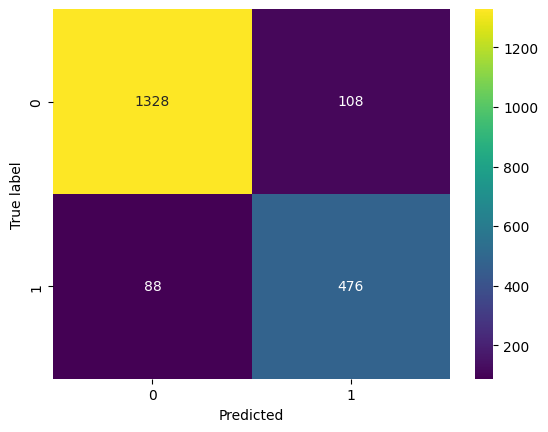

In [165]:
# рассчитываем прогноз на тестовых данных
y_test_3_pred = model_3.predict(X_test_3)

y_test_proba_3 = model_3.predict_proba(X_test_3)

y_test_proba_3_one = y_test_proba_3[:, 1]

print('Площадь ROC-кривой:', roc_auc_score(y_test_3_le, y_test_proba_3_one))

print(f'Метрика Recall на тестовой выборке: {recall_score(y_test_3_le, y_test_3_pred)}')
print(f'Метрика Precision на тестовой выборке: {precision_score(y_test_3_le, y_test_3_pred)}')

cm = confusion_matrix(y_test_3_le, y_test_3_pred)
cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

 У нас на тестовом  выборке - 92,34%.

Истинно отрицательный = 1328, сотрудники, которые не покинули компанию, правильно предсказаны моделью.

Истинно положительный = 476, уволившихся сотрудников, которых модель правильно предсказала.

Ошибка первого рода = 108, количество неушедших сотрудников, которых модель не правильно предсказала, предсказала что остаются.

Ошибка второго рода = 88, количество ушедших сотрудников, которых модель не правильно предсказала, предсказала что остаются.

Нас интересует именно ошибка второго рода, потому что компания хочет быть уверенной в том, что предскажет правильно  количество людей, которые уйдут. Это не так важно эсли в конечном итоге не уйдут (Ошибка первого рода). Проблема с моделю в том, что она хуже ловит ошибки второго рода, чем ошибки первого рода.

## Вывод

Наша лучшая модель:

In [166]:
model_3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_1', OrdinalEncoder(),
                                                  ['last_year_promo']),
                                                 ('ohe_2',
                                                  Pipeline(steps=[('imp_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe_2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('imp_2',
                                                                   SimpleImputer(...
                                                                  ('ord_1',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']]))]),
                                                  ['level', 'workload']),
                                                 ('num', RobustScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate'])])),
                ('models',
                 RandomForestClassifier(max_depth=5, max_features=6,
                                        min_samples_leaf=12,
                                        min_samples_split=11, n_estimators=48,
                                        random_state=42))])

Модель которая лучше справляется это случайные леса из-за того что болшинство принаков - категоряльные значения. 

## Оптимальный порог

Попробуем найти оптимальный порог. Что было бы интересно для компании, так это уменьшить количество ложноотрицательных результатов класса 1, которые мы предсказали, как и класса 0, потому что это нормально, если бы компания предсказала, что сотрудник уволился, а он нет (false positive), но это может будет проблемой, если она предскажет, что сотрудник не уйдет, а действительно уйдет.

### ROC кривая

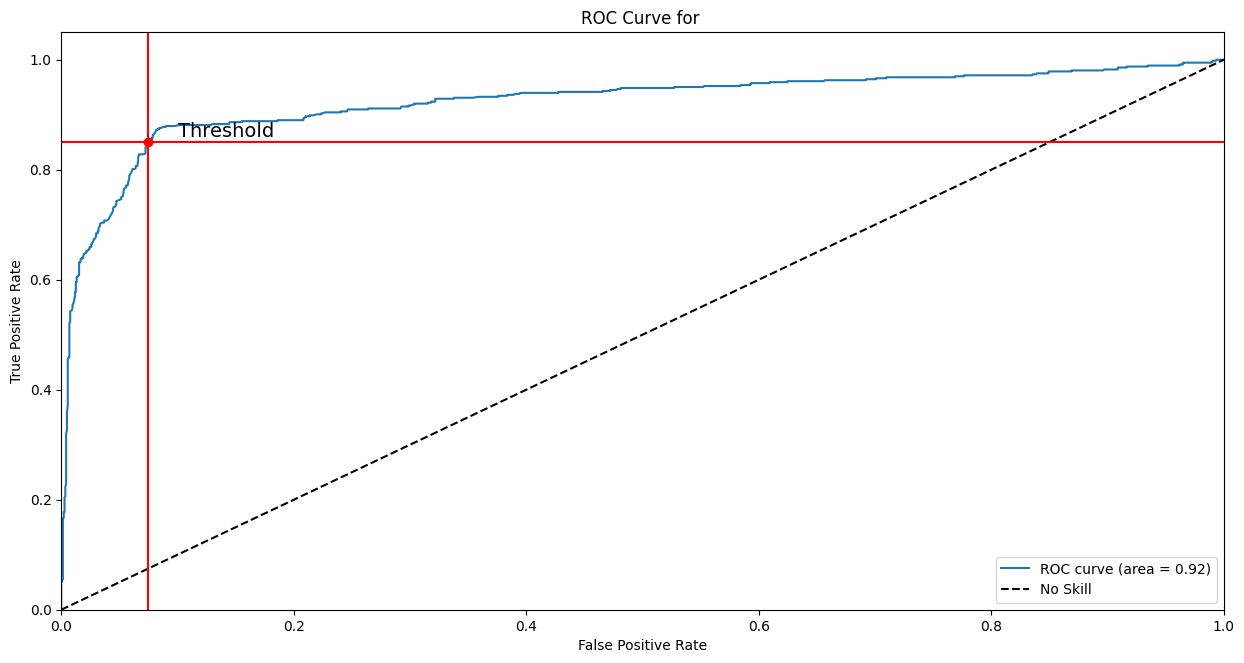

In [167]:
# Calculate ROC curve
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test_3_le, y_test_proba_3_one) 
roc_auc = auc(fpr_3, tpr_3)
# Plot the ROC curve
plt.figure(figsize=(15,7.5))  
plt.plot(fpr_3, tpr_3, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ')
plt.legend()
plt.axvline(x = 0.075, color = 'red');
plt.axhline(y = 0.85, color = 'red');
plt.text(0.1,0.86,'Threshold',fontsize=14, rotation=0);
plt.plot(0.075,0.85,'ro') 
plt.show()

Наша оптималная порога - 0,075.

### Поиск порога

In [168]:
# Получаем все вероятности получить класс 1 - вкусное молоко
data = pd.DataFrame(zip(y_test_3_le, y_test_proba_3_one),
             columns = ['y_test', 'y_proba']).sort_values(by='y_proba',ascending=False)

# Определяем порог  

thresholds = [round(i,2) for i in np.linspace(0,1,num = 20,endpoint=False)]

# создаём переменные, которые будут хранить список новых колонок
columns = []
n_tp = []
n_fp = []
n_fn = []
thresholds_list = []

# добавляем столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    tp = 0
    # Датафрейм data
    columns.append('y_pred_'+ str(i))
    y_pred = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
    data['y_pred_'+ str(i)] = y_pred

    tn, fp, fn, tp = confusion_matrix(data['y_test'], y_pred).ravel()
    
    n_tp.append(tp)
    n_fp.append(fp)
    n_fn.append(fn)
    thresholds_list.append(i)
    y_pred=[]

df_threshold = pd.DataFrame({
    'thresholds': thresholds_list,
    'количество_true_positive':n_tp,
    'количество_false_positive':n_fp,
    'количество_false_negative':n_fn
    })

In [169]:
df_threshold['recall'] = df_threshold['количество_true_positive']/(df_threshold['количество_true_positive']+df_threshold['количество_false_negative'])
df_threshold['precision'] = df_threshold['количество_true_positive']/(df_threshold['количество_true_positive']+df_threshold['количество_false_positive'])
df_threshold.head(10)

thresholds  количество_true_positive  количество_false_positive  \
0        0.00                       564                       1436   
1        0.05                       538                        851   
2        0.10                       528                        552   
3        0.15                       514                        393   
4        0.20                       506                        306   
5        0.25                       501                        267   
6        0.30                       501                        229   
7        0.35                       497                        176   
8        0.40                       494                        124   
9        0.45                       491                        117   

   количество_false_negative    recall  precision  
0                          0  1.000000   0.282000  
1                         26  0.953901   0.387329  
2                         36  0.936170   0.488889  
3                         50  0.911348   0.566703  
4                         58  0.897163   0.623153  
5                         63  0.888298   0.652344  
6                         63  0.888298   0.686301  
7                         67  0.881206   0.738484  
8                         70  0.875887   0.799353  
9                         73  0.870567   0.807566

In [170]:
optimal_threshold = df_threshold.query('количество_false_negative == 0')['thresholds'].min()
optimal_threshold

0.0

Оптимальный порог — 0… что не хорошо. Мы замечаем, что после версии 0,4 мы не можем реально уменьшить количество  false negative.

### График зависимости от прогнозируемого уровня удовлетворенности работой

Попробуем найти проблемное место.

In [171]:
y_proba_series = pd.Series(y_test_proba_3_one)
y_test_pred_series = pd.Series(y_test_3_pred)
y_test_le_series = pd.Series(y_test_3_le) 
y_res = pd.concat([y_proba_series,y_test_le_series, y_test_pred_series, y_test_quit.reset_index()], axis=1)

In [172]:
y_res.set_index('id', inplace=True)
y_res.columns = ['proba', 'test', 'prediction', 'quit']
y_res.head()

proba  test  prediction quit
id                                     
485046  0.132731     0           0   no
686555  0.308653     0           0   no
467458  0.096660     0           0   no
418655  0.091235     0           0   no
789145  0.030332     0           0   no

In [173]:
df_sat_quit = y_res.merge(X_merged['job_satisfaction_rate'], on='id')
df_sat_quit.head()

proba  test  prediction quit  job_satisfaction_rate
id                                                            
485046  0.132731     0           0   no               0.845714
686555  0.308653     0           0   no               0.676667
467458  0.096660     0           0   no               0.697778
418655  0.091235     0           0   no               0.697778
789145  0.030332     0           0   no               0.824643

Сейчас мы будем исследовать 3 сегмента, которые кажутся важными. Мы можем визуализировать эти группы на график зависимости от вероятности прудсказаны объект класс 1 уровня удовлетворенности работой ниже.

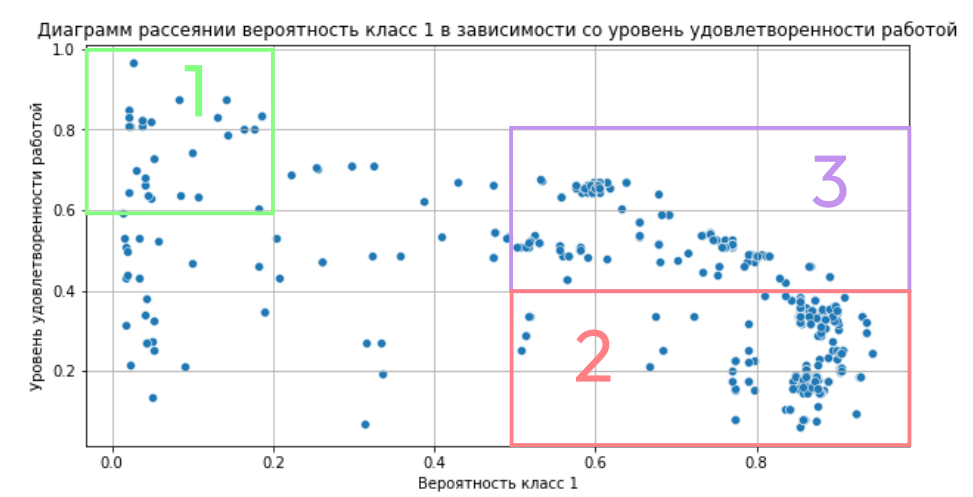

### Сегмент 1

count    564.000000
mean       0.396637
std        0.184321
min        0.060000
25%        0.231875
50%        0.351429
75%        0.520000
max        0.964286
Name: job_satisfaction_rate, dtype: float64

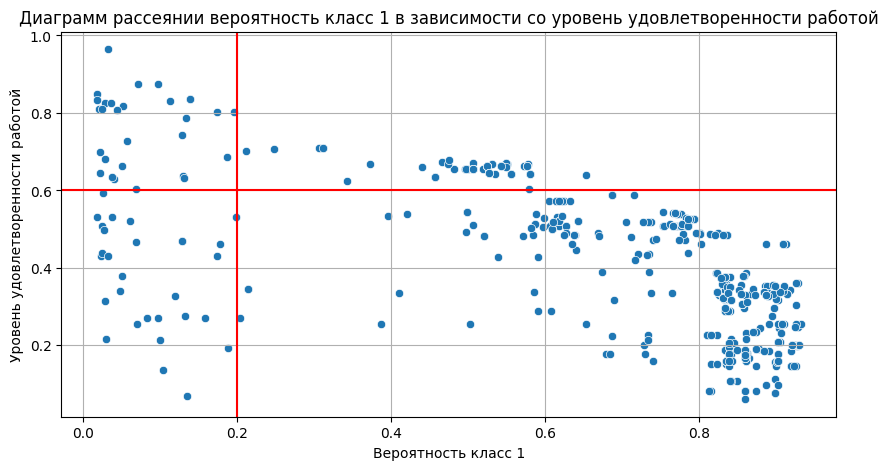

In [174]:
fig, ax = plt.subplots(figsize=(10,5)) 
fig = sns.scatterplot(data=df_sat_quit.query('test != 0'), x='proba', y='job_satisfaction_rate');
plt.axvline(x = 0.2, color = 'red');
plt.axhline(y = 0.6, color = 'red');
ax.set_title('Диаграмм рассеянии вероятность класс 1 в зависимости со уровень удовлетворенности работой');
ax.set_xlabel('Вероятность класс 1');
ax.set_ylabel('Уровень удовлетворенности работой');
ax.grid()
df_sat_quit.query('test != 0')['job_satisfaction_rate'].describe()

Мы видим, что при вероятности 0,2 и уровне удовлетворенности работой более 0,6 мы видим группу данных, которые не были уловлены моделью или с струдностю. Было бы хорошо изучить эти объекты, чтобы увидеть, являются ли они «ценными сотрудниками».

In [175]:
seg_to_study = df_sat_quit.query('test != 0 & job_satisfaction_rate >= 0.6 & proba <=0.2')
seg_to_study.count()

proba                    29
test                     29
prediction               29
quit                     29
job_satisfaction_rate    29
dtype: int64

In [176]:
seg_to_study.count()/df_sat_quit.query('test == 1').count()

proba                    0.051418
test                     0.051418
prediction               0.051418
quit                     0.051418
job_satisfaction_rate    0.051418
dtype: float64

Они представляют 5 % уволившихся сотрудников.

In [177]:
# Получаем индекс сегмента 1
seg_to_study.index
df_seg = X_test_quit.loc[seg_to_study.index]

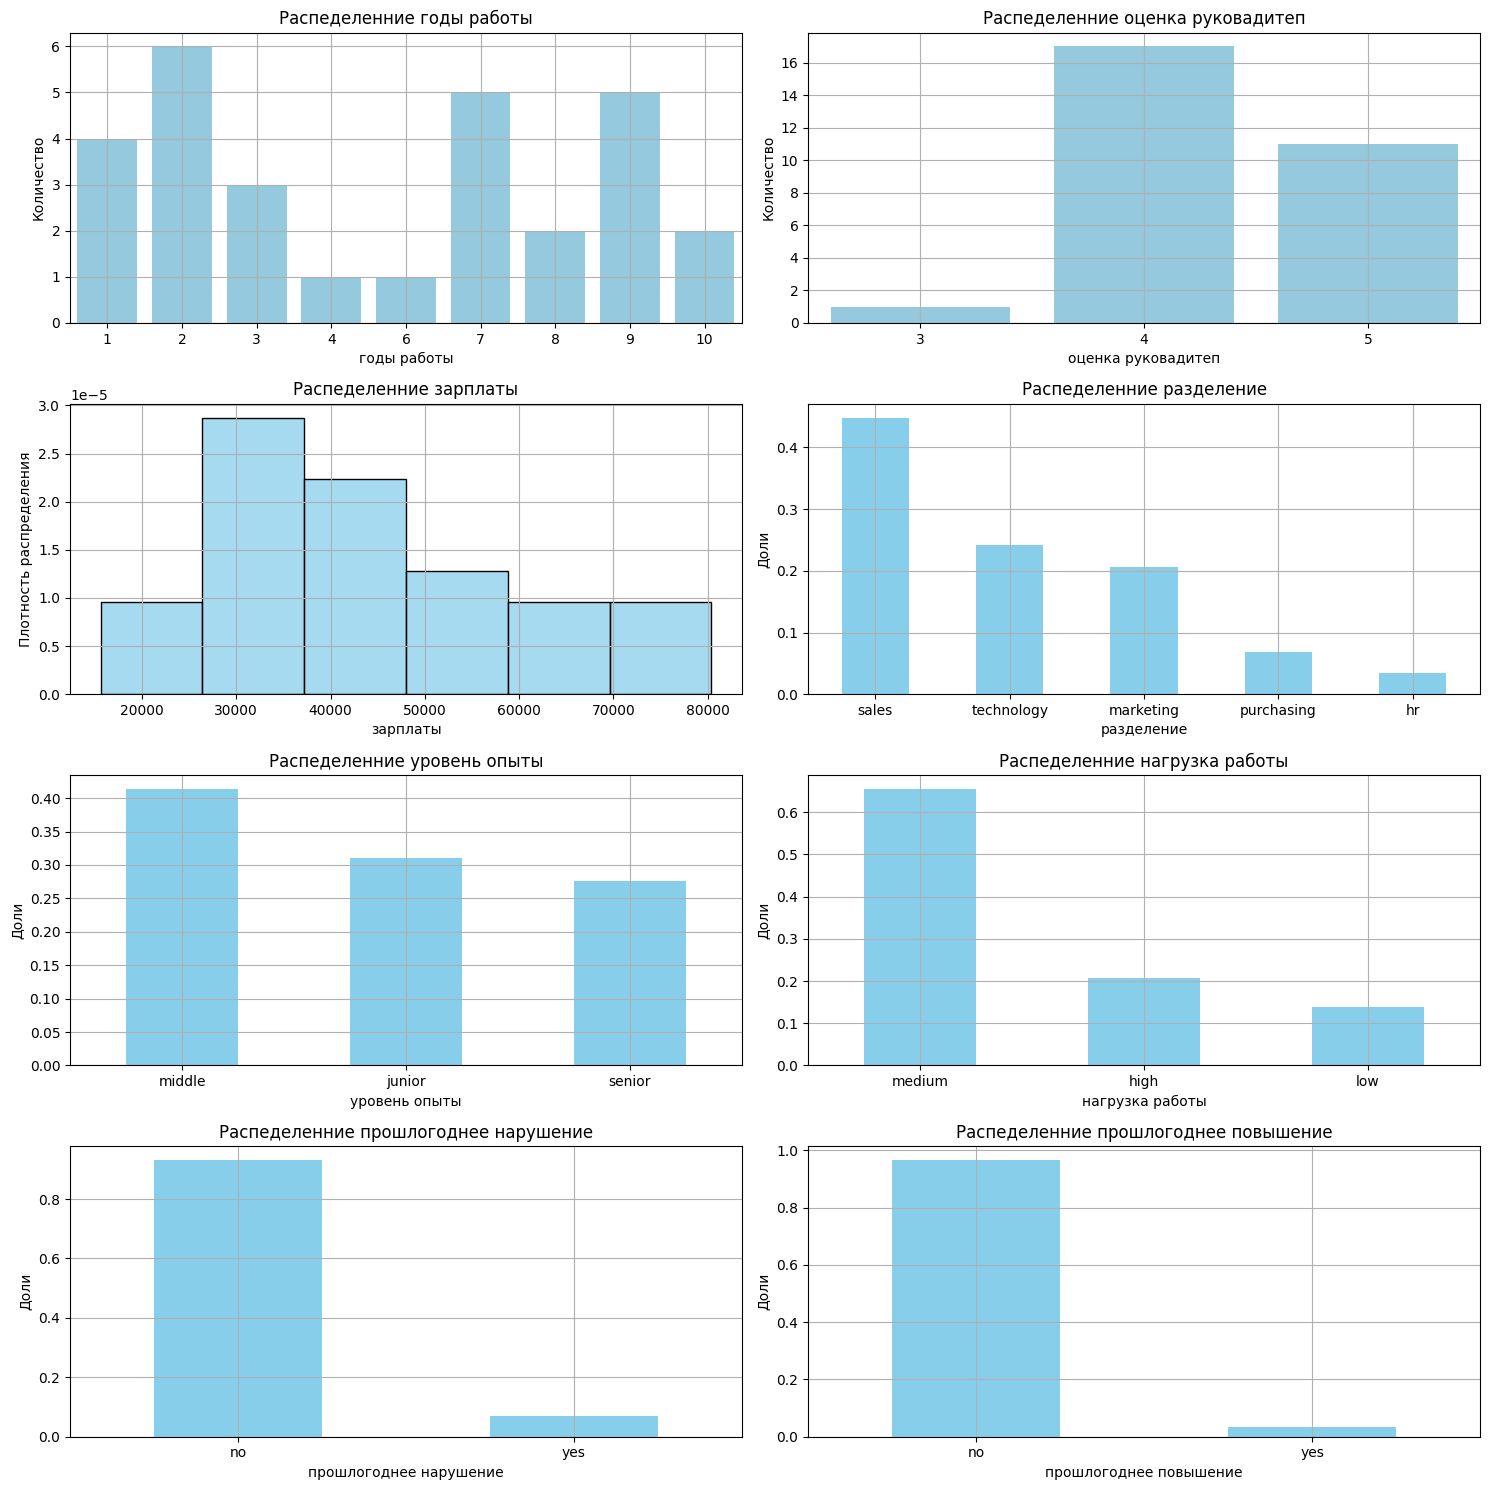

In [178]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

axes = axes.flatten()

data = df_seg

col_ = ['employment_years', 'supervisor_evaluation', 'salary', 'dept', 'level', 'workload', \
       'last_year_promo', 'last_year_violations']
col_names = ['годы работы', 'оценка руковадитеп', 'зарплаты', 'разделение', 'уровень опыты', 'нагрузка работы',\
            'прошлогоднее нарушение', 'прошлогоднее повышение']

for i, col in enumerate(col_):
    
    if i in [0,1]:
        
        sns.countplot(x=data[col], color = 'skyblue', ax=axes[i])
        
        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Количество');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
        
    elif i == 2:
        
        sns.histplot(x=data[col], color = 'skyblue', stat='density', common_norm=False, ax=axes[i])
        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Плотность распределения');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
        
    else:
    
        data[col].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Доли');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();

#axes[5].set_xticklabels(['средний', 'высокий', 'низкий'], rotation=0)

plt.tight_layout()


plt.show()

In [179]:
print('Доли сотрудник в компанни с оценкой 5',
      np.round(len(df_quit.query('supervisor_evaluation == 5'))\
      /len(df_quit['quit']),2))

print('Доли сотрудников, покинувших компанию с оценкой 5, \
среди сотрудников, остающихся в компании с оценкой 5', \
      np.round(len(df_quit.query('quit == "yes" and supervisor_evaluation == 5'))\
      /len(df_quit.query('supervisor_evaluation == 5')['quit']),2))

print('Доли сотрудников, неверно предсказавших уход из компании с оценкой 5,\
среди сотрудников, покидающих компанию с оценкой 5.', \
      np.round(len(df_seg.query('supervisor_evaluation == 5'))\
      /len(df_quit.query('quit == "yes" and supervisor_evaluation == 5')['quit']),2))

print('Доли сотрудников, неверно предсказавших уход из компании с оценкой 5, \
среди всех сотрудников компании с оценкой 5',\
      np.round(len(df_seg.query('supervisor_evaluation == 5'))\
      /len(df_quit.query('supervisor_evaluation == 5')['quit']),2))

Доли сотрудник в компанни с оценкой 5 0.14
Доли сотрудников, покинувших компанию с оценкой 5, среди сотрудников, остающихся в компании с оценкой 5 0.12
Доли сотрудников, неверно предсказавших уход из компании с оценкой 5,среди сотрудников, покидающих компанию с оценкой 5. 0.26
Доли сотрудников, неверно предсказавших уход из компании с оценкой 5, среди всех сотрудников компании с оценкой 5 0.03


Исследование показывает, что большинство ушедших были хорошими сотрудниками (большинство из них имеют оценку 4 и выше), некоторые из них даже рассматривались как ценные сотрудники для компании (оценка руководителя 5). Эти люди были хорошо распределены по различным категориям исследования (отдел, уровень опыта, рабочая нагрузка). Мы снова видим, что основной важной характеристикой, определяющей уровень удовлетворенности работой, была оценка руководителя. Однако модель не может выявить этих людей, поскольку у них хороший уровень удовлетворенности работой.

Здесь мы можем увидеть пределы модели:

- Во-первых, эта модель действительно опирается только на один очень <b>важный параметр - оценку руководителя.</b> Да, анализ важности признаков показал, что наиболее важным признаком для модели был уровень удовлетворенности работой, но давайте не будем забывать, что это если мы вернемся к анализу важности функций из первой части, то скорость в основном определялась оценкой руководителя.

- Люди с хорошей оценкой все равно уходят из компании, и невозможно предугадать, скроют ли эти самые люди свое намерение или ответят честно на опрос. Тот, кто покидает компанию, вероятно, не собирается давать никаких предположений об уходе из нее.

Чтобы иметь возможность поймать этих сотрудников, одним из решений могло бы быть введение дополнительных функций в модель машинного обучения. Если учесть, что одна из основных причин связана с деньгами, мы могли бы ввести признак относительного разрыва между зарплатой сотрудника и средней зарплатой на рынке за ту же работу.

Есть некоторые причины, которые подтолкнули человека к увольнению, и они не всегда связаны с работой, это могут быть и другие личные причины, здоровье, семья... В этом случае компании придется задавать личные вопросы в опросе или использовать какие-то другие функции. : «количество опозданий», «количество взятых больничных»,«пол», «семейное положение», «количество детей», «возраст» (женщина без детей, но готовая уйти в отпуск по причине беременности) . Но, конечно, уход этих людей будет очень трудно предсказать.

Конечно, более сложная модель не всегда хороша, поэтому необходимо проводить тесты, чтобы понять, какие из этих новых функций стоит реализовать в модели.

Среди ценных людей, то есть людей с оценкой 5, компанию покинули 12%. Сотрудник от сегмент 1 составляют 3% от общего числа ценных людей для компании, но 23% уходящих ценных сотрудников не были предсказаны правильно. Другими словами, 77% ценных сотрудников были предсказаны достаточно правильно. Таким образом, вы можете возразить, что было бы неразумно тратить больше времени и денег на прогнозирование ухода этих 2% ценных людей. Более того, если они уйдут по личным причинам, вы, возможно, даже не сможете это предсказать.

<b>рекомендации</b>: Мы замечаем, что эти сотрудники уже имеют значительную зарплату по сравнению с другими сотрудниками, однако мы также замечаем, что большинство из них не получили повышения в прошлом году. Если вы хотите сохранить этих ценных людей, вам придется чаще повышать им зарплату.

### Сегмент 2

count    564.000000
mean       0.396637
std        0.184321
min        0.060000
25%        0.231875
50%        0.351429
75%        0.520000
max        0.964286
Name: job_satisfaction_rate, dtype: float64

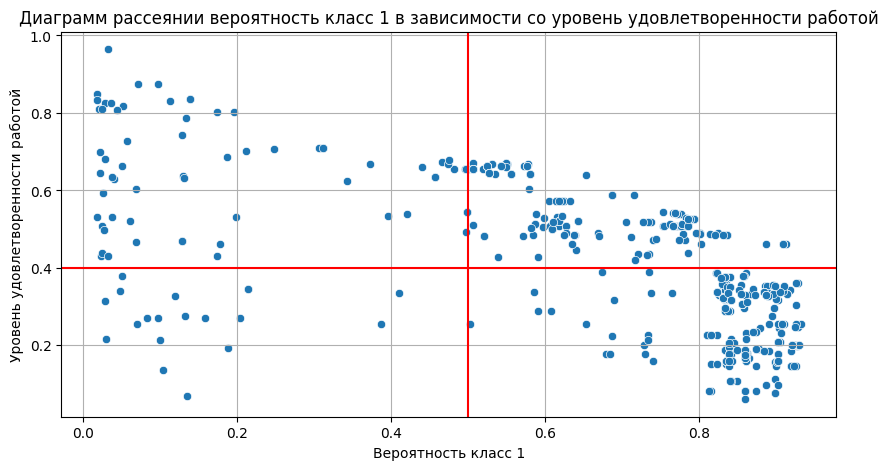

In [180]:
fig, ax = plt.subplots(figsize=(10,5)) 
fig = sns.scatterplot(data=df_sat_quit.query('test != 0'), x='proba', y='job_satisfaction_rate');
plt.axvline(x = 0.5, color = 'red');
plt.axhline(y = 0.4, color = 'red');
ax.set_title('Диаграмм рассеянии вероятность класс 1 в зависимости со уровень удовлетворенности работой');
ax.set_xlabel('Вероятность класс 1')
ax.set_ylabel('Уровень удовлетворенности работой');
ax.grid()
df_sat_quit.query('test != 0')['job_satisfaction_rate'].describe()

In [181]:
seg_to_study_quit = df_sat_quit.query('test != 0 & job_satisfaction_rate <= 0.4 & proba >=0.5')
seg_to_study_quit.count()

proba                    300
test                     300
prediction               300
quit                     300
job_satisfaction_rate    300
dtype: int64

In [182]:
seg_to_study_quit.count()/len(df_sat_quit.query('test != 0'))

proba                    0.531915
test                     0.531915
prediction               0.531915
quit                     0.531915
job_satisfaction_rate    0.531915
dtype: float64

Эта группа для вероятности больше или равной 0,5 и уровень удовлетворенности работой менее 0,4. Эта группа представляет 53,5% увольняющихся сотрудников. Эта группа из false positive, которие были хорошо предзказаны моделю.

In [183]:
# Получаем индекс сегмента 2
seg_to_study_quit.index
df_seg_quit = X_merged.loc[seg_to_study_quit.index]

In [184]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

axes = axes.flatten()

data = df_seg_quit

col_ = ['employment_years', 'supervisor_evaluation', 'salary', 'dept', 'level', 'workload', \
       'last_year_promo', 'last_year_violations']
col_names = ['годы работы', 'оценка руковадитеп', 'зарплаты', 'разделение', 'уровень опыты', 'нагрузка работы',\
            'прошлогоднее повышение', 'прошлогоднее нарушение']

for i, col in enumerate(col_):
    
    if i in [0,1]:
        
        sns.countplot(x=data[col], color = 'skyblue', ax=axes[i])
        
        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Количество');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
        
    elif i == 2:
        
        sns.histplot(x=data[col], color = 'skyblue', ax=axes[i])
        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Плотность распределения');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
        
    else:
    
        data[col].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Доли');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();

axes[5].set_xticklabels(['средний', 'низкий', 'высокий'], rotation=0)

plt.tight_layout()


plt.show()

In [185]:
df_seg_quit_stat = df_seg_quit.describe()

Эта группа, у которой больше шансов покинуть компанию, состоит из 95% сотрудников младшего уровня. 99% сотрудников этого сегмента имеют оценку 3 и ниже. 99% из них проработали 3 года или меньше. Почти 60% из них ушли после первого года обучения. 59% этой группы имеют среднюю нагрузку, а 36% — низкую. Следует отметить, что 29% сотрудников этой группы нарушили трудовой договор.

In [186]:
worst_dict = {
    'отдел': ['продаж'],
    'уровень': ['новичок'],
    'нагрузка работы': ['средний'],
    'годы работы': [df_seg_quit_stat.loc['50%','employment_years']],
    'прошлогоднее повышение': ['нет'],
    'прошлогоднее нарушение': ['нет'],
    'оценка руководителя': [df_seg_quit_stat.loc['50%','supervisor_evaluation']],
    'зарплата': [df_seg_quit_stat.loc['50%','salary']]
    }
worst_type_frame = pd.DataFrame(worst_dict)
worst_type_frame

отдел  уровень нагрузка работы  годы работы прошлогоднее повышение  \
0  продаж  новичок         средний          1.0                    нет   

  прошлогоднее нарушение  оценка руководителя  зарплата  
0                    нет                  3.0   22800.0

In [187]:
worst_table = pd.concat([leaving_type_frame, worst_type_frame], axis=0)
worst_table.index = ['уходящий сотрудник', 'самая хужая група']
worst_table

отдел  уровень нагрузка работы  годы работы  \
уходящий сотрудник  продаж  новичок  низкий-средний          1.0   
самая хужая група   продаж  новичок         средний          1.0   

                   прошлогоднее повышение прошлогоднее нарушение  \
уходящий сотрудник                    нет                    нет   
самая хужая група                     нет                    нет   

                    оценка руководителя  зарплата  
уходящий сотрудник                  3.0   22800.0  
самая хужая група                   3.0   22800.0

Мы получили группу, полностью репрезентативную для нашего портрета, созданного ранее в проекте. Если мы внимательно посмотрим на оценку, то увидим, что только пара сотрудников получила 4 балла, а остальные 274 сотрудника получили 3 или меньше. Мы также видим, что уровень удовлетворенности работой в основном зависит от оценок, а их оценки невысоки.

Ранее мы видели, что 82 сотрудника были младшим звеном. Вероятно, стратегия компании состоит в том, чтобы отбирать и удерживать лучших сотрудников новостей (которые проработали 3 года или меньше). Сотрудники, которые недостаточно хороши для компании (низкая оценка, нарушение условий договора), уходят достаточно быстро (60% из них уходят через 1 год). Напомним что этот сегмент 2 - 53,5 % уволившихся сотрудников.

Есть много молодых людей, которые ищут работу, компания их проверяет и дает им низкую заработную плату. Если они докажут свою ценность для компании, например, получат более высокие оценки, компания повысит им зарплату и постарается ее сохранить. Если они не удовлетворяют потребности компании, имеют низкую оценку, нарушают условия договора, компания не будет их повышать и эти люди уйдут. Тогда компания сможет попробовать новых людей с рынка, которые начнут с низкой заработной платы. Я думаю, что это экономичное решение для компании, которой нужно, чтобы несколько сотрудников выполняли младшие задачи, и отбирали лучших из них, чтобы остаться в компании.

<b>рекомендации</b>: Эта группа состоит из менее ценных сотрудников для компании, и, вероятно, будет лучше, если они уйдут, так компания попробует новых. Однако 82% увольнений новичков — это очень много, это показывает, что компания плохо интегрирует своих новых сотрудников. К исправлению, компания могла бы лучше подержать своих новых сотрудников, обучая их, например, для улучшения их оценок, обеспечивая лучшую корпоративную культуру, чтобы не допустить нарушений трудовой договор новыми сотрудниками.

### Сегмент 3

count    564.000000
mean       0.396637
std        0.184321
min        0.060000
25%        0.231875
50%        0.351429
75%        0.520000
max        0.964286
Name: job_satisfaction_rate, dtype: float64

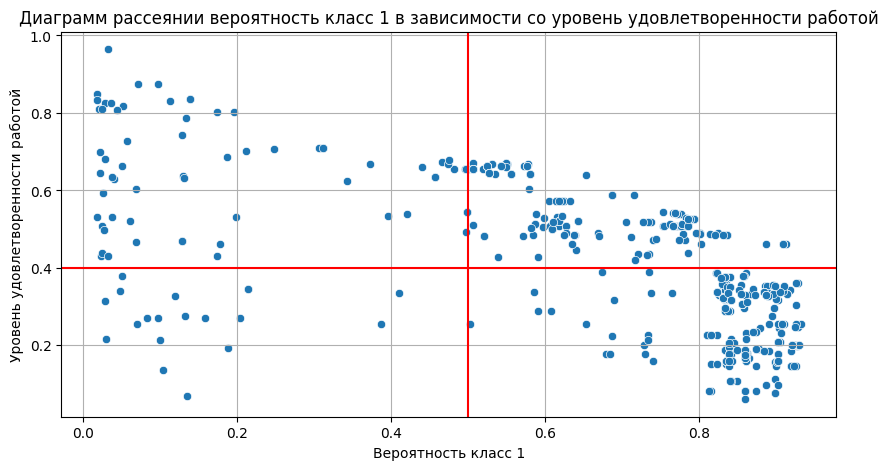

In [188]:
fig, ax = plt.subplots(figsize=(10,5)) 
fig = sns.scatterplot(data=df_sat_quit.query('test != 0'), x='proba', y='job_satisfaction_rate');
plt.axvline(x = 0.5, color = 'red');
plt.axhline(y = 0.4, color = 'red');
ax.set_title('Диаграмм рассеянии вероятность класс 1 в зависимости со уровень удовлетворенности работой');
ax.set_xlabel('Вероятность класс 1')
ax.set_ylabel('Уровень удовлетворенности работой');
ax.grid()
df_sat_quit.query('test != 0')['job_satisfaction_rate'].describe()

In [189]:
seg_to_study_quit_1 = df_sat_quit.query('test != 0 & job_satisfaction_rate > 0.4 & proba >= 0.5')
seg_to_study_quit_1.count()

proba                    176
test                     176
prediction               176
quit                     176
job_satisfaction_rate    176
dtype: int64

In [190]:
seg_to_study_quit_1.count()/len(df_sat_quit.query('test != 0'))

proba                    0.312057
test                     0.312057
prediction               0.312057
quit                     0.312057
job_satisfaction_rate    0.312057
dtype: float64

Эта группа представляет 32% уезжающих сотрудников. Эта группа из false positive, которые были хорошо предзказаны моделю. С этой групой мы изучили 90,5% уезжающих сотрудников.

In [191]:
# Получаем индекс сегмента 3
seg_to_study_quit_1.index
df_seg_quit_1 = X_merged.loc[seg_to_study_quit_1.index]

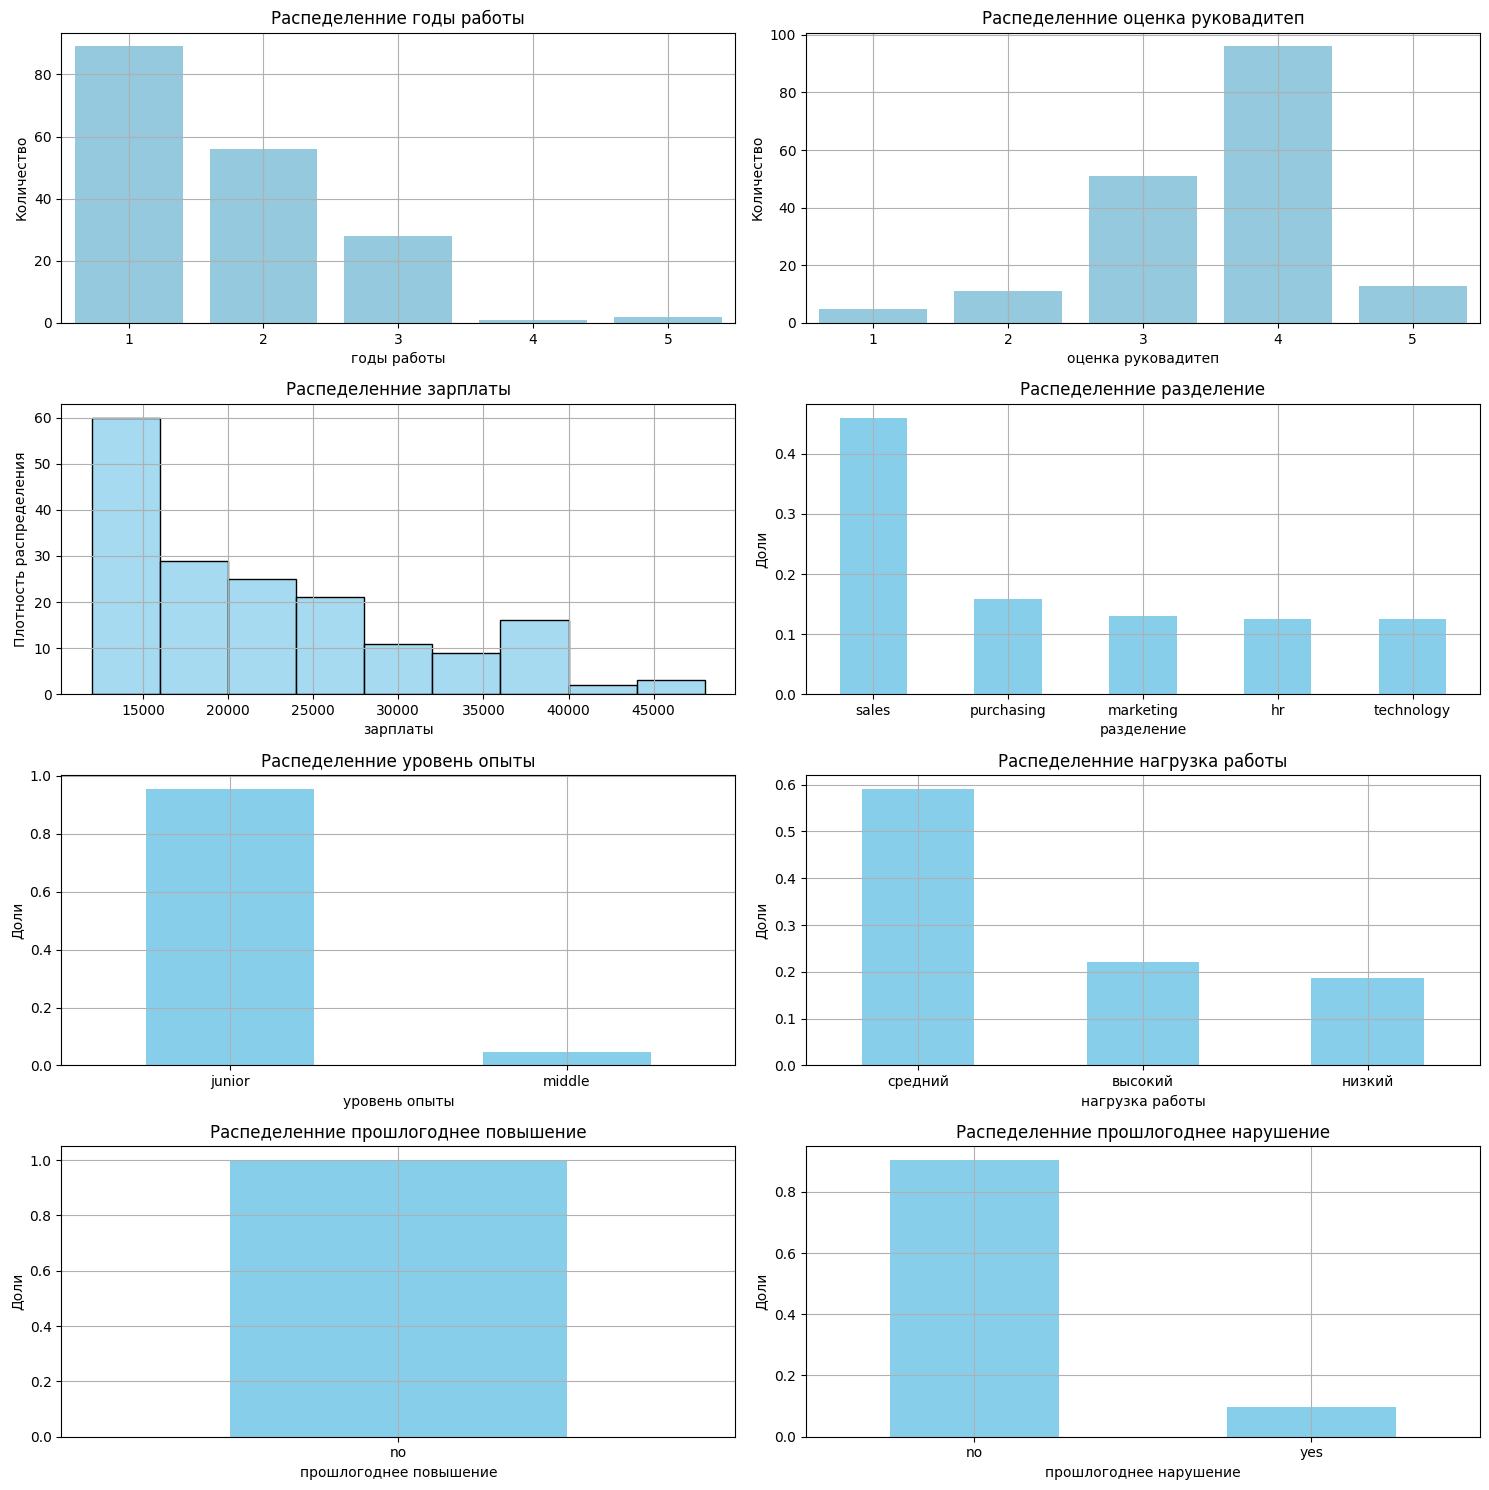

In [192]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

axes = axes.flatten()

data = df_seg_quit_1

col_ = ['employment_years', 'supervisor_evaluation', 'salary', 'dept', 'level', 'workload', \
       'last_year_promo', 'last_year_violations']
col_names = ['годы работы', 'оценка руковадитеп', 'зарплаты', 'разделение', 'уровень опыты', 'нагрузка работы',\
            'прошлогоднее повышение', 'прошлогоднее нарушение']

for i, col in enumerate(col_):
    
    if i in [0,1]:
        
        sns.countplot(x=data[col], color = 'skyblue', ax=axes[i])
        
        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Количество');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
        
    elif i == 2:
        
        sns.histplot(x=data[col], color = 'skyblue', ax=axes[i])
        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Плотность распределения');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();
        
    else:
    
        data[col].value_counts(normalize=True).plot.bar(color=['skyblue'], ax=axes[i]);

        axes[i].set_title(f'Распеделенние {col_names[i]}');

        axes[i].set_xlabel(col_names[i]);
        axes[i].set_ylabel('Доли');
        axes[i].tick_params(axis='x', labelrotation=0)
        axes[i].grid();

axes[5].set_xticklabels(['средний', 'высокий', 'низкий'], rotation=0)

plt.tight_layout()


plt.show()

Эта группа состоит исключительно из новичков, и представляет собой смесь сегментов 1 и 2. Они в целом имеют более высокие оценки, чем сегмент 2, как и сегмент 1, но состоят из молодых людей, подобных сегменту 2. Это молодые люди, которых компания должна стараться удержать. Однако мы видим, что эти сотрудники получали очень низкую заработную плату (около 45% из них получали менее 20 000) и не получали повышения. 

<b>рекомендации</b>: Именно этих молодых сотрудников компания должна попытаться удержать. Чтобы их сохранить, вам следует увеличить им зарплату. Нужно тоже предоставить ими доступ к обучению и обеспечивать лучшую корпоративную культуру (10% нарушение трудовой договор).

# Общий вывод

## Первая часть исследованния

В первый части с регрессионной проблемаой нам необходимо найти хорошую модель, чобы предсказать уровень удовлетворенности работой.

Обнаружили пропуски в тренировочной и тестовой выборке которые мы отработали во время пайплайн. Обнаружили пустые значения которые мы заменили NaN значением что бы они были отработын во время исполнения пайплайн.

Во время исследовательского анализа данных мы понили что:
- 50% сотрудников остаются 3 года и меньшее и только 75% отстаются 6 лет и болшее
- 25% сотрудников получают 3 и меншее по оценкам и 50% получают 4 и 5
- 50% сотрудников получають 30000 и меншее и толко 5% получают 62400 и большее, много выбросов в этом столбце 'salary' из-за того что есть маленькая часть людей ,которые намного больше получают.
- Зарплаты зависят от опыта, времени работы в компани и нагрузки, чем больше эти показател, тем болшее зарплаты получают люди
- 5 одтелов где люди работают, от самого большого по количеству работников до самого меньшего : 'продажи', 'технологии', 'закупки', 'маркетинг', 'HR'
- компания содержит 48% сотрудников с маленьким опытом, 43% са средним опытом и 9% с большим опытом
- у 51% сотрудников - срдная нагрузка, у 30% низка и у 19% высокая
- повышение было толко у 3% сотрудников в прошлом году
- 14% сотрудников нарушили трудовой договор
Все признаки в тренировочной и тестовой выборке у них почти с одним и тем же распределениме. Это важно для предскызывание МО.
Исследование коррелляции с phik не обнаружило большой коррелацци и коллинеарности между нашими признаками. Средняя корреляция была между зарплатой и уровнем опыты, нагрузкой работы и количеством лет работы, количеством лет работы и уровенем опыта, нагрузкой работы и уровенем опыта.

Во время паплайн мы исползовали 2  разные энкодер - OneHotEncoder для столбцов 'dept', 'last_year_promo' и 'last_year_violations' (во время дерева решений мы использовали OrdinalEncoder для 'last_year_promo' и 'last_year_violations) и 'OrdinalEncoder для 'level', 'workload'. Мы тоже предложили 3 разных методы для маштабированнии: StandardScaler, MinMaxScaler и RobustScaler наш метод оптимизации - RandomizedSearchCV выбрал - MinMaxScaler. 

С помощю RandomizedSearchCV мы тоже между разными моделами DecisionTreeRegressor, KNeighborsRegressor, SVR, LinearRegressor, XGboostRegressor, RandomForestRegressor) выбрали RandomForestRegressor(bootstrap=False, max_depth=13, max_features=11, min_samples_leaf=5, min_samples_split=6, n_estimators=41,random_state=42). Метрик который мы выбрали - SAMPE и дали нашей лучшей модели 15,58 на первой кросс-валидации

В исследовании важности признаков обнаружил что самы важный признак - оценка руковадителя, а самый не важный-  повышение в прошлом году. Другие признакие имели среднее влияние на итог обучения.

Мы убрали значение 'last_year_promo' когда мы пытались улучшить модель и не получилось. Мы тогда взяли модел из первой кросс-валидации и получили на тестовой выбоке - 13,68.

У нас самая лучшая модель - RandomForestRegressor потому что эти модели процветают с датафреймами со многими категориальными значенями.

## Вторая част исследования

В второй часть с классикационной проблемой, нам необходимо найти хорошую модель что бы предсказать уйдет ли сотрудник. 
Мы добавили предзказанные уровень удовлетворенности работой из первый части как новый признак для нашего обучение модели.

Обнаружили пропуски в тестовой выборке которы мы отработали во время пайплайн. Обнаружили пустые значения которы мы заменили nan значением что бы они были отработаны во время исполнения пайплайн.

У распределения входных признаков между датафрейми тренировочной и тестовой из первой и второй части те-же тенденции. У целового признака средние дисбалансы, не нужно ничего делать по этому поводу.
Мы смогли ориентироваеться к типу «уволившегося сотрудника», смотря на медиану, у этого сотрудника :
- средняя зарплата - 22800, достаточно низкая, может быть причина его увольнения
- среднее время работы - 1 год, это мало, быстро уходят с работы
- средная уровень работы - новичок
- средная оценка - 3 - средная оценка
- отдел - особенно продажи
- нагрузка работы - низкий-средний
Анализируя это, мы можем понимать что большинство людей которые ушли или не подходили компании, или им не понравилось работать там. Все-таки они достотчно быстро уходят из копании, в большинстве случаев не остаются болшее 3 лет. Мы тоже можем предположить, что они достотчно молодые и что у них мало опыта.

Мы тоже определили кто наверно был важен для компанни, сотрудников которых компания не хочет, чтобы ушли, мы считали что у них оценка руковадителя равна 5. У них, по медияну:
- средняя зарплата - 30000, напомним что это медия зарплат тоже
- средная продолжительность работы - 3 года, это тоже медяны годы работы для датафрейм
- средний уровень работы - новичок - средний
- средная оценка - 3 - средная оценка
- отдел - особенно продажи
- нагрузка работы - средная
Мы видели что эти ценные сотрудники были хорошо распределены в отделах компаннии и у них не обязателно хорошая зарплата или большой опыты, но они нужны в своих задачах.
 
Во время паплайн мы исползовали 2  разные энкодер - OneHotEncoder для столбцов 'dept', 'last_year_promo' и 'last_year_violations' (во время дерева решений мы использовали OrdinalEncoder для 'last_year_promo' и 'last_year_violations) и 'OrdinalEncoder для 'level', 'workload'. Мы тоже предложили 3 разных метода для маштабирования: StandardScaler, MinMaxScaler и RobustScaler наш метод оптимизации - RandomizedSearchCV выбрал - MinMaxScaler. 

С помощю RandomizedSearchCV мы тоже между разными моделами DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression, RandomForestClassifier) выбрали RandomForestClassifier(bootstrap=False, max_depth=8, max_features=7, min_samples_leaf=5, n_estimators=33, random_state=42). Метрик который мы выбрали - roc_auc и дали нашей лучшей модели на первой кросс-валидации 91,5%.

В исследовании важности признаков обнаружил что самый важный признак - уровень удовлетворенности работой, а самый не важный - отдел, прошлогоднее повышение, оценка руковадители, прошлогоднее нарушение. Оценка руковадителя стала не важна из за того что мы добавили признак уровень удовлетворенности работой который был предсказан особенно с оценкой руковадителя. Другие признакие имели среднее влияние на итог обучении.

Модель, которая лучше справляется это дерево решений из-за того что большинство принаков - категоряльные значения. 

Мы попробовали различные комбинации признаков для удаления из датафреймы, и в итоге мы получили лучший результат, когда удалилиубрали столбце 'last_year_violations' (оценка ROC-кривой = 91,6%). Со лучшую моделю, модель дала 92,3% на тестовой выбоке. Качество модел стала лучше. Метики recall и precision тоже улучилось, в конце recall дала 84,3 и precision дала 81,5. Модел стал лучшее чтобы ловит объекты, которые нас интересуют - false negative, сотрудники, которые, по прогнозам модели, не уйдут, но которые все равно ушли.

## Итог и рекомендации

Благодаря результатам модели нам удалось сегментировать сотрудников на три. Мы изучили эти три сегмента, которые вместе представляют 90,5% увольняющихся сотрудников. 

Сегмент 2, представлен 53,5% уволившихся сотрудников, они молоды, но получають низкую оценку и некоторые из них нарушали трудовой договор за последний год. Они не полностью устраивают компанию и являются жертвами политики отбора, проводимой компанией. Однако компания могла бы попытаться лучше интегрировать их, предоставив им лучшую корпоративную культуру (29% нарушение трудовой договор) и предоставив им обучение, чтобы они работали лучше на момент оценки.

Сегмент 3 составляют молодые сотрудники, которых компания должна постараться удержать, поскольку они получили хорошие оценки. Зарплата у них по большей части низкая, и ее повышение будет приветствоваться. Вес таки нужно тоже предоставить им доступ к обучению что бы увеличить их оценки и обеспечивать им лучшую корпоративную культуру (10% нарушение трудовой договор).

Сегмент 1 состоит из лучших представителей уходящих сотрудников. Хотя этот сегмент представляет лишь 5% уходящих сотрудников. Именно таких сотрудников компания должна сохранить любой ценой, поскольку их уход может обернуться для компании большой потерей. В эту группу в основном входят сотрудники со средним стажем, но есть и молодые и очень опытные сотрудники. Эта группа не получила повышения в прошлом году, компании необходимо их повысить, даже если у них и так высокая зарплата. Сотрудники старшего возраста в компании не обязательно покидают компанию по финансовым причинам, но, вероятно, также и по личным причинам. Компания также должна поддерживать свои лучшие и старейшие кардры не только финансово, но и на личном уровне (например, предлагая лучшую медицинскую страховку, большую финансовую помощь для учебы детей, если таковая имеется).